# SMI Data Reduction for Grazing-Incidence Energy Scans

### Setup
##### Package imports

In [1]:
import os
# os.environ["OMP_NUM_THREADS"] = "1" # Prevent numpy from using multiple threads when using emcee multiprocessing.
# These packages should all be installed if the procedure was followed
%matplotlib inline
import matplotlib, matplotlib.pyplot as plt, matplotlib.colors as mplc
from smi_analysis import SMI_beamline
import numpy as np, numpy.typing as npt
import pandas as pd
import fabio
import logging
import scipy.constants as const
import time
import corner
from typing import Literal, Callable
import emcee
import tqdm, tqdm.notebook # For progress bars
from scipy.optimize import curve_fit
import warnings

# Setup options
fabio.TiffIO.logger.setLevel(logging.ERROR)
pd.set_option("display.width", 1000) #display large filenames
pd.set_option('max_colwidth', None)

ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (/nsls2/conda/envs/2024-3.0-py312-tiled/lib/python3.12/site-packages/pyFAI/__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (/nsls2/conda/envs/2024-3.0-py312-tiled/lib/python3.12/site-packages/pyFAI/__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (/nsls2/conda/envs/2024-3.0-py312-tiled/lib/python3.12/site-packages/pyFAI/__init__.py)


In [2]:
# Define some useful functions
en2wav = lambda en: const.h * const.c / (const.e * en)
"""Function to convert energy (eV) to wavelength"""
en2wav(2.45e3)

5.060579527885725e-10

##### Experimental configuration

In [3]:
geometry: Literal['Transmission'] | Literal['Reflection'] = 'Reflection'
"""The measurement geometry"""
energy: float = 2.45e3
"""The energy (keV) at which the scan is performed"""
wavelength: float = en2wav(energy)
"""The wavelength corresponding to `energy`.""" 
beamstop_type: Literal["pindiode"] | Literal['rod'] | None = None # Angle selected away from beam so no need for beamstop.
"""The beamstop type"""
incident_angle = 0
"""The default incident angle (varies) in degrees"""

#WAXS
detector_waxs: Literal['Pilatus900kw'] | Literal['Pilatus1m'] = 'Pilatus900kw'
"""Type of WAXS/SAXS detector"""
sdd_waxs: float | int = 280 # In mm
"""Sample to detector distance in millimeters"""
center_waxs: tuple[int|float, int|float] = (#208, 97)
                                            223, 97)
"""Coordinates of the beam centre at 0 degrees, for the middle detector strip"""
bs_pos_waxs: list[tuple[int, int]] = [(0, 0),
                                      (0, 0), 
                                      (0, 0)
                                     ]
"""The position of the center of the beam stop for each detector angle; [0,0] implies not measured. 
This coordinate is relative to the stitch of the 3 detector strips."""
detector_angles: list[int | float] | npt.NDArray[np.float64 | np.int_] = np.deg2rad(np.array([17.7]) - 0.06) #0.06 is the correction for the WAXS 0 deg detector position
"""The angles of the detector in radians. 
May need to include corrections (-0.06 degs at 0, -0.36 at 20 deg) for position offsets."""


display(pd.DataFrame([
    ("Geometry", geometry),
    ("Energy (keV)", energy),
    ("Wavelength (nm)", wavelength * 1e9),
    ("Sample to Detector Distance (mm)", sdd_waxs),
    ("Beamstop Type", beamstop_type),
    ("Incident Angle (deg)", incident_angle),
    ("Detector Type", detector_waxs),
    ("Center Coords", center_waxs),
    ("Beamstop Coords", bs_pos_waxs),
    ("Detector Angles", detector_angles)
], columns=["Parameter", "Value"]))

#Test the configuration can be loaded!
SMI_waxs = SMI_beamline.SMI_geometry(geometry = geometry,
                                     wav = wavelength,
                                     sdd = sdd_waxs,
                                     alphai = incident_angle,
                                     detector = detector_waxs,
                                     center = center_waxs,
                                     bs_pos = bs_pos_waxs,
                                     bs_kind = beamstop_type,
                                     det_angles=detector_angles)


angles = [detector_angles[0] - np.deg2rad(7.47), detector_angles[0], detector_angles[0] + np.deg2rad(7.47)]
SMI_waxs.calculate_integrator_gi(angles)

Parameter                     Value
0                          Geometry                Reflection
1                      Energy (keV)                    2450.0
2                   Wavelength (nm)                  0.506058
3  Sample to Detector Distance (mm)                       280
4                     Beamstop Type                      None
5              Incident Angle (deg)                         0
6                     Detector Type              Pilatus900kw
7                     Center Coords                 (223, 97)
8                   Beamstop Coords  [(0, 0), (0, 0), (0, 0)]
9                   Detector Angles      [0.3078760800517997]

### Flatfield Data
Data to normalise the detector pixels and remove background.

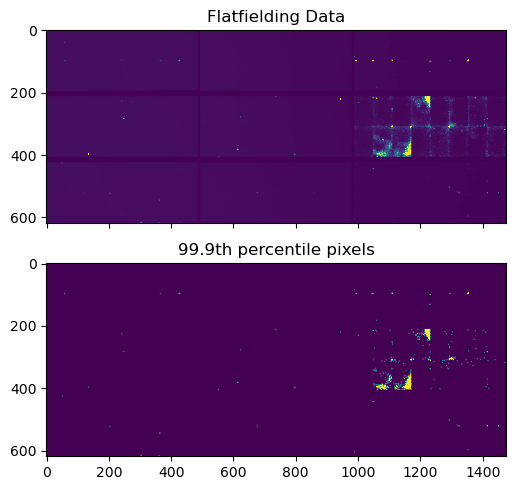

In [4]:
# Past beamline data for flat fielding (normalizing default pixel intensities)
# Note this is done at 2478eV, not all energies.

DRIVE = "/"

# # 2024 Cycle 2 Flatfielding
# CYCLE_FLAT = '2024_3'
# PROPOSAL_FLAT= '314483-Freychet-Flatfielding'
# FLAT_FILE = 'GF_flatfield_Sedge_2450uhighg1600_WZY11_wa30deg_2478eV_20s_id701601_000000_WAXS.tif'

# 2024 Cycle 3 Flatfielding
PROPOSAL_FLAT= '314483_Freychet_15'
FLAT_FILE = 'GF_flatfield_energy2450.00eV_uhighg1600_AEM_3s_2830.00eV_wa40.0_id891696_000000_WAXS.tif'

# Compile and load the flatfield path
FLAT_DIR_PATH = f'{DRIVE}/nsls2/data/smi/legacy/results/data/2025_1/{PROPOSAL_FLAT}/900KW/'
flatfield: npt.NDArray = np.rot90(fabio.open(os.path.join(FLAT_DIR_PATH, FLAT_FILE)).data, 1)

fig,ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))
p = 99.9
percentile = np.percentile(flatfield, p) #99.9th percentile
ax[0].imshow(np.rot90(flatfield, 3), vmin=0, vmax=percentile, interpolation=None)
ax[0].set_title("Flatfielding Data")

erronous =  (flatfield > percentile) * 1.0
ax[1].imshow(np.rot90(erronous,3), vmin=0, vmax=np.max(erronous)/5, interpolation=None)
ax[1].set_title(f"{p}th percentile pixels")
fig.tight_layout()
# plt.close()

### Extra functions for SMI Beamline Masking

##### Detector Masking

In [5]:
def apply_detector_mask_to_array(
    mask: npt.NDArray = np.zeros((1475, 195), dtype=bool)
) -> npt.NDArray[np.bool_]:
    """Sets an array mask for bad pixels; should only be applied to the middle column array"""
    mask[1254:1256, 47] = True
#     mask[979:1050, 0:100] = True
    mask[967, 67] = True
#     mask[490:555, 100:] = True
    mask[1231:1233, 174] = True
    mask[1414: 1416, 179] = True
    mask[858:860, 5] = True
    mask[414, 6] = True
    mask[394, 138] = True
    mask[364:366, 41] = True
    mask[364:366, 96] = True
    mask[304:306, 96:98] =  True
    mask[988, 188:194] = True
    mask[:, 1] = True
    mask[473, 20] = True
    mask[98, 5] = True
    mask[141, 111] = True
#     mask[240:300, 0:50] = True
#     mask[300:425, 125:] = True
    mask[181:183, 97:99] = True
    mask[553:555, 99:100] = True
    # Mask out the final column for the middle row.
    mask[:1475//3] = True

    return mask

def apply_boundary_mask_to_array(
    mask: npt.NDArray = np.zeros((1475, 195), dtype=bool)
) -> npt.NDArray[np.bool_]:
    """Sets an array mask for the boundary pixels; should only be applied to the middle column array"""
    mask[0, :] = True
    mask[-1, :] = True
    mask[:, 0] = True
    mask[:, -1] = True
    return mask

def apply_detector_mask(geom: SMI_beamline.SMI_geometry) -> None:
    """Applies a pre-defined mask for the bad pixels in the SMI beamline"""
    for i, mask in enumerate(geom.masks):
        # Dead pixels in the 2nd detector strip.
        if i%3 == 1: # For multiple WAXS images, always masks the 2nd strip.
            apply_detector_mask_to_array(mask)
        # Add a mask on the boundary
        apply_boundary_mask_to_array(mask)
    return


##### Flatield Masking

In [6]:
FLATFIELD_PERCENTILE = 97.5
"""The percentile of the flatfield data to mask."""
# SAMPLE_PERCENTILE = 100.00
SAMPLE_PERCENTILE = 100.00
"""The percentile of the real data to mask."""

# For flatfielding, ignore/mask reigons between detector pixels.
FLATFIELD_SLICES = [slice(0, 195),  # Ign. flatfield above first frame
                    slice(211, 406),# Ign. flatfield outside middle  
                    slice(-195, None)] # Ign. flatfield below first frame
            
def flatfield_mask(flatfield: npt.NDArray = flatfield, 
                   percentile: float = FLATFIELD_PERCENTILE, 
                   min: float | int = 0) -> npt.NDArray[np.bool_]:
        """
        Returns a mask of flatfield data as a boolean numpy array.
        
        Masks pixels above the `percentile` (by default 99.9)
        and values less than `min` (by default 1).
        """
        # Calculate the 99.9th percentile of the total flatfield data
        p = np.percentile(flatfield, percentile) #99.9th percentile
        erronous =  flatfield > p
        # Also mask pixels well away from the standard deviation
        mean = np.mean(flatfield)
        std = np.std(flatfield)
        erronous |= flatfield > mean + 5*std
        
        # Also mask negative and zero pixels
        negative = flatfield < min
        # Return the overlap of the erronous and negative masks.
        return erronous | negative

def apply_flatfield(geom: SMI_beamline.SMI_geometry, 
                    flatfield: npt.NDArray, 
                    flat_percentile: float | int = FLATFIELD_PERCENTILE,
                    img_percentile: float | int = SAMPLE_PERCENTILE,
                    outliers: bool = False,
                    min : float | int = 1) -> None:
    """Applies a pre-defined flatfield mask and normalisation for the SMI beamline object"""
    flatmask = flatfield_mask(flatfield=flatfield, percentile=flat_percentile, min = min)
    for i, (mask, img) in enumerate(zip(geom.masks, geom.imgs)):
        fmask_i = flatmask[:, FLATFIELD_SLICES[i % 3]]
        # Apply the masking values
        masking_values = np.where(fmask_i == True)
        mask[masking_values] = True
        # Apply the normalisation 
        flat = flatfield[:, FLATFIELD_SLICES[i%3]] # Get flatfield panel
        flat[flat < 0] = 10000 # avoid negative values - note these are already masked
        # Multiply img by max of flatfield, then divide by flatfield to keep integer precision of img.
        temp = ((img * np.max(flatfield[:, FLATFIELD_SLICES[i%3]] * ~mask))
                / (flat * ~mask +1)) * ~mask # Avoid divide by zero, and zero mask values.
        # This line creates a runtime error due to casting... img is int32, flat is float64
        img[:] = temp.astype(np.int32)
    
        # Repeat mask for very large values erronously normalised
        if not img_percentile is None and img_percentile < 100:
            mask2 = flatfield_mask(flatfield=img, percentile=img_percentile, min = 0) # only consider positive values.
            masking_values2 = np.where(mask2 == True)
            mask[masking_values2] = True
        
        # Mask outliers in the data
        if outliers:
            img_mean = np.mean(img[~mask])
            img_std = np.std(img[~mask])
            mask[img > img_mean + 10*img_std] = True
    return


##### Show the stages of Flatfield masking

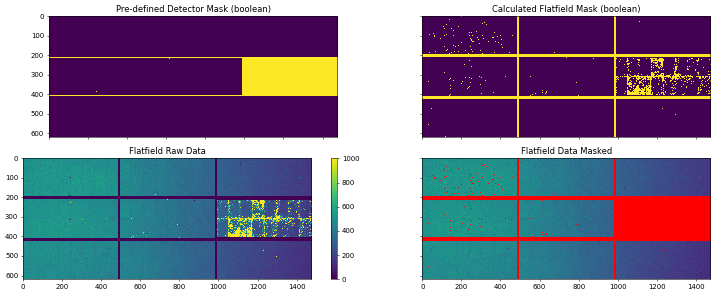

In [7]:
fig,ax = plt.subplots(2,2, figsize=(16,6), dpi=50, sharex=True, sharey=True)

# Detector image is (619, 1475) #619 is 195 * 3 + 2 * 17
# Show the detector masking
grid = np.zeros((195, 1475), dtype=bool)


det_mask = np.c_[apply_boundary_mask_to_array(grid.copy().T),
                 np.zeros((17, 1475), dtype=bool).T,
                 apply_detector_mask_to_array(apply_boundary_mask_to_array(grid.copy().T)), # 195 pixels
                 np.zeros((17, 1475), dtype=bool).T,
                apply_boundary_mask_to_array(grid.copy().T)]
    

det_im = ax[0][0].imshow(np.rot90(det_mask,3), interpolation='nearest') # required to prevent interpolation
ax[0][0].set_title("Pre-defined Detector Mask (boolean)")

# Show the flatfield masking
ff_masked = flatfield_mask(flatfield)
ff_masked_im = ax[0][1].imshow(np.rot90(ff_masked,3), interpolation='nearest') # required to prevent interpolation
ax[0][1].set_title("Calculated Flatfield Mask (boolean)")

# Show the flatfield image
ff_im = ax[1][0].imshow(np.rot90(flatfield,3), vmin = 0, vmax = np.mean(flatfield[~ff_masked]) + 5*np.std(flatfield[~ff_masked]), interpolation='nearest')
plt.colorbar(ff_im)
ax[1][0].set_title("Flatfield Raw Data")

# Show the masks on the flatfield image
joined_mask = ff_masked | det_mask
cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
ff_im_masked = ax[1][1].imshow(np.rot90(flatfield,3), interpolation='nearest',
                               vmin = 0, vmax = np.mean(flatfield[~ff_masked]) + 5*np.std(flatfield[~ff_masked]))
ax[1][1].imshow(np.rot90(joined_mask,3), cmap=cmap, interpolation='nearest')
ax[1][1].set_title("Flatfield Data Masked")

fig.tight_layout()
plt.show()
# plt.close()

### Energy Dependence Flux Calibration for MEX2 Beamline

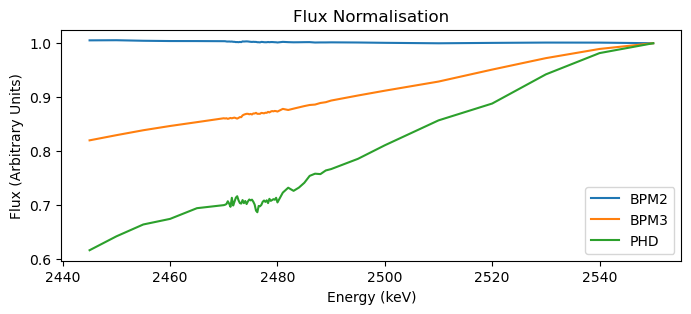

In [8]:
## Flux data from recording photodiode and BPMs
# 2024 Cycle 3 Flux
PROPOSAL_FLUX = '316022_McNeill_02'

# Compile and load the flux paths
FLUX_DIR_PATH = f'{DRIVE}nsls2/data/smi/legacy/results/data/2025_1/{PROPOSAL_FLUX}/1M/'
FLUX_FILES = [file for file in os.listdir(FLUX_DIR_PATH) if file.endswith('.tif') and "Sedge" in file and "eV" in file]

# Parse the flux data from the filenames
flux_energies = []
flux_norm_bpm2 = []
"""A collection of flux normalisation values for each flux file, also known as i0."""
flux_norm_bpm3 = []
"""A collection of flux normalisation values for each flux file, also known as i0."""
flux_norm_phd = []
"""A collection of flux normalisation values for each flux file, also known as i0."""
for file in FLUX_FILES:
    # Example Format:
    # CM_direct_beam_Sedge_2474.75eV_bpm2_124.304_bpm3_4.511_pd_20611.340_id806560_000000_SAXS.tif'
    en_idx = file.find('eV')
    en = float(file[en_idx-7:en_idx])
    bpm2_idx = file.find('bpm2_')
    bpm3_idx = file.find('bpm3_')
    phd_idx = file.find('pd_')
    bpm2 = float(file[bpm2_idx+5:bpm3_idx-1])
    bpm3 = float(file[bpm3_idx+5:phd_idx-1])
    phd = float(file[phd_idx+3:file.find('_id')])
    flux_energies.append(en)
    flux_norm_bpm2.append(bpm2)
    flux_norm_bpm3.append(bpm3)
    flux_norm_phd.append(phd)
    
# Sort the flux data by energy
idx = np.argsort(flux_energies)
flux_energies = np.array(flux_energies)[idx].tolist()
flux_norm_bpm2 = np.array(flux_norm_bpm2)[idx]
flux_norm_bpm3 = np.array(flux_norm_bpm3)[idx]
flux_norm_phd = np.array(flux_norm_phd)[idx]

# Normalise
flux_norm_bpm2 /= flux_norm_bpm2[-1]
flux_norm_bpm3 /= flux_norm_bpm3[-1]
flux_norm_phd /= flux_norm_phd[-1]

fig,ax = plt.subplots(1,1, figsize=(8, 3), sharex=True)
ax.plot(flux_energies, flux_norm_bpm2, label="BPM2")
ax.plot(flux_energies, flux_norm_bpm3, label="BPM3")
ax.plot(flux_energies, flux_norm_phd, label="PHD")
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Flux (Arbitrary Units)")
ax.set_title("Flux Normalisation")
ax.legend()

63 ai0.40


ai0.40 [401629.]
63 ai0.80
ai0.80 [2401240.]
63 ai4.00
ai4.00 [3012009.]
63 ai8.00
ai8.00 [2691280.]
63 ai0.40_rerun
ai0.40_rerun [406073.]


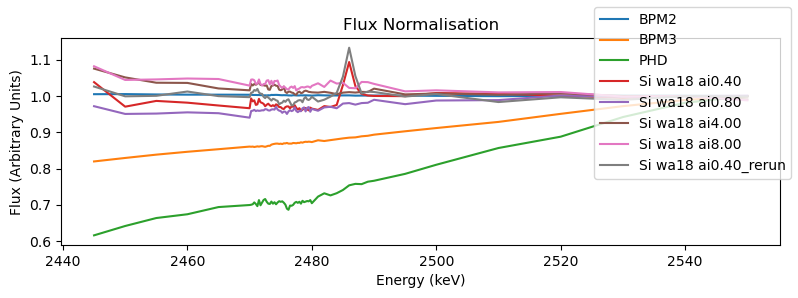

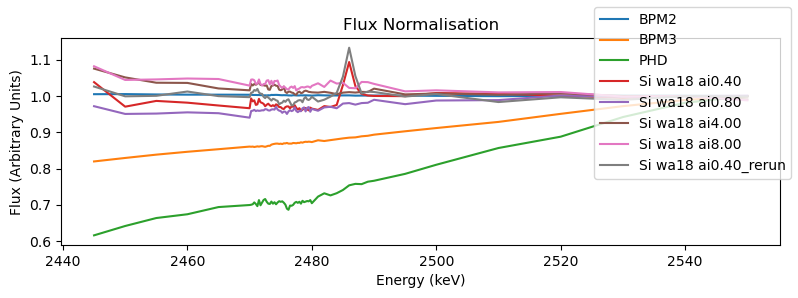

In [9]:
fig,ax = plt.subplots(1,1, figsize=(8, 3), sharex=True)
ax.plot(flux_energies, flux_norm_bpm2, label="BPM2")
ax.plot(flux_energies, flux_norm_bpm3, label="BPM3")
ax.plot(flux_energies, flux_norm_phd, label="PHD")
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Flux (Arbitrary Units)")
ax.set_title("Flux Normalisation")

FLUX_OPTIONS: dict[str, dict[str, npt.NDArray]] = {}
FLUX_NORM: dict[str, npt.NDArray] = {}

for ai in ["ai0.40", "ai0.80", "ai4.00", "ai8.00", "ai0.40_rerun"]:
    ## Additional flux data from silicon reference samples
    # Define the silicon reference data
    WAXS_ANGLE_STRINGS = ['wa18']
    FLUX_SI_CYCLE: str = '2025_1' #YYYY_[1-3]
    FLUX_SI_PROPOSAL_ID = '316022_McNeill_03' #PPPPPP_[Name]_[#]
    FLUX_SI_DIR = f'{DRIVE}nsls2/data/smi/legacy/results/data/2025_1/{FLUX_SI_PROPOSAL_ID}/900KW/'

    # Load the flux filenames
    FLUX_SI_FILES = [file for file in os.listdir(FLUX_SI_DIR) 
                    if file.endswith('.tif') 
                    and "_Si_" in file 
                    and "wide" not in file
                    and "calibrationai" not in file
                    and "clean" in file
                    and (ai in file and "rerun" not in file
                         if "rerun" not in ai
                         else (ai[:-6] in file and "rerun" in file))]
    
    print(len(FLUX_SI_FILES), ai)
    
    if len(FLUX_SI_FILES) == 0:
         print(f"No files found for {ai}")
         #Skip
         continue
    
    flux_energies2 = []
    for j, file in enumerate(FLUX_SI_FILES):
        en_idx = file.find('eV')
        en = file[en_idx-7:en_idx]
        flux_energies2.append(float(en))
        # Sort the flux energies
        flux_energies2 = sorted(flux_energies2)
    
    FLUX_SI_DATASETS: list[list[str]] = [[""] * len(WAXS_ANGLE_STRINGS) for _ in flux_energies2]
    """For each energy, a list of raw data filenames for the silicon reference."""
    for j, file in enumerate(FLUX_SI_FILES):
        en_idx = file.find('eV')
        en = file[en_idx-7:en_idx]
        energies_idx = flux_energies2.index(float(en))
        waxs_angle_idx = [k for k, angle in enumerate(WAXS_ANGLE_STRINGS) if angle in file][0]
        FLUX_SI_DATASETS[energies_idx][waxs_angle_idx] = file

    pixel_summations: npt.NDArray[float] = np.zeros((len(flux_energies2), len(WAXS_ANGLE_STRINGS)))
    """The pixel summations for each sample, energy, and WAXS angle."""
    for j, en in enumerate(flux_energies2):
        for k, angle in enumerate(WAXS_ANGLE_STRINGS):
            if FLUX_SI_DATASETS[j][k] != "":
                # Load the data
                img = fabio.open(os.path.join(FLUX_SI_DIR, FLUX_SI_DATASETS[j][k])).data
                # Mask the data
                new_mask = np.zeros_like(img, dtype=bool).T
                apply_boundary_mask_to_array(new_mask)
                apply_detector_mask_to_array(new_mask)
                new_mask = new_mask.T
                img_mask = flatfield_mask(img, FLATFIELD_PERCENTILE, 0)

                # Perform a summation excluding masked pixels:
                img[img_mask | new_mask] = 0

                #619, 1475 only use middle module
                # Columns
                img[0:619//3] = 0
                # img[619//3 : 2*619//3] = 0
                img[2*619//3:] = 0
                # Rows
                img[:, 0:1475//3] = 0
                # img[:, 1475//3 : 2*1475//3] = 0
                img[:, 2*1475//3:] = 0

                # if j == 0 and k == 0:
                #     plt.figure()
                #     plt.imshow(img)
                #     display(img_mask.shape)

                pixel_summations[j][k] = np.sum(img)
    
    # Normalize the pixel summations
    print(f"{ai}", pixel_summations[-2])
    pixel_summations /= pixel_summations[-2]
    si_ave = np.mean(pixel_summations, axis=1)

    # Plot results
    for k, angle in enumerate(WAXS_ANGLE_STRINGS):
        ax.plot(flux_energies2, pixel_summations[:, k], label=f'Si {angle} {ai}')

    # Select a flux channel for the analysis
    FLUX_CHANNEL = 'si_ave'
    match FLUX_CHANNEL:
        case 'si18':
                FLUX_NORM[ai] = pixel_summations[:, 0]
        case 'si_ave':
                FLUX_NORM[ai] = si_ave
        case _:
                raise ValueError("Invalid flux channel selected.")
    
    FLUX_OPTIONS[ai] = {
        'si18': pixel_summations[:, 0],
        'si_ave': si_ave
    }

# TODO: Change when we get good Si data.
FLUX_NORM["ai0.40"] = FLUX_NORM["ai0.80"]

fig.tight_layout()
fig.legends
fig.legend()
display(fig)

### Data Import

##### Locate the files on your computer and define the output directory

In [ ]:
PROPOSAL_ID = '316022_McNeill_04' #PPPPPP_[Name]_[#]
## ----------- Path to the raw data -----------

# RAW_PATH = f'D:/Datasets/2024-09 SMI/{CYCLE}/{PROPOSAL_ID}/900KW/'
RAW_DIR = f'{DRIVE}/nsls2/data/smi/legacy/results/data/2025_1/{PROPOSAL_ID}/900KW/'
display(pd.DataFrame(os.listdir(RAW_DIR), columns=["Filename"])) #use tail or head to display a subset

## ----------- Create/select the results directory -----------
RESULT_DIR = f'{DRIVE}/nsls2/data/smi/legacy/results/analysis/2025_1/{PROPOSAL_ID}/energy_scan_results/'
created = False
for i in range(len(RESULT_DIR.split("/"))):
    if not os.path.isdir("/".join(RESULT_DIR.split("/")[:i+1])) and not (i==0 and RESULT_DIR[0]=="/"):
        os.mkdir("/".join(RESULT_DIR.split("/")[:i+1]))
        created = True
if not created:
    print("Results path exists!")

Filename
0                            CM_A2_06p_2477.50eV_ai0.40_wa21_bpm155.312_id897136_000000_WAXS.tif
1                            CM_A2_01p_2471.00eV_ai0.80_wa21_bpm155.752_id896319_000000_WAXS.tif
2     CM_wideincidentanglescan_A4_13p_2450.00eV_ai0.571_wa18_bpm155.974_id897866_000000_WAXS.tif
3                            CM_A4_06p_2473.00eV_ai8.00_wa18_bpm155.556_id897734_000000_WAXS.tif
4     CM_wideincidentanglescan_A2_04p_2450.00eV_ai0.613_wa21_bpm156.013_id896599_000000_WAXS.tif
...                                                                                          ...
5035                         CM_A4_06p_2476.75eV_ai0.40_wa18_bpm155.279_id897560_000000_WAXS.tif
5036                         CM_A4_06p_2481.00eV_ai4.00_wa18_bpm155.456_id897700_000000_WAXS.tif
5037  CM_wideincidentanglescan_A4_01p_2450.00eV_ai0.514_wa18_bpm156.045_id899982_000000_WAXS.tif
5038                         CM_A5_06p_2484.00eV_ai8.00_wa21_bpm155.461_id898620_000000_WAXS.tif
5039                         CM_A2_01p_2471.50eV_ai4.00_wa21_bpm155.741_id896384_000000_WAXS.tif

[5040 rows x 1 columns]

Results path exists!


##### Organise files into sample names and data for each detector angle

In [124]:
filename_flags: list[str] = ["A1_05"]
"""The strings you want included in the files processed."""
exclude_flags: list[str] = ['wide', 'calibrationai']
"""The strings you want excluded in the files processed."""

# Find all samples and energies
samples: list[str] = []
"""String names of the unique samples matching patterns in `filename_flags`"""
sample_angles: list[list[float]] = []
"""Unique angles found in the filenames for each sample"""
sample_angle_energies: list[list[list[float]]] = []
"""Unique energies found in the filenames for each sample and angle"""

for file in sorted(os.listdir(RAW_DIR)):
     # Define the flags for the files you want to process, by filtering the filename.
     if all([flag in file for flag in filename_flags] 
            + [flag not in file for flag in exclude_flags]):
        # Find the sample name:
        idx = file.find('_ai')
        sample_substring = file[3:idx-10]
        # If sample substring not in list of samples, add it!
        if sample_substring not in samples:
            sample_idx = len(samples)
            samples.append(sample_substring)
            # Add new lists for the angles and energies
            sample_angles.append([])
            sample_angle_energies.append([])
        else:
            sample_idx = samples.index(sample_substring)
        
        # Find the angle of incidence:
        ai = float(file[idx+3:idx+7])
        if ai not in sample_angles[sample_idx]:
            ai_idx = len(sample_angles[sample_idx])
            sample_angles[sample_idx].append(ai)
            # Add new list for the energies
            sample_angle_energies[sample_idx].append([])
        else:
            ai_idx = sample_angles[sample_idx].index(ai)
        
        # Find the beam energy:
        idx = file.find('eV')
        en = float(file[idx-7:idx])
        if en not in sample_angle_energies[sample_idx][ai_idx]:
            sample_angle_energies[sample_idx][ai_idx].append(en)
    
# Sort the angles and energies
for i in range(len(samples)): 
    for j in range(len(sample_angles[i])):
        # Sort the energies
        sample_angle_energies[i][j] = sorted(sample_angle_energies[i][j])
    # Sort the angles
    args = np.argsort(sample_angles[i])
    sample_angles[i] = np.array(sample_angles[i])[args].tolist()
    sample_angle_energies[i] = np.array(sample_angle_energies[i])[args].tolist()

# Specify the WAXS angles strings to look for, in each sample
WAXS_ANGLE_STRINGS : list[str] = ["wa18"]

# Find all TIF image measurements
datasets: list[list[list[list[str | None]]]] = [[[
                                                [None] * len(WAXS_ANGLE_STRINGS)
                                                for k, _ in enumerate(sample_angle_energies[i][j])]
                                            for j, _ in enumerate(sample_angles[i])]
                                        for i, _ in enumerate(samples)]
"""For each sample, for each angle, for each energy, a list of raw data filenames."""

for i, sample in enumerate(samples):
    for j, file in enumerate(sorted(os.listdir(RAW_DIR))):
        if all([flag in file for flag in filename_flags + [sample, '.tif']] 
                + [flag not in file for flag in exclude_flags]):
            # Check which waxs angle the file is
            ai_idx = file.find('_ai')
            ai = file[ai_idx+3:ai_idx+7]
            en_idx = file.find('eV')
            en = file[en_idx-7:en_idx]
            angles_idx = sample_angles[i].index(float(ai))
            energies_idx = sample_angle_energies[i][angles_idx].index(float(en))
            waxs_angle_idx = [k for k, angle in enumerate(WAXS_ANGLE_STRINGS) if angle in file][0]
            datasets[i][angles_idx][energies_idx][waxs_angle_idx] = file

# Display the number of files for each sample:
display(
      pd.DataFrame([
            (sample, np.sum(
                [len(sample_angle_energies[i][j]) * len(WAXS_ANGLE_STRINGS)
                    for j in range(len(sample_angles[i]))]
            ))
            for i, sample in enumerate(samples)
      ], columns=["Sample Name", "Number of Files"])
)

Sample Name  Number of Files
0                A1_05              252
1  fixedpossweep_A1_05               28

##### Organise the unique energies, and interpolate any missing values for normalisaiton

In [116]:
global_energies = np.unique([en for sample in sample_angle_energies for angle in sample for en in angle])
if np.all(global_energies != flux_energies):
    print("The flux energies do not match the global energies.")
    print("Generating interpolated values")
    # for i, en in enumerate(global_energies):
    #     if en not in flux_energies:
    #         idx = np.searchsorted(flux_energies, en)
    #         flux_energies.insert(idx, en)
    #         FLUX_NORM[f"ai{ai:0.2f}"][f"ai{ai:0.2f}"][f"ai{ai:0.2f}"][f"ai{ai:0.2f}"][f"ai{ai:0.2f}"][f"ai{ai:0.2f}"]_bpm2 = np.r_[flux_norm_bpm2[:idx], np.interp(en, flux_energies, flux_norm_bpm2), flux_norm_bpm2[idx:]]
    #         flux_norm_bpm3 = np.r_[flux_norm_bpm3[:idx], np.interp(en, flux_energies, flux_norm_bpm3), flux_norm_bpm3[idx:]]
    #         flux_norm_phd = np.r_[flux_norm_phd[:idx], np.interp(en, flux_energies, flux_norm_phd), flux_norm_phd[idx:]]
    #         si0 = np.r_[pixel_summations[:, 0][:idx], np.interp(en, flux_energies, pixel_summations[:, 0]), pixel_summations[:, 0][idx:]]
    #         si20 = np.r_[pixel_summations[:, 1][:idx], np.interp(en, flux_energies, pixel_summations[:, 1]), pixel_summations[:, 1][idx:]]
    #         si_ave = np.r_[si_ave[:idx], np.interp(en, flux_energies, si_ave), si_ave[idx:]]
            
    #         # Re-assign new objects
    #         FLUX_OPTIONS = {
    #             'bpm2': flux_norm_bpm2,
    #             'bpm3': flux_norm_bpm3,
    #             'phd': flux_norm_phd,
    #             'si0': si0,
    #             'si20': si20,
    #             'si_ave': si_ave
    #         }

# Reduction
### Run the first sample to check everything is working and define the Q fit ranges

##### First check sample image exists and looks reasonable!

In [117]:
test_files: list[int] = [#0, 20, 40, -2]
                         0, -2]
"""The index of each sample's test file"""

"The index of each sample's test file"

A1_01 | CM__2445.00eV_ai0.40_wa18_bpm156.130_id893611_000000_WAXS.tif


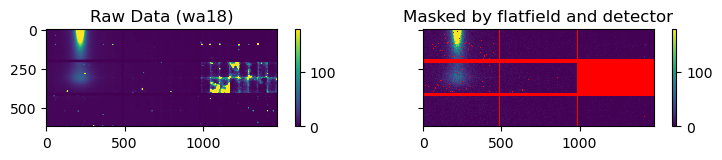

A1_01 | CM_fixedpossweep__2540.00eV_ai0.40_wa18_bpm155.165_id893449_000000_WAXS.tif


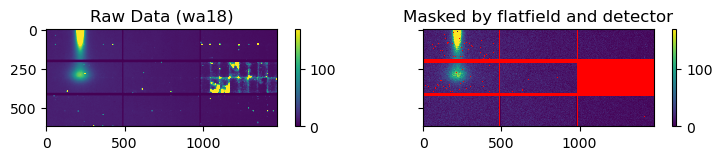

------------------------------
A1_01 | CM__2445.00eV_ai0.80_wa18_bpm156.163_id893674_000000_WAXS.tif


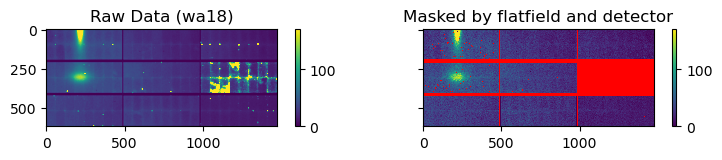

A1_01 | CM_fixedpossweep__2540.00eV_ai0.80_wa18_bpm155.212_id893456_000000_WAXS.tif


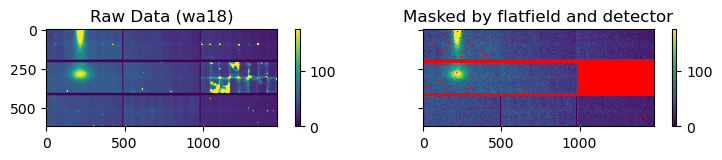

------------------------------
A1_02 | CM__2445.00eV_ai0.40_wa18_bpm156.052_id894038_000000_WAXS.tif


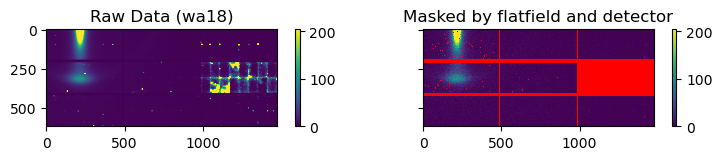

A1_02 | CM_fixedpossweep__2540.00eV_ai0.40_wa18_bpm155.240_id893876_000000_WAXS.tif


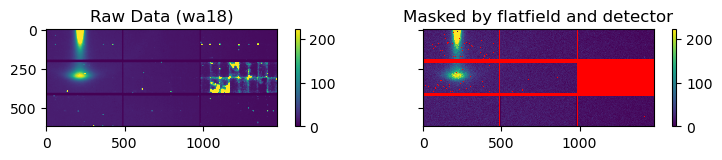

------------------------------


In [47]:
for i, sample in enumerate(samples):
    for j, ai in enumerate(sample_angles[i]):
        if not (i == 0 or j == 0):
            continue
        for test_file in test_files:
            print(sample, "|", datasets[i][j][test_file][0].replace(sample, ""))
            fig,ax = plt.subplots(len(WAXS_ANGLE_STRINGS),2, figsize=(8,len(WAXS_ANGLE_STRINGS)*1.5), sharex=True, sharey=True)
            for k, angle in enumerate(WAXS_ANGLE_STRINGS):
                fname = datasets[i][j][test_file][k]
                # fig.suptitle(sample)
                # Use 
                img=fabio.open(os.path.join(RAW_DIR, fname)).data
                a = ax[k][0] if len(WAXS_ANGLE_STRINGS) > 1 else ax[0]
                mappable = a.imshow(img, vmin=0, vmax=np.percentile(img,99))
                a.set_title(f"Raw Data ({angle})")
                plt.colorbar(mappable)
                
                # Show the masks on the flatfield image
                a = ax[k][1] if len(WAXS_ANGLE_STRINGS) > 1 else ax[1]
                cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
                ff_im_masked = a.imshow(img, interpolation='nearest',
                                        vmin = 0, vmax = np.percentile(img, 99))
                a.imshow(np.rot90(joined_mask,3), cmap=cmap, interpolation='nearest')
                a.set_title("Masked by flatfield and detector")
                plt.colorbar(ff_im_masked)

                if k !=0:
                    break
        
            
            fig.tight_layout()
            plt.show()
        print("------------------------------")
        if j!=0:
            break
    if i!=0:
        break
        
        

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai4.00_wa18_bpm156.244_id893737_000000_WAXS.tif       2445.0                   4.0

Time to update geometry: 0:00:00.000004
Time to update wavelength: 0:00:00.000003


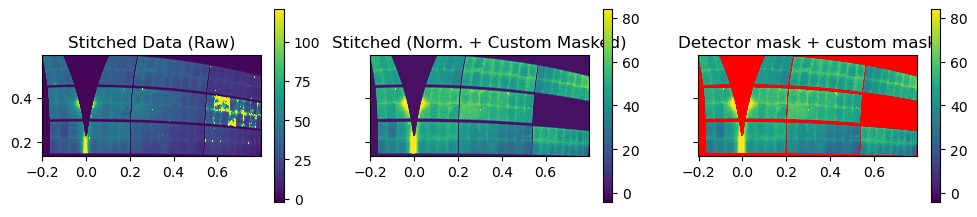

In [118]:
## Note: Tried digging into SMI_beamline > SMI_geometry > stitching_data > stitch.stitching, to understand how the mask is stitched. 
## Too difficult to follow, for some reason mask is not really applied well in the first sector of the detector.
import datetime

for i, sample in enumerate(samples):
    # At each sample, reset the SMI_waxs object
    if SMI_waxs is not None and len(SMI_waxs.ai) != 0:
        # for ai in SMI_waxs.ai:
        #     ai.reset()
        SMI_waxs.ai = []
    
    for j, ai in enumerate(sample_angles[i]):
        if not (i == 0 and j == 2):
            continue
        for test_file in test_files:
            # Setup a figure and open the file
            fig,ax = plt.subplots(1,3, figsize=(12,2.5), sharex=True, sharey=True)
            fnames = datasets[i][j][test_file]
            fname = fnames[0]
            
            # Collect the metadata
            en_idx = fname.find('eV_')
            en = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai2 = float(fname[ai_idx+3:ai_idx+7])
            assert(ai == ai2)
            
            display(pd.DataFrame([
                    (fname, en, ai)
                    ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
            
            # if i == 0 and j == 0 and (test_file == test_files[0] or test_file == test_files[1]):
            #     print(SMI_waxs.ai)
            
            # Update the geometry/'
            tinit = datetime.datetime.now()
            SMI_waxs.alphai = ai
            tfin = datetime.datetime.now()
            print(f"Time to update geometry: {tfin-tinit}")
            
            tinit = datetime.datetime.now()
            SMI_waxs.wav = en2wav(en)
            tfin = datetime.datetime.now()
            print(f"Time to update wavelength: {tfin-tinit}")
            
            # if i == 0 and j == 0 and (test_file == test_files[0] or test_file == test_files[1]):
            #     print(SMI_waxs.ai)
            
            # Reset the masks
            for mask in SMI_waxs.masks:
                mask[:,:] = False
            
            # Plot the unmodified data
            SMI_waxs.open_data(RAW_DIR, fnames)
            
            SMI_waxs.stitching_data(interp_factor=2, flag_scale=True, timing=True if i==0 and j==0 else False, perpendicular=True)
            # mp = ax[0].imshow(SMI_waxs.img_st,
            #         extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            mp = ax[0].imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
                    # vmin=0,
                    vmax=np.percentile(SMI_waxs.img_st, 99)
            )
            plt.colorbar(mp)
            ax[0].set_title("Stitched Data (Raw)")
            
            # Plot the flatfield / masked normalized data
            SMI_waxs.open_data(RAW_DIR, fnames)
            apply_detector_mask(SMI_waxs)
            # apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
            apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE, outliers=False)
            # apply_detector_mask(SMI_waxs)
            
            SMI_waxs.stitching_data(interp_factor=1, flag_scale=True, perpendicular=True)
            # mp = ax[1].imshow(SMI_waxs.img_st,
                    # extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            mp = ax[1].imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
                    # vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                    vmax=np.percentile(SMI_waxs.img_st, 99.0)
            )
            plt.colorbar(mp)
            ax[1].set_title("Stitched (Norm. + Custom Masked)")
            
            # Show the total mask over the image
            cmap = mplc.LinearSegmentedColormap.from_list("Mask", [(256,0,0,0),(256,0,0,256)], N=2)
            mp = ax[2].imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
                    # vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                    vmax=np.percentile(SMI_waxs.img_st, 99.0)
            )
            ax[2].imshow(SMI_waxs.mask_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1],],
                    cmap=cmap
            )
            plt.colorbar(mp)
            ax[2].set_title("Detector mask + custom mask")
            plt.show()
            break
        if i!=0:
            break
        break
    break


##### Generate a ROI to check the beam-centre 
###### Also check that the beamcentre is correct by symmetry (unless sample has anisotropic behavour)

In [119]:
# Define the radial angles
AZIMUTHAL_WIDTH = 10
"""The +- azimuthal width of the orthogonal range"""
AZIMUTHAL_INPLANE = 10
"""The azimuthal angle for the in-plane scattering"""
AZIMUTHAL_OUTOFPLANE = 80
"""The azimuthal angle for the out-of-plane averaging"""
RADIAL_WIDTH = 35
"""The +- azimuthal width for the radial averaging"""
AZIMUTHAL_RADIAL = 45
"""The azimuthal angle for the radial averaging"""

'The azimuthal angle for the radial averaging'

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai0.40_wa18_bpm155.746_id892741_000000_WAXS.tif       2445.0                   0.4

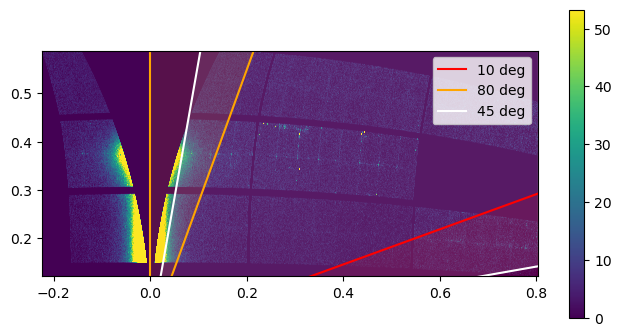

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2540.00eV_ai0.40_wa18_bpm154.788_id892802_000000_WAXS.tif       2540.0                   0.4

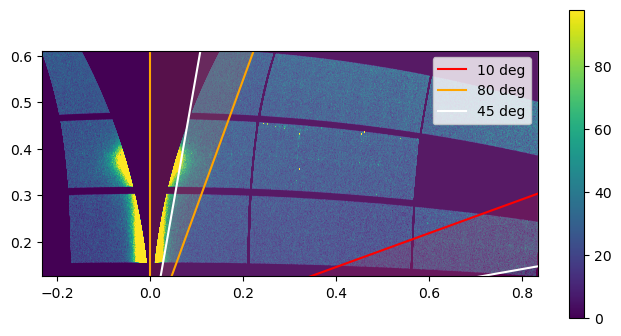

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai0.80_wa18_bpm155.891_id892804_000000_WAXS.tif       2445.0                   0.8

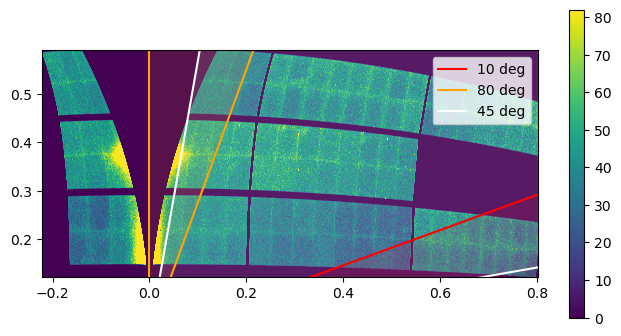

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2540.00eV_ai0.80_wa18_bpm154.881_id892865_000000_WAXS.tif       2540.0                   0.8

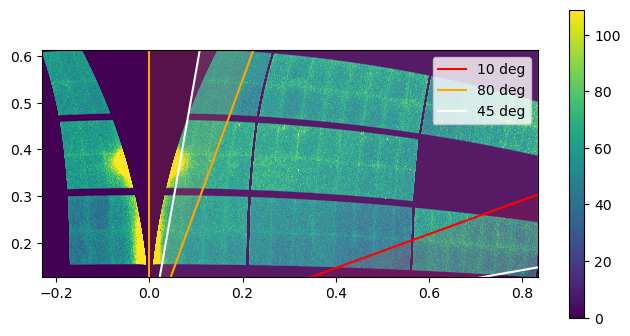

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai4.00_wa18_bpm155.801_id892867_000000_WAXS.tif       2445.0                   4.0

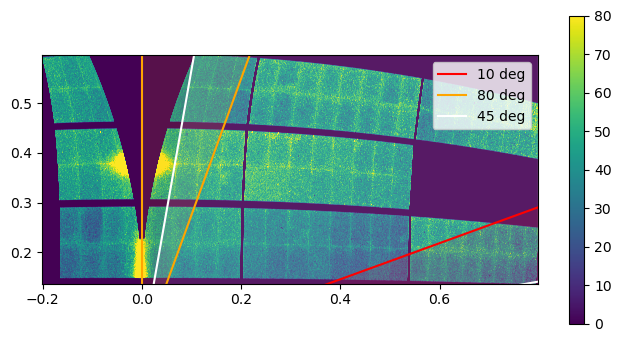

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2540.00eV_ai4.00_wa18_bpm154.954_id892928_000000_WAXS.tif       2540.0                   4.0

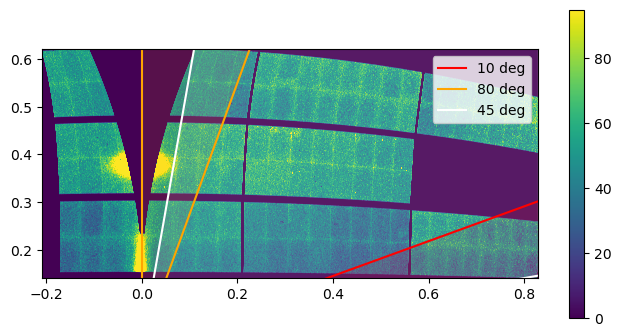

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai8.00_wa18_bpm155.943_id892930_000000_WAXS.tif       2445.0                   8.0

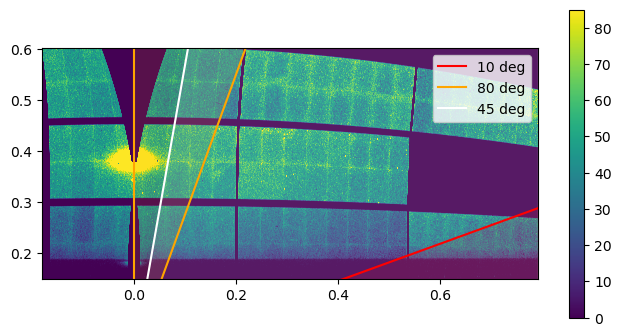

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2540.00eV_ai8.00_wa18_bpm154.965_id892991_000000_WAXS.tif       2540.0                   8.0

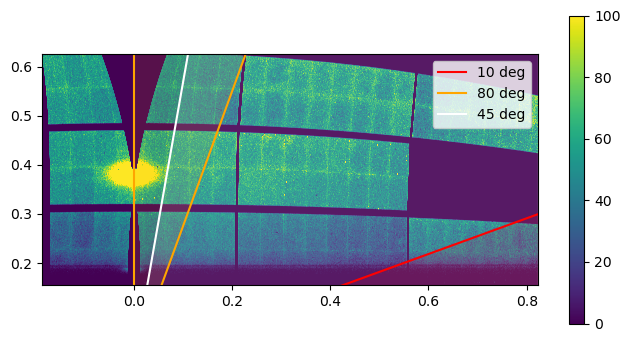

In [34]:
for i, sample in enumerate(samples):
    for j, ai in enumerate(sample_angles[i]):
        if not (i==0 or j==0):
            continue
        for test_file in test_files:
            # Setup a figure and open the file
            fnames = datasets[i][j][test_file]
            if None in fnames:
                print(f"Skipping {sample} due to missing files.")
                continue
            fname = fnames[0]
            
            # Collect the metadata
            en_idx = fname.find('eV_')
            en = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai2 = float(fname[ai_idx+3:ai_idx+7])
            assert(ai==ai2)
            display(pd.DataFrame([
                    (fname, en, ai)
                    ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
            
            # Update the geometry
            SMI_waxs.alphai = ai
            SMI_waxs.wav = en2wav(en)

            # Show the angles on a plot
            fig,ax = plt.subplots(1,1, figsize=(8,4), sharex=True, sharey=True)

            SMI_waxs.open_data(RAW_DIR, fnames)
            apply_detector_mask(SMI_waxs)
            apply_flatfield(SMI_waxs, flatfield)
            energies_idx = flux_energies.index(en) # for normalisation
            for img in SMI_waxs.imgs:
                if ai == 4.0:
                    img[:] = (img[:] / FLUX_NORM[f"ai{8.0:0.2f}"][energies_idx]).astype(np.int32)
                else:
                    img[:] = (img[:] / FLUX_NORM[f"ai{ai:0.2f}"][energies_idx]).astype(np.int32)
            SMI_waxs.stitching_data(interp_factor=5, flag_scale=True, perpendicular=True)

            ax.set_ylim(SMI_waxs.qz[0], SMI_waxs.qz[-1])
            ax.set_xlim(SMI_waxs.qp[0], SMI_waxs.qp[-1])
            # mp = ax[1].imshow(SMI_waxs.img_st,
                    # extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
            mp = ax.imshow(SMI_waxs.img_st,
                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]], 
                    vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                    vmax=np.percentile(SMI_waxs.img_st, 99.0)
            )
            plt.colorbar(mp)

            # Plot the azimuthal and radial angles
            colors = ['r', 'orange', 'white'][::-1]
            for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
                    # Generate a set of x points to plot lines of.
                    q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
                    # Calculate the x and y gradients for the lines
                    m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
                    m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
                    # Calculate the x & y values for the lines
                    q_x1 = q_x if m1 != np.inf else np.zeros(100)
                    q_x2 = q_x if m2 != np.inf else np.zeros(100)
                    y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                    y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                    # Plot the lines
                    color = colors.pop()
                    ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
                    ax.plot(q_x2, y2, color=color, linestyle='-')
                    # If gradient is inf, calculate an alternative fill between
                    if m2 == np.inf:
                            ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
                    else:
                            ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
            ax.legend()
            plt.show()
            # ax.close()


##### Calculate the azimuthal/radial averages

In [120]:
NPOINTS_RADIAL_AVE: int = 2000 # Use a number the is consistent with the pixel density?

Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai0.40_wa18_bpm155.746_id892741_000000_WAXS.tif       2445.0                   0.4

Time to update geometry: 0:00:00.393363
Time to update wavelength: 0:00:00.000005
Time to open data: 0:00:00.004541
Time to apply masks: 0:00:00.011551
Time to normalise data: 0:00:00.000850
Time to stitch data: 0:00:04.278206
Time to radial average: 0:00:10.448531


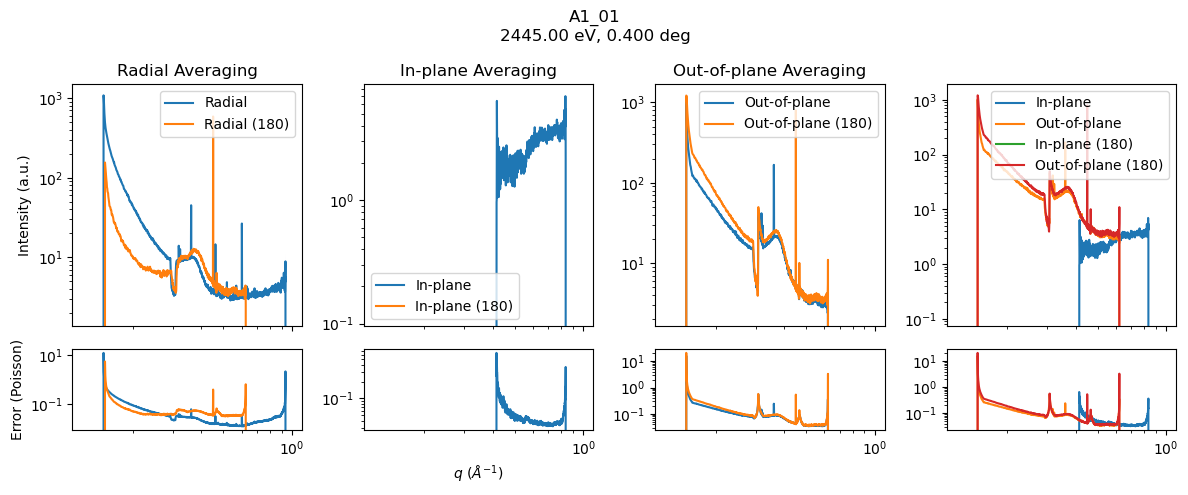

Time to plot: 0:00:00.791768


Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2540.00eV_ai0.40_wa18_bpm154.788_id892802_000000_WAXS.tif       2540.0                   0.4

Time to update geometry: 0:00:00.000003
Time to update wavelength: 0:00:00.410837
Time to open data: 0:00:00.005285
Time to apply masks: 0:00:00.011561
Time to normalise data: 0:00:00.000838
Time to stitch data: 0:00:04.304931
Time to radial average: 0:00:10.494172


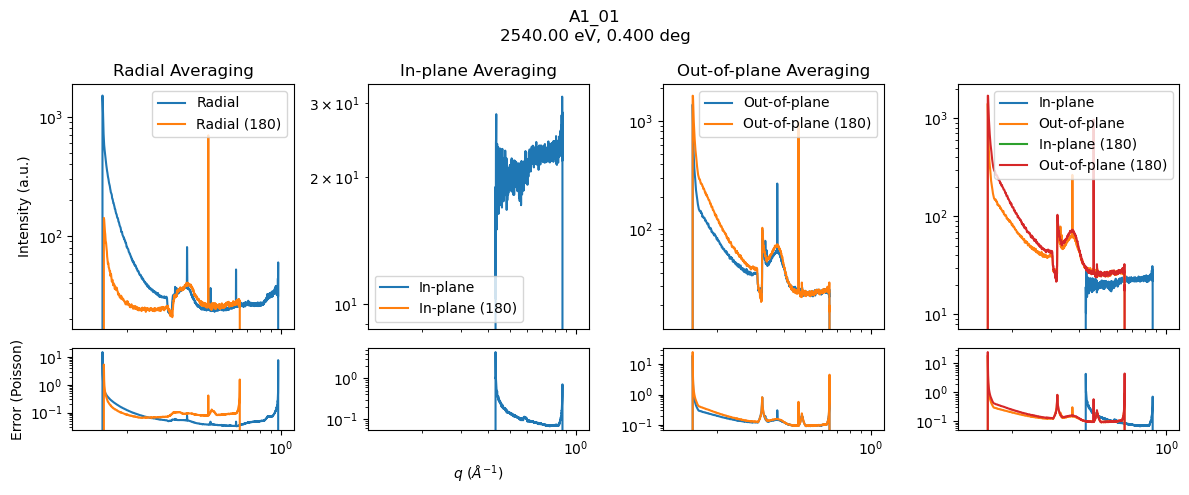

Time to plot: 0:00:00.812085


Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai0.80_wa18_bpm155.891_id892804_000000_WAXS.tif       2445.0                   0.8

Time to update geometry: 0:00:00.384361
Time to update wavelength: 0:00:00.297727
Time to open data: 0:00:00.004489
Time to apply masks: 0:00:00.010799
Time to normalise data: 0:00:00.000822
Time to stitch data: 0:00:04.620139
Time to radial average: 0:00:10.221070


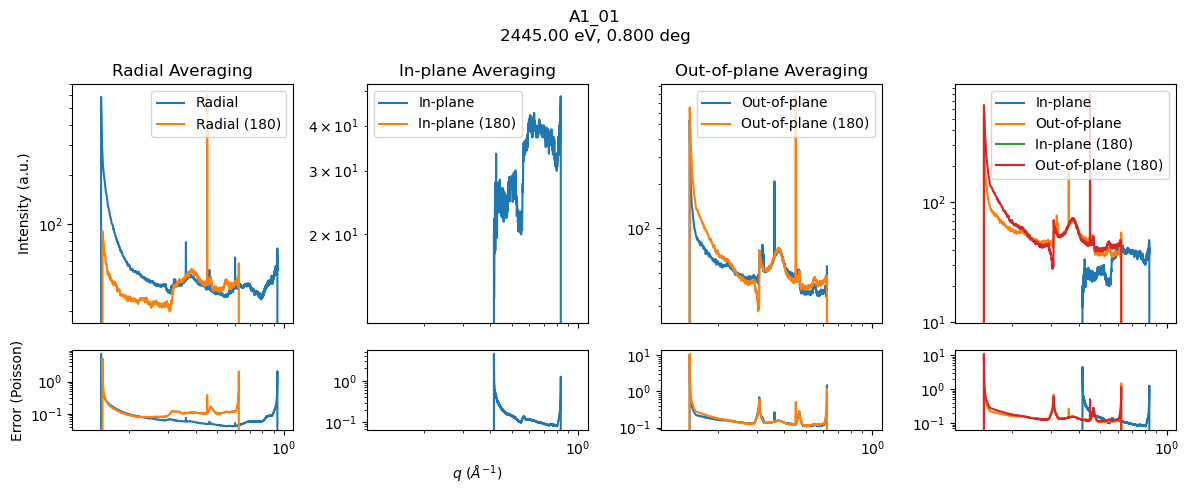

Time to plot: 0:00:00.739317


Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2540.00eV_ai0.80_wa18_bpm154.881_id892865_000000_WAXS.tif       2540.0                   0.8

Time to update geometry: 0:00:00.000003
Time to update wavelength: 0:00:00.352280
Time to open data: 0:00:00.004979
Time to apply masks: 0:00:00.010788
Time to normalise data: 0:00:00.000834
Time to stitch data: 0:00:04.627378
Time to radial average: 0:00:10.351251


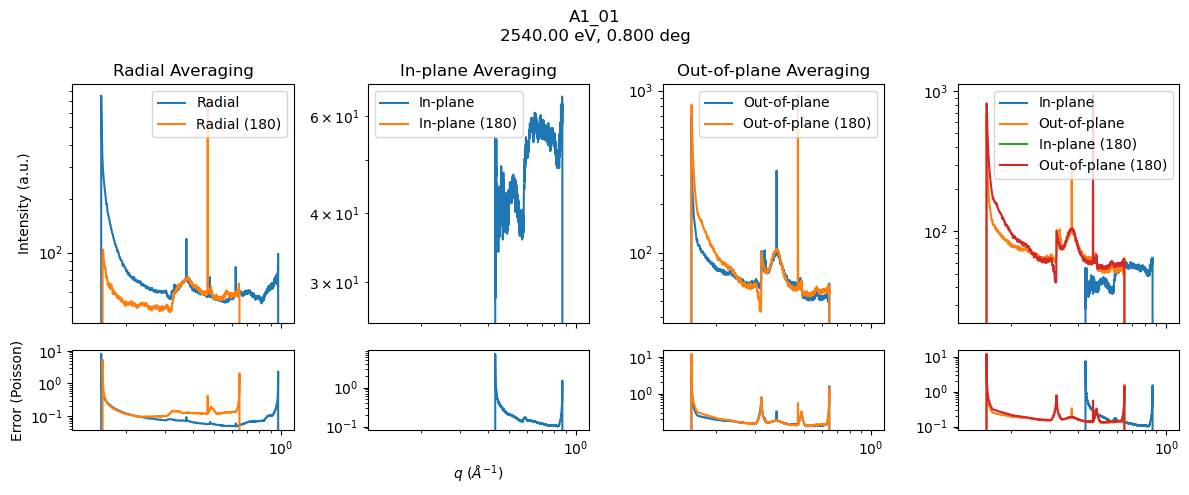

Time to plot: 0:00:00.800633


Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai4.00_wa18_bpm155.801_id892867_000000_WAXS.tif       2445.0                   4.0

Time to update geometry: 0:00:00.365234
Time to update wavelength: 0:00:00.327839
Time to open data: 0:00:00.004456
Time to apply masks: 0:00:00.010328
Time to normalise data: 0:00:00.000807
Time to stitch data: 0:00:04.610068
Time to radial average: 0:00:10.532352


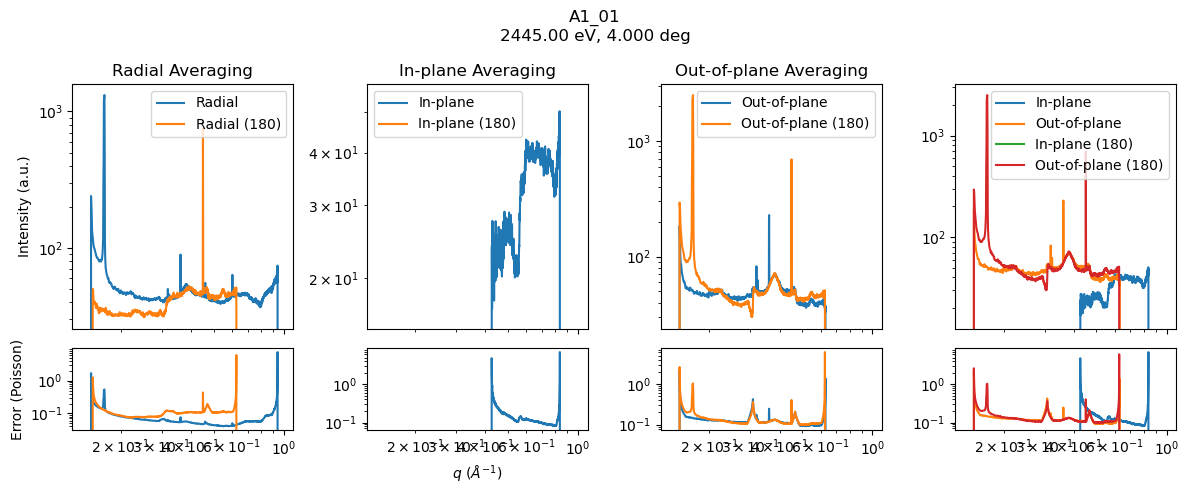

Time to plot: 0:00:00.794518


Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2540.00eV_ai4.00_wa18_bpm154.954_id892928_000000_WAXS.tif       2540.0                   4.0

Time to update geometry: 0:00:00.000004
Time to update wavelength: 0:00:00.366731
Time to open data: 0:00:00.005731
Time to apply masks: 0:00:00.011025
Time to normalise data: 0:00:00.000793
Time to stitch data: 0:00:04.810790
Time to radial average: 0:00:10.928084


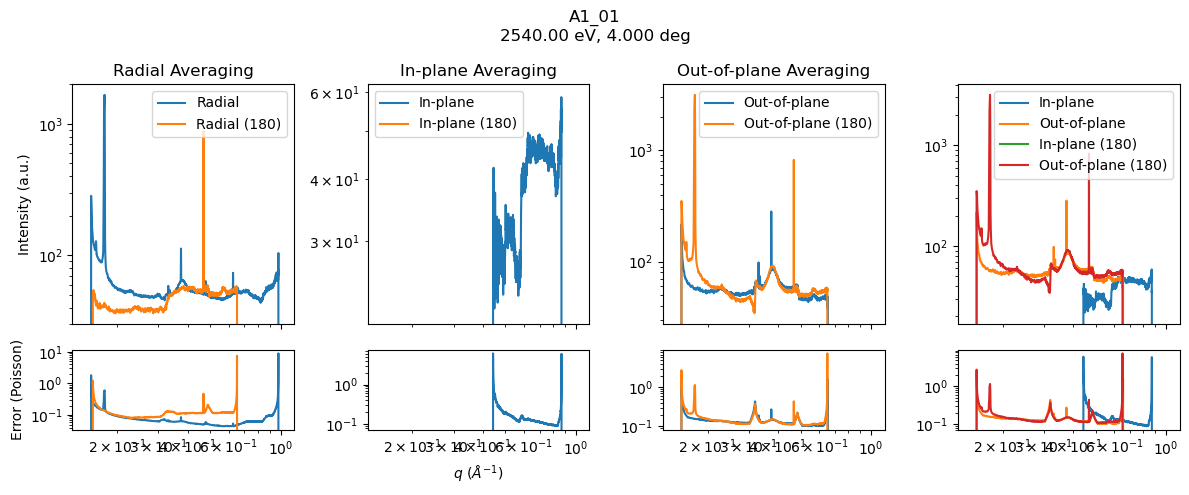

Time to plot: 0:00:00.856665


Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2445.00eV_ai8.00_wa18_bpm155.943_id892930_000000_WAXS.tif       2445.0                   8.0

Time to update geometry: 0:00:00.413435
Time to update wavelength: 0:00:00.388788
Time to open data: 0:00:00.005435
Time to apply masks: 0:00:00.011890
Time to normalise data: 0:00:00.000971
Time to stitch data: 0:00:05.230082
Time to radial average: 0:00:11.209549


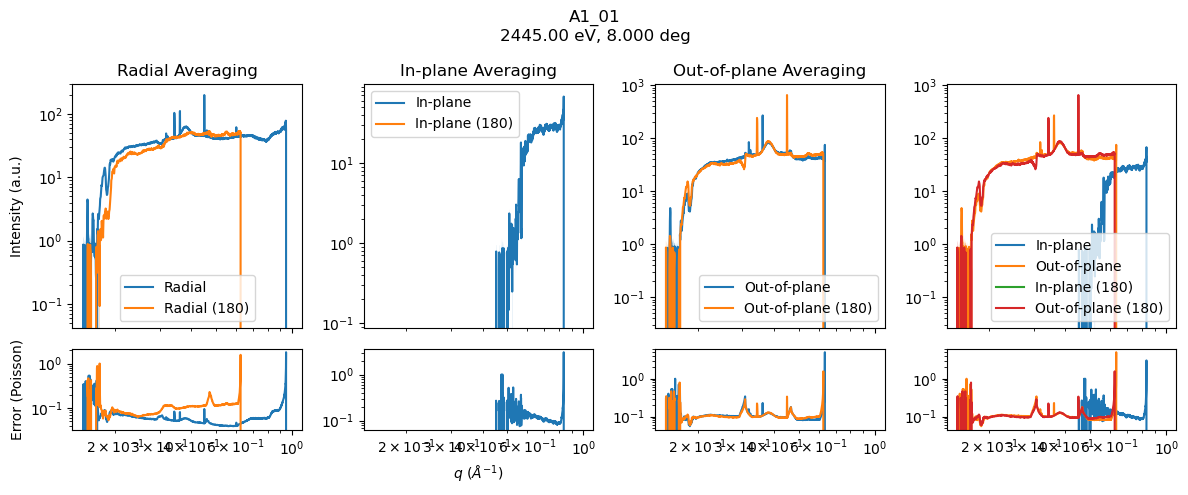

Time to plot: 0:00:00.926572


Filename  Energy (eV)  Incident Angle (deg)
0  CM_A1_01_2540.00eV_ai8.00_wa18_bpm154.965_id892991_000000_WAXS.tif       2540.0                   8.0

Time to update geometry: 0:00:00.000003
Time to update wavelength: 0:00:00.357009
Time to open data: 0:00:00.005395
Time to apply masks: 0:00:00.011341
Time to normalise data: 0:00:00.000895
Time to stitch data: 0:00:05.046198
Time to radial average: 0:00:11.164806


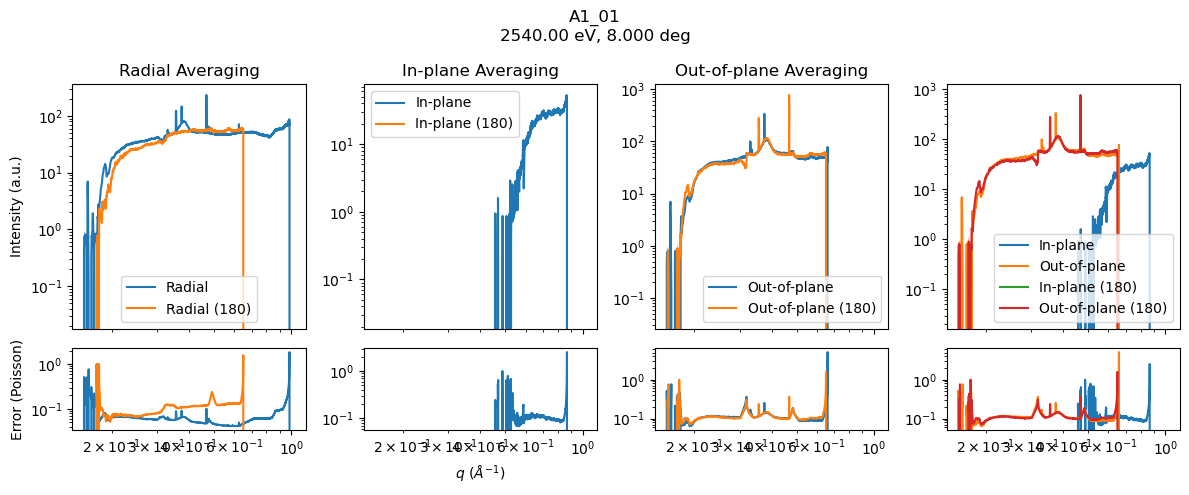

Time to plot: 0:00:00.898977


In [37]:
for i, sample in enumerate(samples):
    for j, ai in enumerate(sample_angles[i]):
        if not (i==0 or j==0):
            continue
        
        for test_file in test_files:
            # Setup a figure and open the file
            fnames = datasets[i][j][test_file]
            fname = fnames[0]
            
            # Collect the metadata
            en_idx = fname.find('eV_')
            en = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai2 = float(fname[ai_idx+3:ai_idx+7])
            assert ai==ai2
            display(pd.DataFrame([
                    (fname, en, ai)
                    ], columns=["Filename", "Energy (eV)", "Incident Angle (deg)"]))
            
            # Update the geometry
            tinit = datetime.datetime.now()
            SMI_waxs.alphai = ai
            tfin = datetime.datetime.now()
            print(f"Time to update geometry: {tfin-tinit}")
            
            tinit = datetime.datetime.now()
            SMI_waxs.wav = en2wav(en)
            tfin = datetime.datetime.now()
            print(f"Time to update wavelength: {tfin-tinit}")

            # Open and stitch the data
            tinit = datetime.datetime.now()
            SMI_waxs.open_data(RAW_DIR, fnames)
            tfin = datetime.datetime.now()
            print(f"Time to open data: {tfin-tinit}")
            
            tinit = datetime.datetime.now()
            apply_detector_mask(SMI_waxs)
            apply_flatfield(SMI_waxs, flatfield)
            tfin = datetime.datetime.now()
            print(f"Time to apply masks: {tfin-tinit}")
            
            tinit = datetime.datetime.now()
            energies_idx = flux_energies.index(en) # for normalisation
            for img in SMI_waxs.imgs:
                if ai == 4.0:
                    img[:] = (img[:] / FLUX_NORM[f"ai{8.0:0.2f}"][energies_idx]).astype(np.int32)
                else:
                    img[:] = (img[:] / FLUX_NORM[f"ai{ai:0.2f}"][energies_idx]).astype(np.int32)
            tfin = datetime.datetime.now()
            print(f"Time to normalise data: {tfin-tinit}")
                
            tinit = datetime.datetime.now()
            SMI_waxs.stitching_data(interp_factor=2, flag_scale=False, perpendicular=True)
            tfin = datetime.datetime.now()
            print(f"Time to stitch data: {tfin-tinit}")

            # Generate radial averages
            fig,ax = plt.subplots(2,4, figsize=(12,5), sharex=True, height_ratios=[3,1])
            fig.suptitle(f"{sample}\n{en:0.2f} eV, {ai:0.3f} deg")
            ax[0][0].set_xscale("log")

            tinit = datetime.datetime.now()
            # In plane and out of plane
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_IP, I0_IP, I0_IP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_OOP, I0_OOP, I0_OOP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            # Repeat IP and OOP for the consistency checking
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_IP2, I0_IP2, I0_IP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_OOP2, I0_OOP2, I0_OOP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            # Radial averaging
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[90-(AZIMUTHAL_RADIAL - RADIAL_WIDTH) , -90+(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_R, I0_R, I0_R_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

            # Repeat radial averaging for consistency checking
            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                    azimuth_range=[-90+(AZIMUTHAL_RADIAL - RADIAL_WIDTH) , -90+(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                    npt = NPOINTS_RADIAL_AVE)
            q0_R2, I0_R2, I0_R2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err
            tfin = datetime.datetime.now()
            print(f"Time to radial average: {tfin-tinit}")

            tinit = datetime.datetime.now()
            # Labels
            ax[1][1].set_xlabel("$q$ ($Å^{-1}$)")
            ax[0][0].set_ylabel("Intensity (a.u.)")
            ax[1][0].set_ylabel("Error (Poisson)")
            ax[0][0].set_title("Radial Averaging")
            ax[0][1].set_title("In-plane Averaging")
            ax[0][2].set_title("Out-of-plane Averaging")
            # Plot the radial averages
            ax[0][0].plot(q0_R, I0_R, label="Radial")
            ax[0][0].fill_between(q0_R, I0_R - I0_R_err, I0_R + I0_R_err, alpha=0.5)
            ax[0][0].plot(q0_R2, I0_R2, label="Radial (180)")
            ax[0][0].fill_between(q0_R2, I0_R2 - I0_R2_err, I0_R2 + I0_R2_err, alpha=0.5)
            # Plot the in-plane and out-of-plane averages
            ax[0][1].plot(q0_IP, I0_IP, label="In-plane")
            ax[0][1].fill_between(q0_IP, I0_IP - I0_IP_err, I0_IP + I0_IP_err, alpha=0.5)
            ax[0][1].plot(q0_IP2, I0_IP2, label="In-plane (180)")
            ax[0][1].fill_between(q0_IP2, I0_IP2 - I0_IP2_err, I0_IP2 + I0_IP2_err, alpha=0.5)
            ax[0][2].plot(q0_OOP, I0_OOP, label="Out-of-plane")
            ax[0][2].fill_between(q0_OOP, I0_OOP - I0_OOP_err, I0_OOP + I0_OOP_err, alpha=0.5)
            ax[0][2].plot(q0_OOP2, I0_OOP2, label="Out-of-plane (180)")
            ax[0][2].fill_between(q0_OOP2, I0_OOP2 - I0_OOP2_err, I0_OOP2 + I0_OOP2_err, alpha=0.5)
            # Overlap the in-plane and out-of-plane averages to check for consistency
            ax[0][3].plot(q0_IP, I0_IP, label="In-plane")
            ax[0][3].fill_between(q0_IP, I0_IP - I0_IP_err, I0_IP + I0_IP_err, alpha=0.5)
            ax[0][3].plot(q0_OOP, I0_OOP, label="Out-of-plane")
            ax[0][3].fill_between(q0_OOP, I0_OOP - I0_OOP_err, I0_OOP + I0_OOP_err, alpha=0.5)
            ax[0][3].plot(q0_IP2, I0_IP2, label="In-plane (180)")
            ax[0][3].fill_between(q0_IP2, I0_IP2 - I0_IP2_err, I0_IP2 + I0_IP2_err, alpha=0.5)
            ax[0][3].plot(q0_OOP2, I0_OOP2, label="Out-of-plane (180)")
            ax[0][3].fill_between(q0_OOP2, I0_OOP2 - I0_OOP2_err, I0_OOP2 + I0_OOP2_err, alpha=0.5)

            # Plot the errors
            ax[1][0].plot(q0_R, I0_R_err, label="Radial")
            ax[1][0].plot(q0_R2, I0_R2_err, label="Radial (180)")
            ax[1][1].plot(q0_IP, I0_IP_err, label="In-plane")
            ax[1][1].plot(q0_IP2, I0_IP2_err, label="In-plane (180)")
            ax[1][2].plot(q0_OOP, I0_OOP_err, label="Out-of-plane")
            ax[1][2].plot(q0_OOP2, I0_OOP2_err, label="Out-of-plane (180)")
            ax[1][3].plot(q0_IP, I0_IP_err, label="In-plane")
            ax[1][3].plot(q0_OOP, I0_OOP_err, label="Out-of-plane")
            ax[1][3].plot(q0_IP2, I0_IP2_err, label="In-plane (180)")
            ax[1][3].plot(q0_OOP2, I0_OOP2_err, label="Out-of-plane (180)")

            for a in ax[0]:
                a.legend()
            for a in ax.flatten():
                a.set_yscale("log")
            fig.tight_layout()
            plt.show()
            tfin = datetime.datetime.now()
            print(f"Time to plot: {tfin-tinit}")
            # plt.close()

##### If happy with line profiles above, then generate the line profiles for test_data.

In [39]:
OVERRIDE: bool = True
"""Whether to override the analysis reduction or not."""
if not os.path.isdir(RESULT_DIR):
    os.mkdir(RESULT_DIR)
with tqdm.notebook.tqdm(total=len(samples), position=2, leave=True, desc="Samples") as pbar:
    for i, sample in enumerate(samples):
        with tqdm.notebook.tqdm(total=len(sample_angles[i]), position=1, leave=False, desc="Angles") as pbar1:
            for j, ai in enumerate(sample_angles[i]):
                # For each file in the sample
                with tqdm.notebook.tqdm(total=len(test_files), position=0, leave=False, desc="Files") as pbar2:
                    for test_file in test_files:
                        ## Create the results directory for the sample
                        sample_dir = os.path.join(RESULT_DIR, sample)
                        if not os.path.isdir(sample_dir):
                            os.mkdir(sample_dir)
                            
                        ## Create the directories for the images and line profiles
                        giwaxs_img_dir = os.path.join(sample_dir, "giwaxs_flatfielded_images")
                        if not os.path.isdir(giwaxs_img_dir):
                            os.mkdir(giwaxs_img_dir)
                        line_profiles_dir = os.path.join(sample_dir, "line_profiles")
                        if not os.path.isdir(line_profiles_dir):
                            os.mkdir(line_profiles_dir)
                    
                    
                        for k, fnames in enumerate(datasets[i][j][test_file:test_file+1]):
                            fname = fnames[0]
                            # Collect the metadata
                            en_idx = fname.find('eV_')
                            en = float(fname[en_idx-7:en_idx])
                            ai_idx = fname.find("_ai")
                            ai2 = float(fname[ai_idx+3:ai_idx+7])
                            assert ai==ai2
                            
                            # Generate paths for the output files
                            path_det_img = os.path.join(giwaxs_img_dir, f"{sample}_giwaxs_{ai:0.3f}deg_{en:0.2f}eV.png")
                            path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_OOP.txt")
                            path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_IP.txt")
                            path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt")
                            path_det_line_profiles_img = os.path.join(sample_dir, f"{sample}_line_profile_angles_test.png")
                            
                            # Do not override the files if they "all" exist already. Override partial file sets though.
                            if (not OVERRIDE 
                                and os.path.isfile(path_det_img) 
                                and os.path.isfile(path_OOP) 
                                and os.path.isfile(path_IP) 
                                and os.path.isfile(path_R)
                                and (k != 0 or os.path.isfile(path_det_line_profiles_img))):
                                pbar.total -= 1
                                continue
                            
                            # Update the geometry
                            SMI_waxs.alphai = ai
                            SMI_waxs.wav = en2wav(en)
                            
                            # Plot the flatfield / masked normalized data
                            SMI_waxs.open_data(RAW_DIR, fnames)
                            apply_detector_mask(SMI_waxs)
                            apply_flatfield(SMI_waxs, flatfield)
                            energies_idx = flux_energies.index(en) # for normalisation
                            for img in SMI_waxs.imgs:
                                 pass
                                # img[:] = (img[:] / FLUX_NORM[f"ai{ai:0.2f}"][energies_idx]).astype(np.int32)
                            SMI_waxs.stitching_data(interp_factor=2, flag_scale=False, perpendicular=True)
                            
                            # Setup a figure and open the file
                            fig,ax = plt.subplots(1,1, figsize=(7, 10), dpi=300)
                            mp = ax.imshow(SMI_waxs.img_st,
                                    extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]],
                                    vmin=np.percentile(SMI_waxs.img_st, 1.0), 
                                    vmax=np.percentile(SMI_waxs.img_st, 99.0) # Avoid extremities
                            )
                            plt.colorbar(mp)
                            ax.set_title(f"{sample}\n{en} eV - {ai} deg")
                            # Don't save the image, as we use a different display format later.
                            # fig.savefig(path_det_img)
                            
                            if k==0:
                                # Plot the azimuthal and radial angles
                                colors = ['r', 'orange', 'white'][::-1]
                                for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
                                    # Generate a set of x points to plot lines of.
                                    q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
                                    # Calculate the x and y gradients for the lines
                                    m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
                                    m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
                                    # Calculate the x & y values for the lines
                                    q_x1 = q_x if m1 != np.inf else np.zeros(100)
                                    q_x2 = q_x if m2 != np.inf else np.zeros(100)
                                    y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                                    y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                                    # Plot the lines
                                    color = colors.pop()
                                    ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
                                    ax.plot(q_x2, y2, color=color, linestyle='-')
                                    # If gradient is inf, calculate an alternative fill between
                                    if m2 == np.inf:
                                            ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
                                    else:
                                            ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
                                ax.set_xlim(*SMI_waxs.qp)
                                ax.set_ylim(*SMI_waxs.qz)
                                ax.legend()
                                fig.savefig(path_det_line_profiles_img, dpi=300)
                            plt.close() # Save memory
                            
                            # Perform the radial/azimuthal averaging
                            # In plane and out of plane
                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_IP, I0_IP, I0_IP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_OOP, I0_OOP, I0_OOP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            # Repeat IP and OOP for the consistency checking
                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_IP2, I0_IP2, I0_IP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_OOP2, I0_OOP2, I0_OOP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            # Radial averaging
                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[90-(AZIMUTHAL_RADIAL - RADIAL_WIDTH), 90-(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_R, I0_R, I0_R_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                            # Repeat radial averaging for consistency checking
                            SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                    azimuth_range=[-90+(AZIMUTHAL_RADIAL - RADIAL_WIDTH), -90+(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                                    npt = NPOINTS_RADIAL_AVE)
                            q0_R2, I0_R2, I0_R2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err
                            
                            # Save the line profiles 
                            header = ("Main Data\t\tMirror-Y axis Data\t\n" 
                                    + "q (Å^-1)\tI (a.u.)\tI_err (a.u.)\tq (Å^-1)\tI (a.u.)\tI_err (a.u.)\n")
                            delim = "\t"
                            kwargs = {"header": header, "delimiter": delim}
                            np.savetxt(path_OOP, np.array([q0_OOP, I0_OOP, I0_OOP_err, q0_OOP2, I0_OOP2, I0_OOP2_err]).T, **kwargs)
                            np.savetxt(path_IP, np.array([q0_IP, I0_IP, I0_IP_err, q0_IP2, I0_IP2, I0_IP2_err]).T, **kwargs)
                            np.savetxt(path_R, np.array([q0_R, I0_R, I0_R_err, q0_R2, I0_R2, I0_R2_err]).T, **kwargs)
                            
                            # Update the progress bars
                            pbar2.update(1)
                pbar1.update(1)
        pbar.update(1)

Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Angles:   0%|          | 0/4 [00:00<?, ?it/s]

Files:   0%|          | 0/2 [00:00<?, ?it/s]

Files:   0%|          | 0/2 [00:00<?, ?it/s]

Files:   0%|          | 0/2 [00:00<?, ?it/s]

Files:   0%|          | 0/2 [00:00<?, ?it/s]


##### Using example data, define regions for fluorescence collection in the radial scan


FileNotFoundError: //nsls2/data/smi/legacy/results/analysis/2025_1/316022_McNeill_03/energy_scan_results/A1_02/line_profiles/A1_02_line_profile_4.000deg_2540.00eV_R.txt not found.

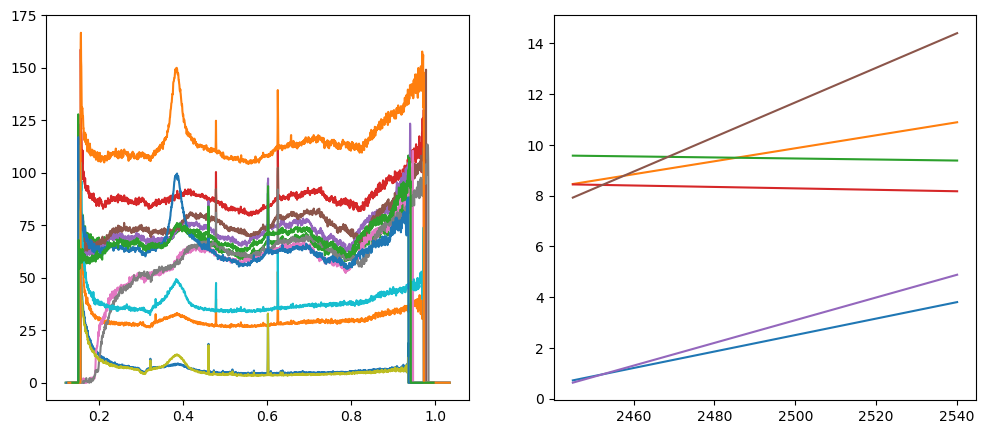

In [121]:
FLUOR_RANGE: tuple[float, float] = (0.8, 0.92)
"""Q-range for the fluorescence signal summation; define in a flat region away from any peaks/features!"""

# Plot the example data, and plot the fluorescence signal
fig: plt.Figure
ax: list[plt.Axes]
fig,ax = plt.subplots(1,2, figsize=(12,5))
for i, sample in enumerate(samples):
    sample_dir = os.path.join(RESULT_DIR, sample)
    line_profiles_dir = os.path.join(sample_dir, "line_profiles")
    for j, ai in enumerate(sample_angles[i]):
        test_dataset = [datasets[i][j][test_file] for test_file in test_files]
        # Gather the fluor data
        fluor_data = np.zeros((len(test_dataset), 3)) # en, I, I_err
        for k, fnames in enumerate(test_dataset):
            ## Create the results directory for the sample
            fname = fnames[0]
            # Collect the metadata
            en_idx = fname.find('eV_')
            en = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai = float(fname[ai_idx+3:ai_idx+7])
            # Generate paths for the output files
            path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt")

            # Load the data
            data = np.loadtxt(path_R, skiprows=3, delimiter="\t")
            q = data[:,0]
            I = data[:,1]
            I_err = data[:,2]
            
            # Find the fluorescence signal
            mask = (q > FLUOR_RANGE[0]) & (q < FLUOR_RANGE[1])
            fluor_data[k, 0] = en
            fluor_data[k, 1] = np.trapz(I[mask], q[mask])
            fluor_data[k, 2] = np.trapz(I_err[mask], q[mask])
            
            # Plot the data
            ax[0].plot(q, I, label=f"{en} eV, {ai} deg")
            
        ax[1].plot(fluor_data[:,0], fluor_data[:,1], label=f"{sample} {ai}")
        ax[1].fill_between(fluor_data[:,0], fluor_data[:,1] - fluor_data[:,2], fluor_data[:,1] + fluor_data[:,2], alpha=0.5)
    
# ax[0].axvspan(*FLUOR_RANGE, color="gray", alpha=0.5)
ax[0].set_xlabel("q (Å$^{-1}$)")
ax[0].set_ylabel("Intensity (a.u.)")
ax[0].set_title("Radial Averaging")
ax[0].set_yscale("log")
# ax[0].legend()
ax[1].set_xlabel("Energy (eV)")
ax[1].set_ylabel("Fluorescence Signal (a.u.)")
ax[1].legend()


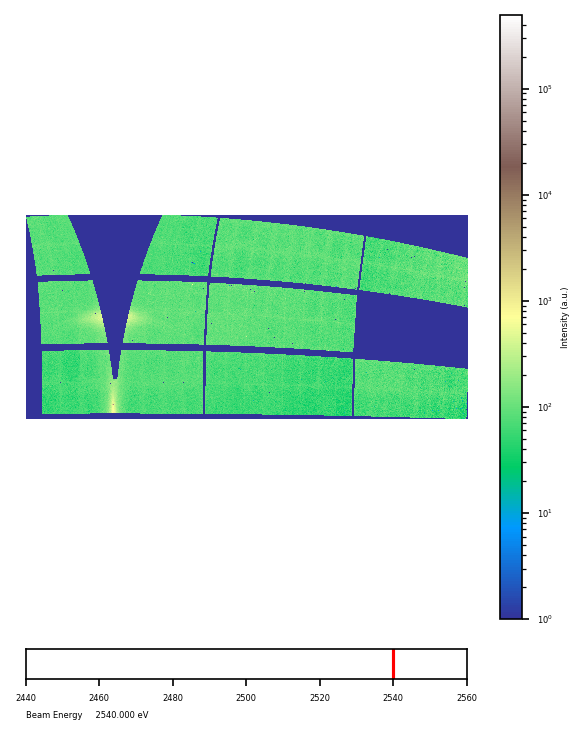

In [122]:
MIN_E: float = 2440.0
MAX_E: float = 2560.0

def generate_energy_video_figure(geom: SMI_beamline.SMI_geometry, 
                              dataset_minimum:float, 
                              dataset_maximum: float, 
                              en: float) -> plt.Figure:
    SMI_waxs = geom
    if len(SMI_waxs.imgs) == 3:
        # Works for single detector plots
        figsize = (4,5) 
    else:
        # Works for 0, 20  deg detector angles... generic?
        qp = SMI_waxs.qp
        qz = SMI_waxs.qz
        qp_diff = qp[0] - qp[1]
        qz_diff = qz[0] - qz[1]
        qmax = np.max([qp_diff, qz_diff])
        scale = 4
        figsize = (qp_diff/qmax * scale * 1.02, qz_diff/qmax * scale)
    
    fig = plt.figure(figsize = figsize, dpi=150)
    gs = fig.add_gridspec(2,2, width_ratios=[1,0.05], height_ratios=[1, 0.05])
    ax = fig.add_subplot(gs[0,0])
    ax_cmap = fig.add_subplot(gs[0,1])
    ax_ai = fig.add_subplot(gs[1,0])

    cmap = plt.get_cmap('terrain')
    norm = mplc.LogNorm(vmin=dataset_minimum, vmax=dataset_maximum, clip=True)
    mp = ax.matshow(SMI_waxs.img_st,
            extent=[SMI_waxs.qp[0], SMI_waxs.qp[-1], SMI_waxs.qz[0], SMI_waxs.qz[-1]],
            cmap = cmap,
            norm=norm
    )
    colorbar = fig.colorbar(mp, cax=ax_cmap, orientation='vertical', location="right", fraction = 0.05)
    colorbar.ax.set_ylabel("Intensity (a.u.)", fontsize=4)
    colorbar.ax.tick_params(axis='both', which='major', labelsize=4)
    ax.axis('off')

    ax2 = ax_ai
    ax2.yaxis.set_ticks([])
    ax2.set_ylim(0,1)
    ax2.set_xscale("linear")
    ax2.set_xlim(MIN_E, MAX_E)
    ax2.tick_params(axis='both', which='major', labelsize=4)
    ax2.plot([en, en], [0, 1], 'r')
    ax2.set_xlabel(f"Beam Energy     {en:0.3f} eV", loc="left", fontsize=4)

    fig.tight_layout()
    return fig

if "dataset_minimum" in locals():
    plt.ion()
    matplotlib.interactive(True)
    
    SMI_waxs.open_data(RAW_DIR, fnames)
    apply_detector_mask(SMI_waxs)
    apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
    energies_idx = flux_energies.index(en) # for normalisation
    for img in SMI_waxs.imgs:
        img[:] = (img[:] / FLUX_NORM[f"ai{ai:0.2f}"][energies_idx]).astype(np.int32)
    SMI_waxs.stitching_data(interp_factor=3, flag_scale=False, perpendicular=True)
    
    fig = generate_energy_video_figure(SMI_waxs, 1, dataset_maximum, en)


##### Reduce the lineprofiles and generate fluorescence profiles

In [125]:
OVERRIDE: bool = False
"""Whether to override the analysis reduction or not."""

STITCH_MINMAX: bool = False
"""Whether to stitch the data to find the minimum and maximum values for the dataset, 
otherwise just use raw values from 2D detector array using fabio."""

# Check the timing performance
timing:bool = False
import datetime
tcheck = datetime.datetime.now()

# Run the script
plt.ioff()
plt.close('all')
matplotlib.interactive(False)
with tqdm.notebook.tqdm(total=len(samples), position=0, leave=True, desc="All Samples") as pbar:
    for i, sample in enumerate(samples):
        ## Create the results directory for the sample
        sample_dir = os.path.join(RESULT_DIR, sample)
        if not os.path.isdir(sample_dir):
            os.mkdir(sample_dir)
            
        ## Create the directories for the images and line profiles
        giwaxs_img_dir = os.path.join(sample_dir, "giwaxs_flatfielded_images")
        if not os.path.isdir(giwaxs_img_dir):
            os.mkdir(giwaxs_img_dir)
        line_profiles_dir = os.path.join(sample_dir, "line_profiles")
        if not os.path.isdir(line_profiles_dir):
            os.mkdir(line_profiles_dir)
            
        with tqdm.notebook.tqdm(total=len(sample_angles[i]), position=1, leave=False, desc="Angles") as pbar1:
            for j, ai in enumerate(sample_angles[i]):
                # Check if dataset is already processed
                processed = True
                if OVERRIDE:
                    processed = False
                else:
                    for k, fnames in enumerate(datasets[i][j]):
                        fname = fnames[0]
                        # Collect the metadata
                        en_idx = fname.find('eV_')
                        en = float(fname[en_idx-7:en_idx])
                        ai_idx = fname.find("_ai")
                        ai2 = float(fname[ai_idx+3:ai_idx+7])
                        assert ai == ai2
                        
                        # Generate paths for the output files
                        path_det_img = os.path.join(giwaxs_img_dir, f"{sample}_giwaxs_{ai:0.3f}deg_{en:0.2f}eV.png")
                        path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_O{en:0.2f}eV_OP.txt")
                        path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_IP.txt")
                        path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt")
                        path_det_line_profiles_img = os.path.join(sample_dir, f"{sample}_{ai}deg_line_profile_angles.png")
                        
                        if not all([os.path.isfile(path) for path in [path_det_img, path_OOP, path_IP, path_R, path_det_line_profiles_img]]):
                            processed = False
                            break
                        
                if processed:
                    print(f"Skipping processed dataset for sample {sample} at {en} energy.")
                    pbar1.total -= 1
                    pbar1.update(0)
                    continue

                dataset_maximum = None
                dataset_minimum = None
                with tqdm.notebook.tqdm(total=len(datasets[i][j]), position=2, leave=False, desc="Finding dataset maximum / minimum") as pbar2:
                    for k, fnames in enumerate(datasets[i][j]):
                        fname = fnames[0]
                        # Collect the metadata
                        en_idx = fname.find('eV_')
                        en = float(fname[en_idx-7:en_idx])
                        ai_idx = fname.find("_ai")
                        ai2 = float(fname[ai_idx+3:ai_idx+7])
                        assert ai==ai2
                        if STITCH_MINMAX:
                        
                            # Update the geometry
                            if timing:
                                tcheck = datetime.datetime.now()
                                SMI_waxs.alphai = ai
                                tupdate = datetime.datetime.now()
                                print(f"Time to update geometry: {tupdate - tcheck}")
                                        
                                
                                tcheck = datetime.datetime.now()
                                SMI_waxs.wav = en2wav(en)
                                tupdate = datetime.datetime.now()
                                print(f"Time to update wavelength: {tupdate - tcheck}")
                                
                                # Flatfield / masked normalized data
                                tcheck = datetime.datetime.now()
                                SMI_waxs.open_data(RAW_DIR, fnames)
                                tupdate = datetime.datetime.now()
                                print(f"Time to open data: {tupdate - tcheck}")
                                
                                tcheck = datetime.datetime.now()
                                apply_detector_mask(SMI_waxs)
                                apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
                                tupdate = datetime.datetime.now()
                                print(f"Time to apply flatfield and mask: {tupdate - tcheck}")
                                
                                energies_idx = global_energies.tolist().index(en) # for normalisation
                                for img in SMI_waxs.imgs:
                                    # img[:] = (img[:] / FLUX_NORM[energies_idx]).astype(np.int32)
                                    pass
                                    
                                tcheck = datetime.datetime.now()
                                SMI_waxs.stitching_data(interp_factor=3, flag_scale=False, timing=True, perpendicular=True)
                                tupdate = datetime.datetime.now()
                                print(f"Time to stitch data: {tupdate - tcheck}")
                            
                            else:
                                # Unnecessary to set the correct geometry and wavelength for each image when finding min/max
                                # SMI_waxs.alphai = ai
                                # SMI_waxs.wav = en2wav(en)
                                SMI_waxs.open_data(RAW_DIR, fnames)
                                apply_detector_mask(SMI_waxs)
                                apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
                                
                                energies_idx = global_energies.tolist().index(en) # for normalisation
                                for img in SMI_waxs.imgs:
                                    # img[:] = (img[:] / FLUX_NORM[energies_idx]).astype(np.int32)
                                    pass
                                SMI_waxs.stitching_data(interp_factor=3, flag_scale=False, perpendicular=True)
                                
                            # Collect the maximum and minimum values
                            if dataset_maximum is None:
                                dataset_maximum = np.max(SMI_waxs.img_st)
                            else:
                                dataset_maximum = np.max([dataset_maximum, np.max(SMI_waxs.img_st)])
                                
                            if dataset_minimum is None:
                                dataset_minimum = np.min(SMI_waxs.img_st[SMI_waxs.img_st > 0])
                            else:
                                min_val = np.min(SMI_waxs.img_st[SMI_waxs.img_st > 0])
                                dataset_minimum = np.min([dataset_minimum, min_val])
                        else:
                            # Open the file using pyFAI
                            for file in fnames:
                                raw_img = fabio.open(os.path.join(RAW_DIR, file)).data
                                if dataset_maximum is None:
                                    dataset_maximum = np.max(raw_img)
                                else:
                                    dataset_maximum = np.max([dataset_maximum, np.max(raw_img)])
                                if dataset_minimum is None:
                                    dataset_minimum = np.min(raw_img[raw_img > 0])
                                else:
                                    min_val = np.min(raw_img[raw_img > 0])
                                    dataset_minimum = np.min([dataset_minimum, min_val])
                        pbar2.update(1)
                
                cmap = plt.get_cmap('viridis')
                norm = mplc.LogNorm(vmin=dataset_minimum, vmax=dataset_maximum)
                
                
                # Gather the fluor data
                fluor_data = np.zeros((len(datasets[i][j]), 3))
                
                # Create paths for fluor figure and data
                path_flour_fig = os.path.join(sample_dir, f"{sample}_{ai}_fluorescence.png")
                path_flour_data = os.path.join(sample_dir, f"{sample}_{ai}_fluorescence_data.txt")
                
                with tqdm.notebook.tqdm(total=len(datasets[i][j]), position=1, leave=False, desc="Sample dataset") as pbar2:
                    # For each file in the sample
                    for k, fnames in enumerate(datasets[i][j]):
                        fname = fnames[0]
                        # Collect the metadata
                        en_idx = fname.find('eV_')
                        en = float(fname[en_idx-7:en_idx])
                        ai_idx = fname.find("_ai")
                        ai2 = float(fname[ai_idx+3:ai_idx+7])
                        assert ai2 == ai
                        
                        # Generate paths for the output files
                        path_det_img = os.path.join(giwaxs_img_dir, f"{sample}_giwaxs_{ai:0.3f}deg_{en:0.2f}eV.png")
                        path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_OOP.txt")
                        path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_IP.txt")
                        path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt")
                        path_det_line_profiles_img = os.path.join(sample_dir, f"{sample}_{ai}deg_line_profile_angles.png")
                        
                        # Do not override the files if they "all" exist already. Override partial file sets though.
                        if (not OVERRIDE 
                            and os.path.isfile(path_det_img) 
                            and os.path.isfile(path_OOP) 
                            and os.path.isfile(path_IP) 
                            and os.path.isfile(path_R)
                            and os.path.isfile(path_flour_fig)
                            and os.path.isfile(path_flour_data)
                            and (k != 0 or os.path.isfile(path_det_line_profiles_img))):
                            pbar2.total -= 1 # Reduce the total count
                            continue
                        
                        # Update the geometry
                        SMI_waxs.alphai = ai
                        SMI_waxs.wav = en2wav(en)
                        
                        # flatfield / masked normalized data
                        SMI_waxs.open_data(RAW_DIR, fnames)
                        apply_detector_mask(SMI_waxs)
                        apply_flatfield(SMI_waxs, flatfield, flat_percentile=FLATFIELD_PERCENTILE, img_percentile=SAMPLE_PERCENTILE)
                        energies_idx = flux_energies.index(en) # for normalisation
                        for img in SMI_waxs.imgs:
                            # img[:] = (img[:] / FLUX_NORM[f"ai{ai:0.2f}"][energies_idx]).astype(np.int32)
                            pass
                        SMI_waxs.stitching_data(interp_factor=2, flag_scale=True, timing= True, perpendicular=True)
                        
                        # Setup a figure and open the file
                        fig = generate_energy_video_figure(SMI_waxs, 1, dataset_maximum, en)
                        fig.savefig(path_det_img)
                        ax = fig.get_axes()[0]
                        
                        if k==0:
                            # Plot the azimuthal and radial angles
                            colors = ['r', 'orange', 'white'][::-1]
                            for angle, width in zip([AZIMUTHAL_INPLANE, AZIMUTHAL_OUTOFPLANE, AZIMUTHAL_RADIAL], [AZIMUTHAL_WIDTH, AZIMUTHAL_WIDTH, RADIAL_WIDTH]):
                                # Generate a set of x points to plot lines of.
                                q_x = np.linspace(0, SMI_waxs.qp[-1], 100)
                                # Calculate the x and y gradients for the lines
                                m1 = np.tan(np.deg2rad(angle - width)) if angle - width != 90 else np.inf
                                m2 = np.tan(np.deg2rad(angle + width)) if angle + width != 90 else np.inf
                                # Calculate the x & y values for the lines
                                q_x1 = q_x if m1 != np.inf else np.zeros(100)
                                q_x2 = q_x if m2 != np.inf else np.zeros(100)
                                y1 = m1 * q_x if m1 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                                y2 = m2 * q_x if m2 != np.inf else np.linspace(0, SMI_waxs.qz[-1], 100)
                                # Plot the lines
                                color = colors.pop()
                                ax.plot(q_x1, y1, color=color, linestyle='-', label=f"{angle} deg")
                                ax.plot(q_x2, y2, color=color, linestyle='-')
                                # If gradient is inf, calculate an alternative fill between
                                if m2 == np.inf:
                                        ax.fill_betweenx(y1, q_x1, q_x2, color=color, alpha=0.1)
                                else:
                                        ax.fill_between(q_x, y1, y2, color=color, alpha=0.1)
                            ax.set_xlim(*SMI_waxs.qp)
                            ax.set_ylim(*SMI_waxs.qz)
                            ax.legend()
                            fig.savefig(path_det_line_profiles_img, dpi=300)
                        plt.close(fig) # Save memory
                        
                        # Perform the radial/azimuthal averaging
                        # In plane and out of plane
                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[90 - (AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH) , 90 - (AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_IP, I0_IP, I0_IP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[90 - (AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH), 90 - (AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_OOP, I0_OOP, I0_OOP_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        # Repeat IP and OOP for the consistency checking
                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[-90+(AZIMUTHAL_INPLANE - AZIMUTHAL_WIDTH), -90+(AZIMUTHAL_INPLANE + AZIMUTHAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_IP2, I0_IP2, I0_IP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[-90+(AZIMUTHAL_OUTOFPLANE - AZIMUTHAL_WIDTH) , -90+(AZIMUTHAL_OUTOFPLANE + AZIMUTHAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_OOP2, I0_OOP2, I0_OOP2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        # Radial averaging
                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[90-(AZIMUTHAL_RADIAL - RADIAL_WIDTH), 90-(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_R, I0_R, I0_R_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err

                        # Repeat radial averaging for consistency checking
                        SMI_waxs.radial_averaging(radial_range = [0, 8], 
                                                azimuth_range=[-90+(AZIMUTHAL_RADIAL - RADIAL_WIDTH), -90+(AZIMUTHAL_RADIAL + RADIAL_WIDTH)], 
                                                npt = NPOINTS_RADIAL_AVE)
                        q0_R2, I0_R2, I0_R2_err = SMI_waxs.q_rad, SMI_waxs.I_rad, SMI_waxs.I_rad_err
                        
                        # Save the line profiles 
                        header = ("Main Data\t\tMirror-Y axis Data\t\n" 
                                + "q (Å^-1)\tI (a.u.)\tI_err (a.u.)\tq (Å^-1)\tI (a.u.)\tI_err (a.u.)\n")
                        delim = "\t"
                        kwargs = {"header": header, "delimiter": delim}
                        np.savetxt(path_OOP, np.array([q0_OOP, I0_OOP, I0_OOP_err, q0_OOP2, I0_OOP2, I0_OOP2_err]).T, **kwargs)
                        np.savetxt(path_IP, np.array([q0_IP, I0_IP, I0_IP_err, q0_IP2, I0_IP2, I0_IP2_err]).T, **kwargs)
                        np.savetxt(path_R, np.array([q0_R, I0_R, I0_R_err, q0_R2, I0_R2, I0_R2_err]).T, **kwargs)
                        
                        # Calculate the Fluorescence data
                        mask = (q0_R > FLUOR_RANGE[0]) & (q0_R < FLUOR_RANGE[1])
                        fluor_data[k, 0] = en
                        fluor_data[k, 1] = np.trapz(I0_R[mask], q0_R[mask])
                        fluor_data[k, 2] = np.trapz(I0_R_err[mask], q0_R[mask])
                        
                        
                        pbar2.update(1)
                        plt.close("all")
                        # break # Only do the first file for now.
                
                # Save and plot the Fluroescence data
                idx = np.argsort(fluor_data[:,0]) #sort by energy
                fluor_data = fluor_data[idx]
                if not os.path.isfile(path_flour_data) or OVERRIDE:
                    with open(path_flour_data, "w") as f:
                        f.write("Energy (eV)\tFluorescence (a.u.)\tFluorescence Error (a.u.)\n")
                        np.savetxt(f, fluor_data, delimiter="\t")
                
                if not os.path.isfile(path_flour_fig) or OVERRIDE:
                    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
                    ax.plot(fluor_data[:,0], fluor_data[:,1], label="Fluorescence")
                    ax.fill_between(fluor_data[:,0], fluor_data[:,1] - fluor_data[:,2], fluor_data[:,1] + fluor_data[:,2], alpha=0.5)
                    ax.set_xlabel("Energy (eV)")
                    ax.set_ylabel("Fluorescence (a.u.)")
                    ax.set_title(f"{sample} Fluorescence")
                    fig.tight_layout()
                    fig.savefig(path_flour_fig)
                    plt.close(fig)
                pbar1.update(1)
        pbar.update(1)

All Samples:   0%|          | 0/2 [00:00<?, ?it/s]

Angles:   0%|          | 0/4 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/63 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/63 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/63 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/63 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/63 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/63 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/63 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/63 [00:00<?, ?it/s]

Angles:   0%|          | 0/4 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/7 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/7 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/7 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/7 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/7 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/7 [00:00<?, ?it/s]

Finding dataset maximum / minimum:   0%|          | 0/7 [00:00<?, ?it/s]

Sample dataset:   0%|          | 0/7 [00:00<?, ?it/s]

##### Render a video

In [ ]:
OVERRIDE: bool = True
"""Whether to override the analysis reduction or not."""

import subprocess
with tqdm.notebook.tqdm(total=len(samples), position=0, leave=True, desc="All Samples") as pbar:
    for i, sample in enumerate(samples):
        ## REQUIRES GLOB SUPPORT BY LIBAVFILTER, NOT INCLUDED IN BUILD BINARIES AVAILALBLE ONLINE.
        # img_path_regex = os.path.normpath(os.path.join(giwaxs_img_dir, f"*.png"))
        # ffmpeg_cmd = f'ffmpeg -framerate 30 -pattern_type glob -i "{img_path_regex}" -c:v libx264 -pix_fmt yuv420p "{vid_path_output}"'
        
        ## Results directory for the sample
        sample_dir = os.path.join(RESULT_DIR, sample)    
        ## Images directory
        giwaxs_img_dir = os.path.join(sample_dir, "giwaxs_flatfielded_images")
        img_list = os.listdir(giwaxs_img_dir)
        
        ai_set = set()
        for img in img_list:
            if not ".png" in img:
                continue
            ai_idx = img.find("deg_")
            ai = img[ai_idx-5:ai_idx]
            if ai in ai_set:
                continue
            ai_set.add(ai)
        
        with tqdm.notebook.tqdm(total=len(ai_set), position=1, leave=False, desc="Angles") as pbar2:
            for ai in ai_set:
                path_img_list =  os.path.normpath(os.path.join(giwaxs_img_dir, f"img_list_ai{ai}.txt"))
                with open(path_img_list, 'w') as f:
                    for img in img_list:
                        if not ".png" in img or not f"{ai}deg" in img:
                            continue
                        # f.write(f"file '{os.path.normpath(os.path.join(giwaxs_img_dir,img))}' duration 0.033333\n")
                        f.write(f"file '{img}'\noutpoint 0.1\n")
                vid_path_output = os.path.normpath(os.path.join(sample_dir, f"{sample}_ai{ai}_beam_energy_scan.mp4"))
                
                ## Check if path exists
                if os.path.exists(vid_path_output) and not OVERRIDE:
                    print("Video already exists, skipping...")
                    pbar.update(1)
                else:
                    if os.path.exists(vid_path_output):
                        os.remove(vid_path_output)
                    ## Video generation
                    ffmpeg_cmd = ['ffmpeg', 
                                '-f', 'concat',
                                #   '-safe', '0'
                                '-i', '"' + path_img_list.replace("\\", "/")  + '"',
                                '-framerate', '30',
                                '-c:v', 'libx264',
                                '-shortest',
                                '-r', '30',
                                '-pix_fmt', 'yuv420p',
                                '-vf', '"pad=ceil(iw/2)*2:ceil(ih/2)*2"',
                                #   '-movflags', 'faststart',
                                #   '-vf', 'format=yuv420p',
                                '"' + vid_path_output + '"']
                    a = subprocess.run(args=" ".join(ffmpeg_cmd), capture_output=True)
                    # Check for errors!
                    display(a.stderr.splitlines())
                pbar2.update(1)
        pbar.update(1)
        if i != len(samples) - 1:
            display("--------------------------------")


##### Show the video to check for any inconsistencies

In [ ]:
from IPython.display import Video
for i, sample in enumerate(samples):
    ## Results directory for the sample
    sample_dir = os.path.join(RESULT_DIR, sample)
    file_list = [file for file in os.listdir(sample_dir) if ".mp4" in file]
    file_paths = [os.path.normpath(os.path.join(sample_dir, file)) for file in file_list]
    videos = [Video(file_path, embed=True) for file_path in file_paths]
    for name, video in zip(file_list, videos):
        display(name, video)

### Setup Fitting

##### Define q regions for truncation, where summation can be performed to observe changes in amplitude

In [126]:
# Define the q-range for the peaks
VERT_PEAKS: list[tuple[float, float]] = [(0.25, 0.45),
                                    #(0.36, 0.45),
                                    # (0.5, 0.75), etc.
                                    ]
"""A list of tuples defining the q-range fitting for each peak of interest in the out-of-plane direction"""
HOR_PEAKS: list[tuple[float, float]] = []
"""A list of tuples defining the q-range fitting for each peak of interest in the in-plane direction"""
RAD_PEAKS: list[tuple[float, float]] = []
"""A list of tuples defining the q-range fitting for each peak of interest across the azimuthal"""

VERT_BEAMSTOP: tuple[float, float] = (0.214, 0.278)
"""A q-range specifying a q-range to collect the change in beamstop intensity"""

'A q-range specifying a q-range to collect the change in beamstop intensity'

##### Define invalid q reigons within VERT/HOR/RAD directions, where pixel gaps cause intensity variation despite masking.

In [127]:
VERT_GAPS: list[tuple[float, float]] = [(0.29, 0.335), 
                                        # (0.36, 0.362)
                                        ]
"""A list of tuples defining the q-range affected by detector gaps to be excluded in the vertical direction"""
HOR_GAPS: list[tuple[float, float]] = []
"""A list of tuples defining the q-range affected by detector gaps to be excluded in the horizontal direction"""
RAD_GAPS: list[tuple[float, float]] = []
"""A list of tuples defining the q-range affected by detector gaps to be excluded in the radial direction"""

'A list of tuples defining the q-range affected by detector gaps to be excluded in the radial direction'

CM_A1_05_2445.00eV_ai0.40_wa18_bpm156.017_id895319_000000_WAXS.tif


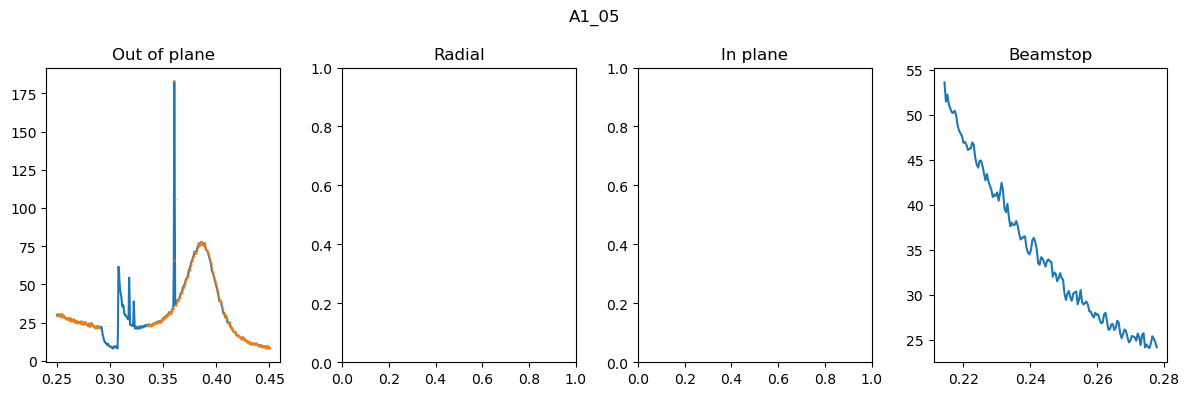

CM_fixedpossweep_A1_05_2540.00eV_ai0.40_wa18_bpm155.253_id895157_000000_WAXS.tif


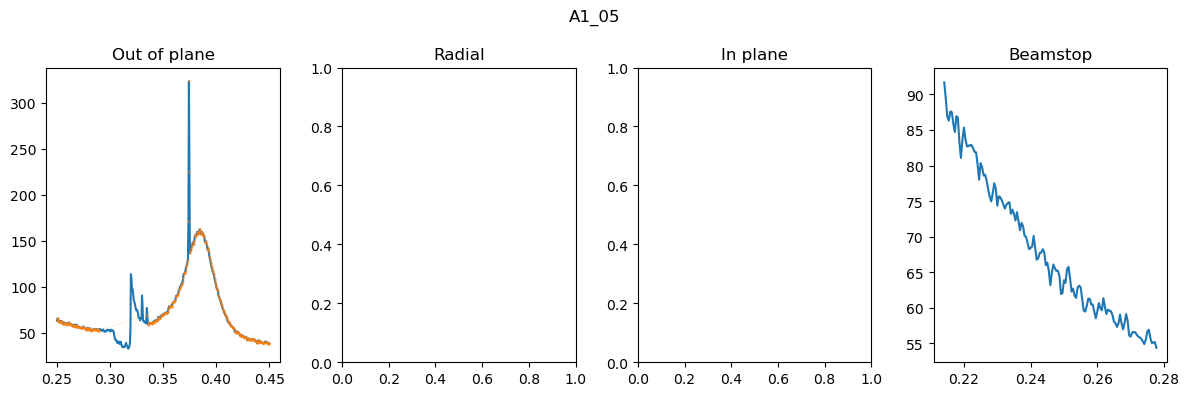

CM_fixedpossweep_A1_05_2450.00eV_ai0.40_wa18_bpm156.269_id895152_000000_WAXS.tif


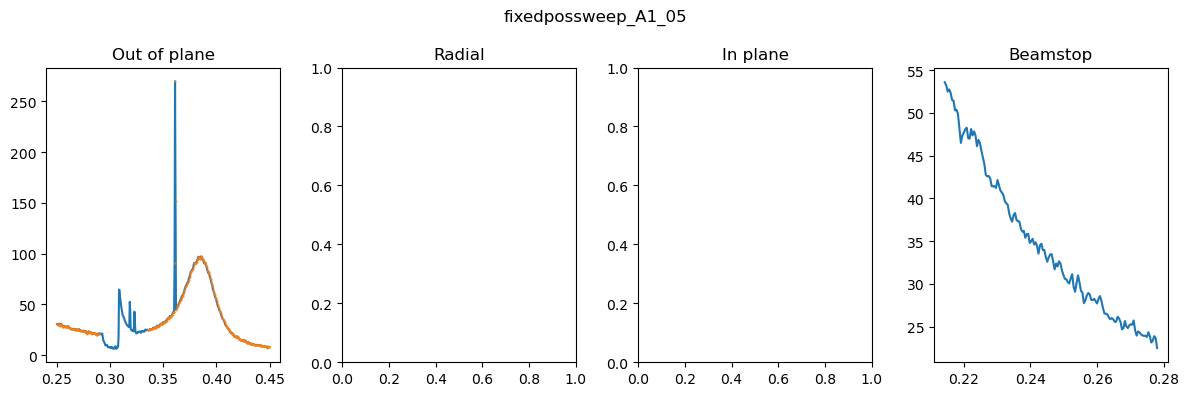

CM_fixedpossweep_A1_05_2510.00eV_ai0.40_wa18_bpm155.209_id895156_000000_WAXS.tif


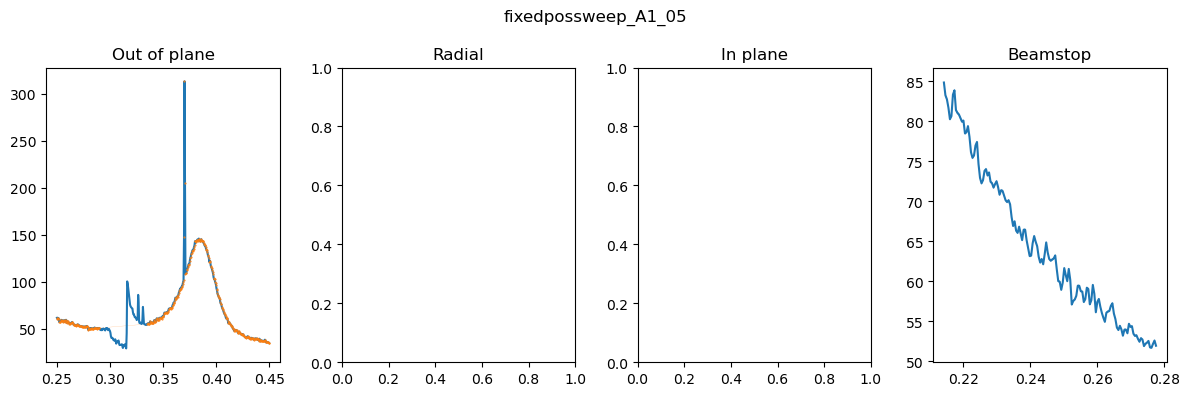

In [128]:
for i, sample in enumerate(samples):
    for j, ai in enumerate(sample_angles[i]):
        for test_file in test_files:
            # Setup a figure and open the file
            fnames = datasets[i][j][test_file]
            fname = fnames[0]
            print(fname)
            # Collect the metadata
            en_idx = fname.find('eV_')
            en = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai2 = float(fname[ai_idx+3:ai_idx+7])
            assert ai==ai2
            
            # Collect the line profiles from disk
            sample_dir = os.path.join(RESULT_DIR, sample)
            line_profiles_dir = os.path.join(sample_dir, "line_profiles")
            if not os.path.isdir(line_profiles_dir):
                os.mkdir(line_profiles_dir)
            path_OOP = os.path.normpath(os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_OOP.txt"))
            path_IP = os.path.normpath(os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_IP.txt"))
            path_R = os.path.normpath(os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt"))
            
            data_OOP = np.loadtxt(path_OOP, delimiter="\t", unpack=True, skiprows=2, dtype=float)
            q0_OOP, I0_OOP, I0_OOP_err = data_OOP[0], data_OOP[1], data_OOP[2]
            data_IP = np.loadtxt(path_IP, delimiter="\t", unpack=True, skiprows=2, dtype=float)
            q0_IP, I0_IP, I0_IP_err = data_IP[0], data_IP[1], data_IP[2]
            data_R = np.loadtxt(path_R, delimiter="\t", unpack=True, skiprows=2, dtype=float)
            q0_R, I0_R, I0_R_err = data_R[0], data_R[1], data_R[2]

            # Find the q-range to the region of interest
            if len(VERT_PEAKS) > 0:
                idx_OOP = np.where((q0_OOP > np.min(VERT_PEAKS)) & (q0_OOP < np.max(VERT_PEAKS)))
            else:
                idx_OOP = np.arange(len(q0_OOP))
            if len(HOR_PEAKS) > 0:
                idx_IP = np.where((q0_IP > np.min(HOR_PEAKS)) & (q0_IP < np.max(HOR_PEAKS)))
            else:
                idx_IP = np.arange(len(q0_IP))
            if len(RAD_PEAKS) > 0:
                idx_R = np.where((q0_R > np.min(RAD_PEAKS)) & (q0_R < np.max(RAD_PEAKS)))
            else:
                idx_R = np.arange(len(q0_R))
            # Collect the beamstop region
            idx_BS = np.where((q0_OOP > np.min(VERT_BEAMSTOP)) & (q0_OOP < np.max(VERT_BEAMSTOP)))
                
            # Truncate the data to the region of interest
            q0_OOP_TR, I0_OOP_TR, I0_OOP_err_TR = q0_OOP[idx_OOP], I0_OOP[idx_OOP], I0_OOP_err[idx_OOP]
            q0_IP_TR, I0_IP_TR, I0_IP_err_TR = q0_IP[idx_IP], I0_IP[idx_IP], I0_IP_err[idx_IP]
            q0_R_TR, I0_R_TR, I0_R_err_TR = q0_R[idx_R], I0_R[idx_R], I0_R_err[idx_R]
            # Also include/exclude gap regions
            if len(VERT_GAPS) > 0:
                idx2_OOP = np.where(np.bitwise_and.reduce([(~((q0_OOP_TR > gap[0]) & (q0_OOP_TR < gap[1]))) for gap in VERT_GAPS]))
            else:
                idx2_OOP = np.arange(len(q0_OOP_TR))
            if len(HOR_GAPS) > 0:
                idx2_IP = np.where(np.bitwise_and.reduce([(~((q0_IP_TR > gap[0]) & (q0_IP_TR < gap[1]))) for gap in HOR_GAPS]))
            else:
                idx2_IP = np.arange(len(q0_IP_TR))
            if len(RAD_GAPS) > 0:
                idx2_R = np.where(np.bitwise_and.reduce([(~((q0_R_TR > gap[0]) & (q0_R_TR < gap[1]))) for gap in RAD_GAPS]))
            else:
                idx2_R = np.arange(len(q0_R_TR))
                
            # Truncate the data to the region of interest
            q0_OOP_TR2, I0_OOP_TR2, I0_OOP_err_TR2 = q0_OOP_TR[idx2_OOP], I0_OOP_TR[idx2_OOP], I0_OOP_err_TR[idx2_OOP]
            q0_IP_TR2, I0_IP_TR2, I0_IP_err_TR2 = q0_IP_TR[idx2_IP], I0_IP_TR[idx2_IP], I0_IP_err_TR[idx2_IP]
            q0_R_TR2, I0_R_TR2, I0_R_err_TR2 = q0_R_TR[idx2_R], I0_R_TR[idx2_R], I0_R_err_TR[idx2_R]

            # Plot the data
            fig, ax = plt.subplots(max([len(VERT_PEAKS), len(HOR_PEAKS), len(RAD_PEAKS)]), 4, figsize=(12,4))
            if len(ax.shape) == 1:
                ax = ax.reshape(1,4)
            for k, peak in enumerate(VERT_PEAKS):
                idx = (q0_OOP_TR > peak[0]) & (q0_OOP_TR < peak[1])
                idx2 = (q0_OOP_TR2 > peak[0]) & (q0_OOP_TR2 < peak[1])
                ax[k][0].plot(q0_OOP_TR[idx], I0_OOP_TR[idx], label="Out of plane raw")
                ax[k][0].fill_between(q0_OOP_TR[idx], (I0_OOP_TR - I0_OOP_err_TR)[idx], (I0_OOP_TR + I0_OOP_err_TR)[idx], alpha=0.5)
                if len(q0_OOP_TR2[idx2]) != len(q0_OOP_TR[idx]):
                    ax[k][0].plot(q0_OOP_TR2[idx2], I0_OOP_TR2[idx2], label="Out of plane raw (gaps removed)", markersize=1, marker=".", linewidth=0)
                    ax[k][0].fill_between(q0_OOP_TR2[idx2], (I0_OOP_TR2 - I0_OOP_err_TR2)[idx2], (I0_OOP_TR2 + I0_OOP_err_TR2)[idx2], alpha=0.5)
            for k, peak in enumerate(RAD_PEAKS):
                idx = (q0_R_TR > peak[0]) & (q0_R_TR < peak[1])
                idx2 = (q0_R_TR2 > peak[0]) & (q0_R_TR2 < peak[1])
                ax[k][1].plot(q0_R_TR[idx], I0_R_TR[idx], label="Radial raw")
                ax[k][1].fill_between(q0_R_TR[idx], (I0_R_TR - I0_R_err_TR)[idx], (I0_R_TR + I0_R_err_TR)[idx], alpha=0.5)
                if len(q0_R_TR2[idx2]) != len(q0_R_TR[idx]):
                    ax[k][1].plot(q0_R_TR2[idx2], I0_R_TR2[idx2], label="Radial raw (gaps removed)", markersize=1, marker=".", linewidth=0)
                    ax[k][1].fill_between(q0_R_TR2[idx2], (I0_R_TR2 - I0_R_err_TR2)[idx2], (I0_R_TR2 + I0_R_err_TR2)[idx2], alpha=0.5)
            for k, peak in enumerate(HOR_PEAKS):
                idx = (q0_IP_TR > peak[0]) & (q0_IP_TR < peak[1])
                idx2 = (q0_IP_TR2 > peak[0]) & (q0_IP_TR2 < peak[1])
                ax[k][2].plot(q0_IP_TR[idx], I0_IP_TR[idx], label="In plane raw")
                ax[k][2].fill_between(q0_IP_TR[idx], (I0_IP_TR - I0_IP_err_TR)[idx], (I0_IP_TR + I0_IP_err_TR)[idx], alpha=0.5)
                if len(q0_IP_TR2[idx2]) != len(q0_IP_TR[idx]):
                    ax[k][2].plot(q0_IP_TR2[idx2], I0_IP_TR2[idx2], label="In plane raw (gaps removed)", markersize=1, marker=".", linewidth=0)
                    ax[k][2].fill_between(q0_IP_TR2[idx2], (I0_IP_TR2 - I0_IP_err_TR2)[idx2], (I0_IP_TR2 + I0_IP_err_TR2)[idx2], alpha=0.5)
            ax[0][0].set_title("Out of plane")
            ax[0][1].set_title("Radial")
            ax[0][2].set_title("In plane")

            for a in ax.flatten():
                # a.set_xscale("log")
                # a.set_yscale("log")
                pass
            # Plot the area under the beamstop region
            ax[0][3].plot(q0_OOP[idx_BS], I0_OOP[idx_BS], label="Beamstop")
            ax[0][3].fill_between(q0_OOP[idx_BS], I0_OOP[idx_BS] - I0_OOP_err[idx_BS], I0_OOP[idx_BS] + I0_OOP_err[idx_BS], alpha=0.5)
            ax[0][3].set_title("Beamstop")
            fig.suptitle(sample)
            # plt.close()
            fig.tight_layout()
            plt.show()
        break

##### Attempt some fitting of the peaks
###### Define the peakfit functions

In [129]:
power_law = lambda x, a=1, b=-1, c=0: a * (x-c)**b
"""A power law function for fitting the data

Parameters
----------
    a : float
        The amplitude of the power law, by default 1
    b : float
        The power of the power law, by default -1
    c : float
        The translational offset of the power law, by default 0
"""

lorentz = lambda x, a=1, b=1, c=1: a * c / ((x - b)**2 + c**2)
"""A Lorentzian function for fitting the data

Parameters
----------
    a : float
        The amplitude of the Lorentzian, by default 1
    b : float
        The peak position of the Lorentzian, by default 1
    c : float
        The width of the Lorentzian, by default 1
"""

gauss = lambda x, a=1, b=1, c=1: a * np.exp(-((x - b)**2) / (2 * c**2))
"""A Gaussian function for fitting the data

Parameters
----------
    a : float
        The amplitude of the Gaussian, by default 1
    b : float
        The peak position of the Gaussian, by default 1
    c : float
        The width of the Gaussian, by default 1
"""
# # Without power law centre:
fit_fn_lor = lambda x, a,b,c,d,e,f: np.sqrt((lorentz(x,a,b,c) + power_law(x,d,e))**2 + f**2)
fit_fn_lor_log = lambda x, a,b,c,d,e,f: np.log(fit_fn_lor(x,a,b,c,d,e,f))
fit_fn_gau = lambda x, a,b,c,d,e,f: np.sqrt((gauss(x,a,b,c) + power_law(x,d,e))**2 + f**2)
fit_fn_gau_log = lambda x, a,b,c,d,e,f: np.log(fit_fn_gau(x,a,b,c,d,e,f))

FLUOR_fit_fn_lor = lambda x, a,b,c,d,e,f: np.trapz(np.sqrt((power_law(x,d,e))**2 + f**2), x)

##### Create a reasonable guess close to the optimum

In [130]:
# Define the initial guesses for the peaks
VERT_GUESSES: list[tuple] = [
    (10,	0.39,	0.017,	5,	-2.6,	10),
]
"""A list of tuples defining the initial guesses for each out-of-plane peak of interest"""
HOR_GUESSES: list[tuple] = []
"""A list of tuples defining the initial guesses for each in-plane peak of interest"""
RAD_GUESSES: list[tuple] = []
"""A list of tuples defining the initial guesses for each radial peak of interest"""

# Define the parameter labels
VERT_LABELS: list[list[str]] = [
    # ["Gauss Amp.", "Gauss Centre", "Gauss Width", "Powerlaw Amplitude", "Powerlaw Power", "Offset"]
    ["Lorentz Amp.", "Lorentz Centre", "Lorentz Width", "Powerlaw Amplitude", "Powerlaw Power", "Offset"]
    # ["Lorentz Amp.", "Lorentz Centre", "Lorentz Width", "Powerlaw Amplitude", "Powerlaw Power", "Sin Freq.", "Sin Phase", "Sin Amp.", "Offset"]
]
"""A list of lists defining the labels for the fitting parameters for each out-of-plane peak"""
HOR_LABELS: list[list[str]] = []
"""A list of lists defining the labels for the fitting parameters for each in-plane peak"""
RAD_LABELS: list[list[str]] = []
"""A list of lists defining the labels for the fitting parameters for each radial peak"""

# Fitting functions
# VERT_FIT_FNS: list[Callable] = [fit_fn_lor_sin]
VERT_FIT_FNS: list[Callable] = [fit_fn_lor]
# VERT_FIT_FNS: list[Callable] = [fit_fn_gau]
"""A list of fitting functions for the out-of-plane peaks"""
HOR_FIT_FNS: list[Callable] = []
"""A list of fitting functions for the in-plane peaks"""
RAD_FIT_FNS: list[Callable] = []
"""A list of fitting functions for the radial peaks"""

#Bounds
# VERT_LB : list[tuple | None] = [(0, 0, 0, 0, -np.inf, 0, -180, 0, 0)]
VERT_LB : list[tuple | None] = [(0, 0.35, 0.001, 0, -np.inf, 0)]
"""List of tuples defining the lower bounds for the fitting parameters for each out-of-plane peak"""
# VERT_UB : list[tuple | None] = [(np.inf, np.inf, np.inf, np.inf, -1, np.inf, 180, np.inf, np.inf)]
VERT_UB : list[tuple | None] = [(np.inf, 0.42, 0.04, np.inf, -1, np.inf)]
"""List of tuples defining the upper bounds for the fitting parameters for each out-of-plane peak"""
VERT_BOUNDS : list[tuple[tuple | None, tuple | None] | None] = [(VERT_LB[i], VERT_UB[i]) for i in range(len(VERT_LB))]
"""List of tuples of lower-bound/upper-bound tuples, defining the bounds for the fitting parameters for each out-of-plane peak"""
HOR_LB : list[tuple | None] = []
"""List of tuples defining the lower bounds for the fitting parameters for each in-plane peak"""
HOR_UB : list[tuple | None] = []
"""List of tuples defining the upper bounds for the fitting parameters for each in-plane peak"""
HOR_BOUNDS : list[tuple[tuple | None, tuple | None] | None] = [(HOR_LB[i], HOR_UB[i]) for i in range(len(HOR_LB))]
"""List of tuples of lower-bound/upper-bound tuples, defining the bounds for the fitting parameters for each in-plane peak"""
RAD_LB : list[tuple | None] = []
"""List of tuples defining the lower bounds for the fitting parameters for each radial peak"""
RAD_UB : list[tuple | None] = []
"""List of tuples defining the upper bounds for the fitting parameters for each radial peak"""
RAD_BOUNDS : list[tuple[tuple | None, tuple | None] | None] = [(RAD_LB[i], RAD_UB[i]) for i in range(len(RAD_LB))]
"""List of tuples of lower-bound/upper-bound tuples, defining the bounds for the fitting parameters for each radial peak"""

# Convert (None, None) tuples to None for the bounds
VERT_BOUNDS = [None if bounds == (None, None) else bounds for bounds in VERT_BOUNDS]
HOR_BOUNDS = [None if bounds == (None, None) else bounds for bounds in HOR_BOUNDS]
RAD_BOUNDS = [None if bounds == (None, None) else bounds for bounds in RAD_BOUNDS]

# Check the number of guesses matches the number of peaks
assert len(VERT_PEAKS) == len(VERT_GUESSES) == len(VERT_BOUNDS) == len(VERT_LABELS), "The number of guesses must match the number of peaks and bounds."
assert len(HOR_PEAKS) == len(HOR_GUESSES) == len(HOR_BOUNDS) == len(HOR_LABELS), "The number of guesses must match the number of peaks and bounds."
assert len(RAD_PEAKS) == len(RAD_GUESSES) == len(RAD_BOUNDS) == len(RAD_LABELS), "The number of guesses must match the number of peaks and bounds."

# Pack the fitting functions, guesses and bounds into a single iterable
FIT_REGISTER: list[tuple[Literal["OOP"] | Literal["IP"] | Literal["RAD"],
                         tuple[float, float],
                         Callable, 
                         tuple, 
                         tuple[tuple | None, tuple | None] | None,
                         list[str]]
                   ] = []
"""A list of tuples defining:
    1. The peak type (e.g. 'OOP', 'IP', 'RAD')
    2. The peak q-range
    3. The fitting function
    4. The initial guesses tuple
    5. The bounds tuple (lower|None, upper|None) | None matching length of guesses tuple.
    6. The list of parameter labels (corresponding to 4,5).
"""
for i, peak in enumerate(VERT_PEAKS):
    FIT_REGISTER.append(("OOP", peak, VERT_FIT_FNS[i], VERT_GUESSES[i], VERT_BOUNDS[i], VERT_LABELS[i]))
for i, peak in enumerate(HOR_PEAKS):
    FIT_REGISTER.append(("IP", peak, HOR_FIT_FNS[i], HOR_GUESSES[i], HOR_BOUNDS[i], HOR_LABELS[i]))
for i, peak in enumerate(RAD_PEAKS):
    FIT_REGISTER.append(("RAD", peak, RAD_FIT_FNS[i], RAD_GUESSES[i], RAD_BOUNDS[i], RAD_LABELS[i]))

# Display the initial guesses over the data
FIT_N = max([len(VERT_PEAKS), len(HOR_PEAKS), len(RAD_PEAKS)])

CM_A1_05_2445.00eV_ai0.40_wa18_bpm156.017_id895319_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power        Offset
OOP Peak #0 Fit        1.293798        0.383677       0.018473            0.253788       -3.454485  2.365093e-10
OOP Peak #0 Error      0.041716        0.000309       0.000635            0.087450        0.263864  0.000000e+00

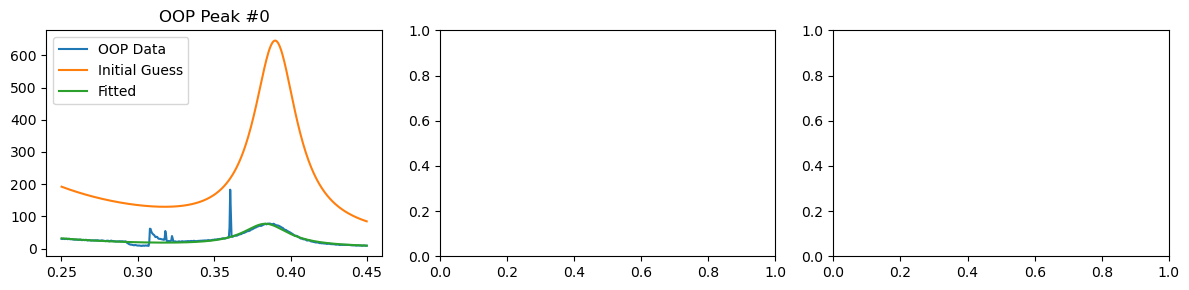

CM_fixedpossweep_A1_05_2540.00eV_ai0.40_wa18_bpm155.253_id895157_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        2.442785        0.383092       0.018139            5.252672       -1.717718  20.977263
OOP Peak #0 Error      0.153880        0.000226       0.000699            3.038148        0.394010   7.917203

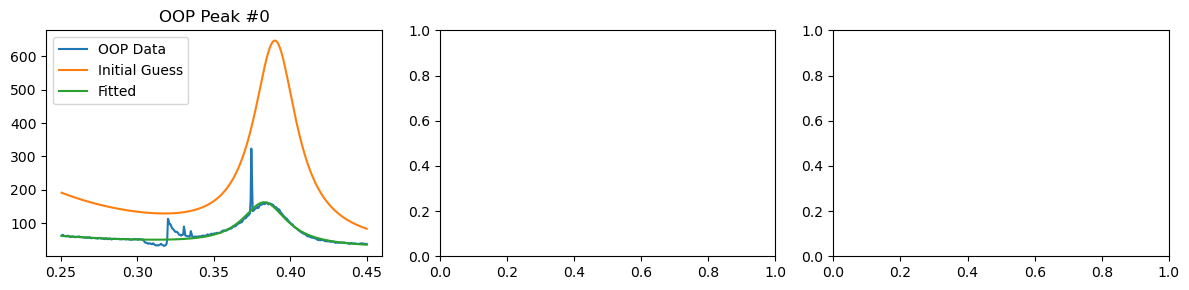

CM_A1_05_2445.00eV_ai0.80_wa18_bpm156.230_id895382_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        8.421912        0.382476       0.012220           10.394000       -1.000000  51.636753
OOP Peak #0 Error      0.118168        0.000053       0.000145            2.877281        0.147584   3.883196

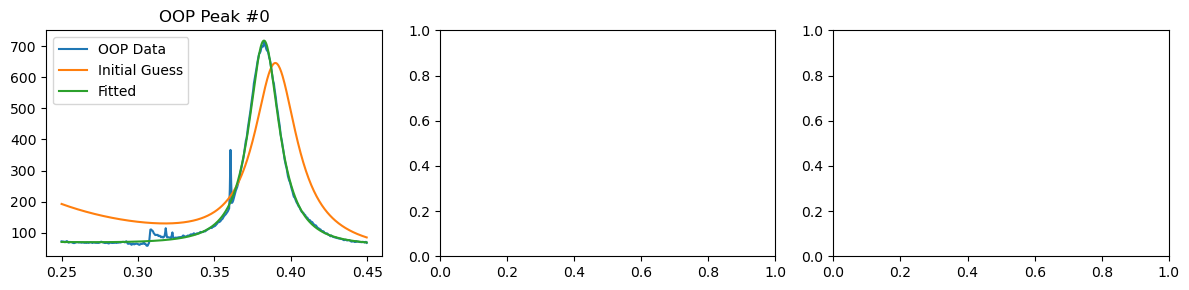

CM_fixedpossweep_A1_05_2540.00eV_ai0.80_wa18_bpm155.248_id895164_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power      Offset
OOP Peak #0 Fit       11.395673        0.382832       0.013494           13.726051       -1.000000  188.737901
OOP Peak #0 Error      0.210898        0.000051       0.000174            5.324869        0.226391    3.053995

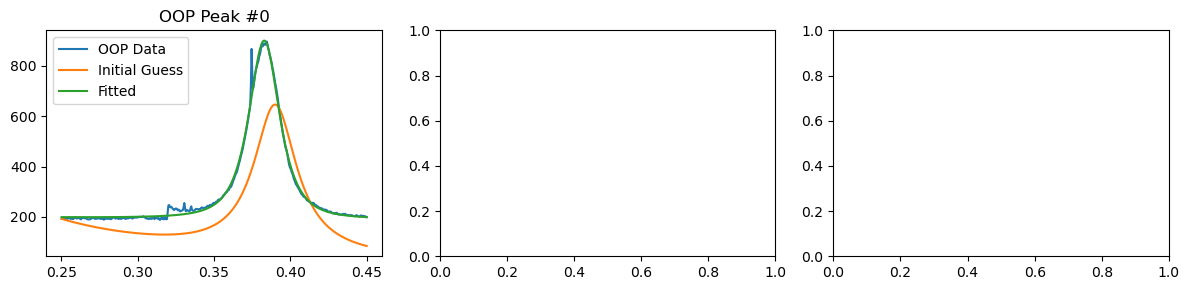

CM_A1_05_2445.00eV_ai4.00_wa18_bpm156.136_id895445_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        3.108684        0.379723       0.012980            3.826289       -1.000000  69.857541
OOP Peak #0 Error      0.164888        0.000131       0.000464            4.619683        0.753786   1.956172

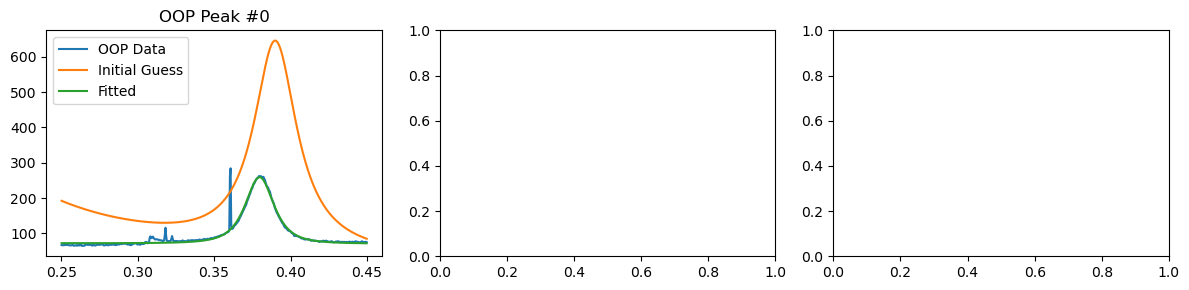

CM_fixedpossweep_A1_05_2540.00eV_ai4.00_wa18_bpm155.219_id895171_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power      Offset
OOP Peak #0 Fit        4.132402        0.380038       0.012721            5.409260       -1.000000  102.210663
OOP Peak #0 Error      0.166053        0.000094       0.000339            4.809289        0.555638    1.898691

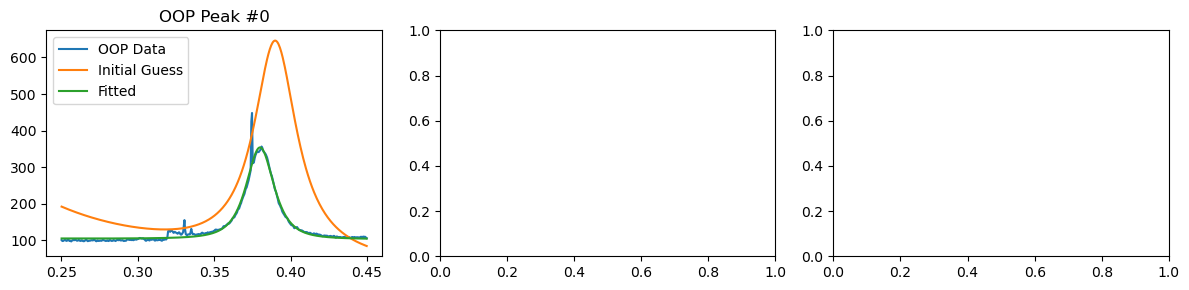

CM_A1_05_2445.00eV_ai8.00_wa18_bpm156.250_id895508_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        2.724555        0.379707       0.015116            2.477297       -1.000000  57.507887
OOP Peak #0 Error      0.260054        0.000250       0.000934            6.289610        1.651066   2.591962

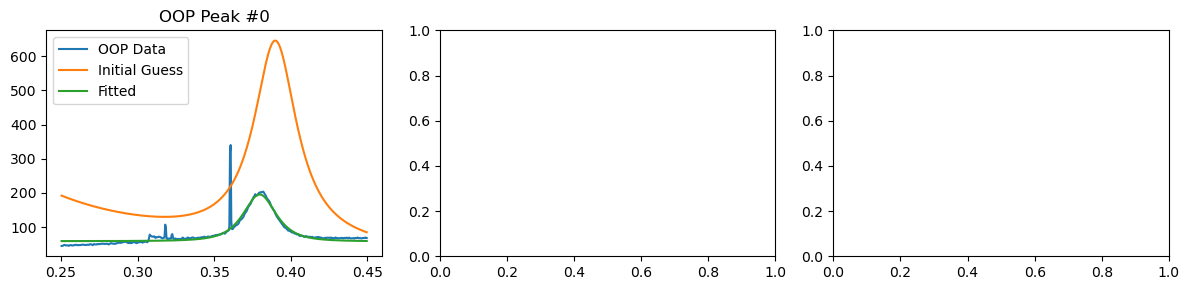

CM_fixedpossweep_A1_05_2540.00eV_ai8.00_wa18_bpm155.219_id895178_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        3.499976        0.380351       0.013464            3.462631       -1.000000  74.233176
OOP Peak #0 Error      0.270904        0.000199       0.000701            7.173130        1.380709   2.974458

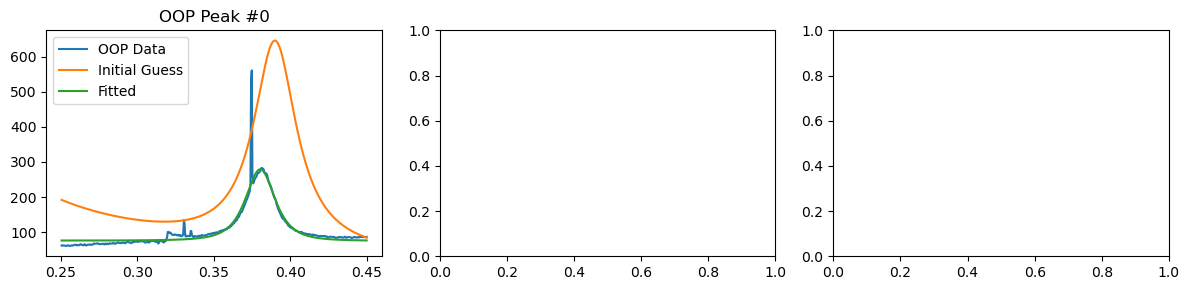

CM_fixedpossweep_A1_05_2450.00eV_ai0.40_wa18_bpm156.269_id895152_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power        Offset
OOP Peak #0 Fit        1.664517        0.382012       0.018242            0.074196       -4.341556  5.546014e-11
OOP Peak #0 Error      0.047234        0.000315       0.000583            0.039798        0.409631  0.000000e+00

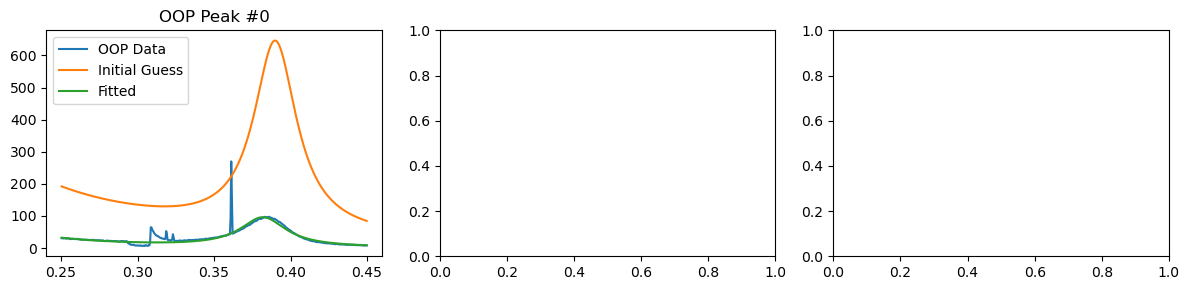

CM_fixedpossweep_A1_05_2510.00eV_ai0.40_wa18_bpm155.209_id895156_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        2.293636        0.382923       0.018926            3.933395       -1.881888  21.402872
OOP Peak #0 Error      0.147384        0.000256       0.000761            2.425598        0.426306   6.281139

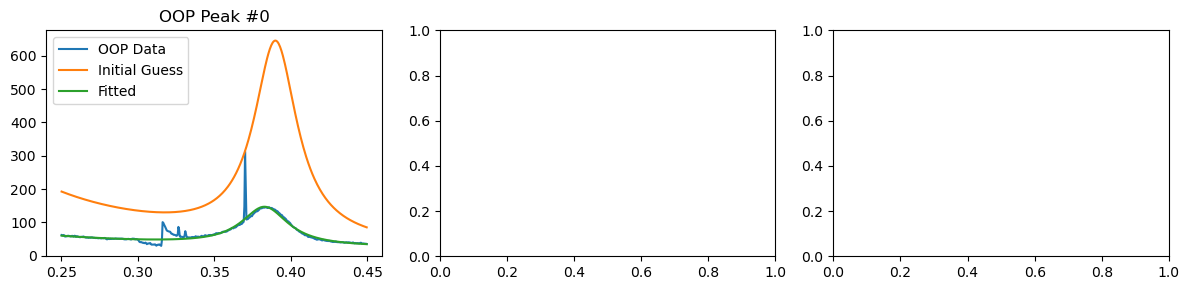

CM_fixedpossweep_A1_05_2450.00eV_ai0.80_wa18_bpm156.259_id895159_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        8.476221        0.382635       0.012256           10.396458       -1.000000  54.764660
OOP Peak #0 Error      0.114340        0.000051       0.000138            2.782944        0.143126   3.581941

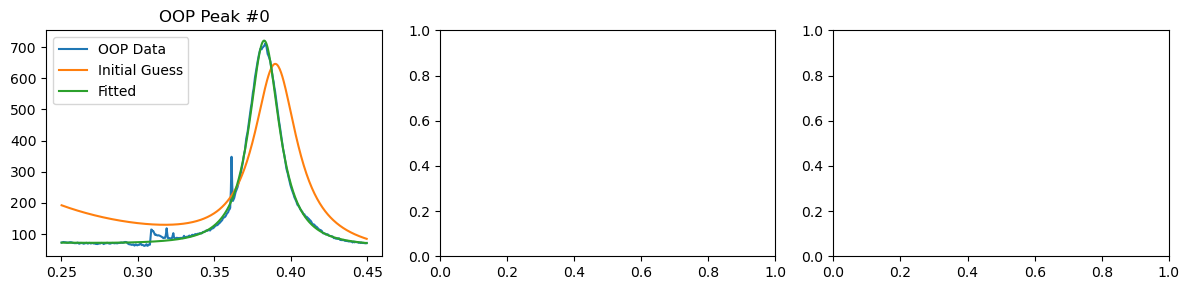

CM_fixedpossweep_A1_05_2510.00eV_ai0.80_wa18_bpm155.144_id895163_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power      Offset
OOP Peak #0 Fit       10.767954        0.382591       0.013724           13.386432       -1.000000  186.835660
OOP Peak #0 Error      0.200211        0.000050       0.000174            5.088561        0.220657    2.820573

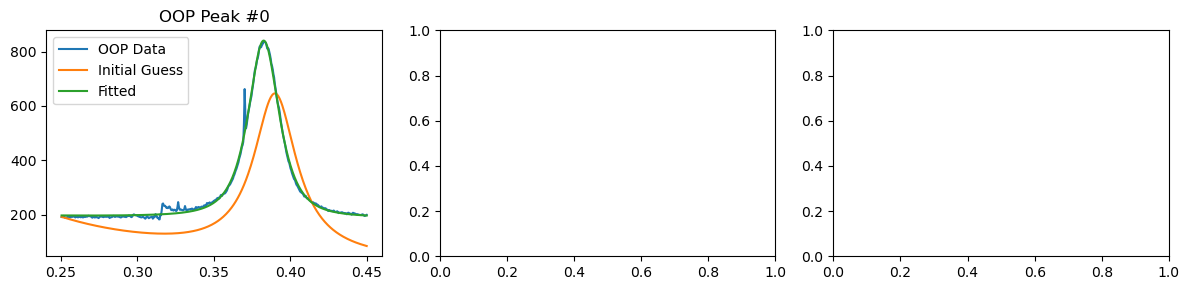

CM_fixedpossweep_A1_05_2450.00eV_ai4.00_wa18_bpm156.206_id895166_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        3.067637        0.379987       0.013016            3.633106       -1.000000  70.628050
OOP Peak #0 Error      0.144467        0.000116       0.000412            4.031223        0.705535   1.652597

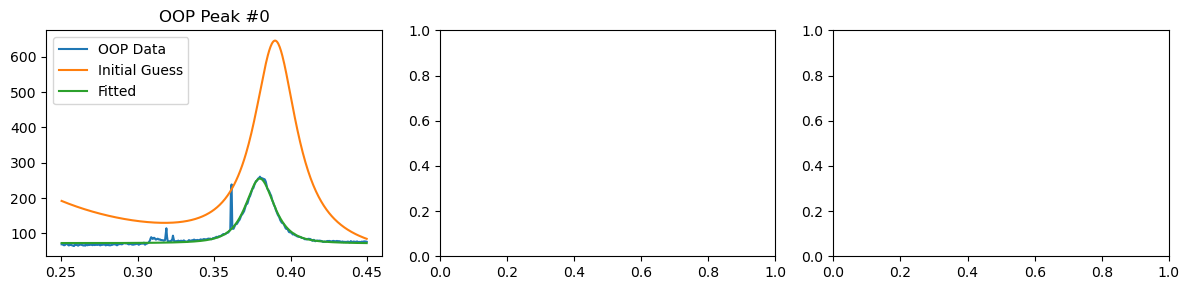

CM_fixedpossweep_A1_05_2510.00eV_ai4.00_wa18_bpm155.088_id895170_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power      Offset
OOP Peak #0 Fit        4.038157        0.379970       0.013249            4.813780         -1.0000  102.452467
OOP Peak #0 Error      0.175780        0.000102       0.000377            4.902595          0.6507    1.839997

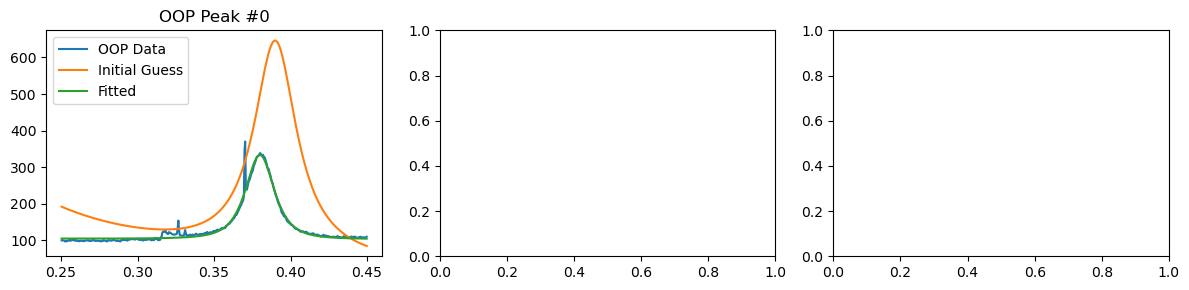

CM_fixedpossweep_A1_05_2450.00eV_ai8.00_wa18_bpm156.137_id895173_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        2.758817        0.379961       0.015391            2.496005       -1.000000  58.043642
OOP Peak #0 Error      0.281242        0.000267       0.001008            6.678714        1.724928   2.774671

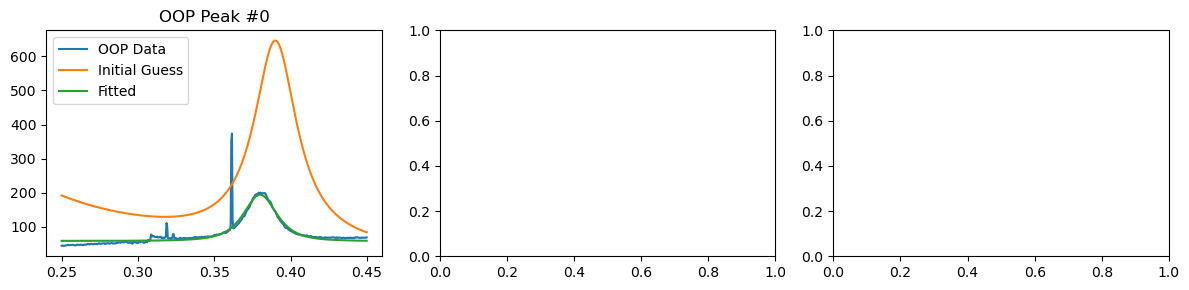

CM_fixedpossweep_A1_05_2510.00eV_ai8.00_wa18_bpm155.181_id895177_000000_WAXS.tif


Lorentz Amp.  Lorentz Centre  Lorentz Width  Powerlaw Amplitude  Powerlaw Power     Offset
OOP Peak #0 Fit        3.353511        0.380139       0.014291            3.133946       -1.000000  73.632200
OOP Peak #0 Error      0.262981        0.000201       0.000733            6.660717        1.413516   2.645584

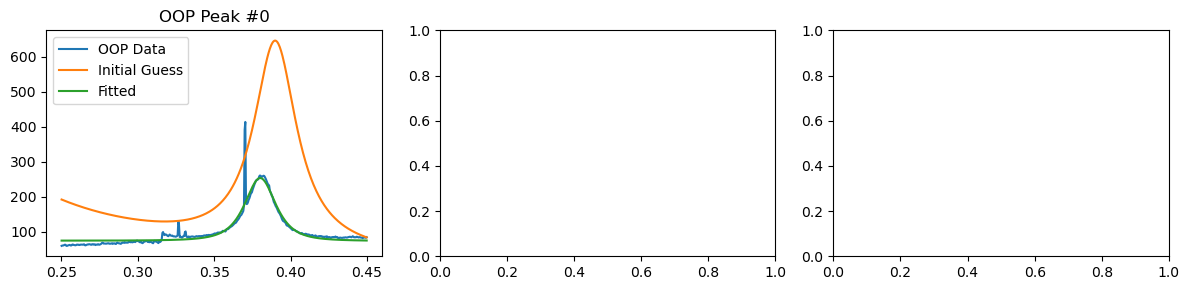

In [131]:
for i, sample in enumerate(samples):
    for j, ai in enumerate(sample_angles[i]):
        for test_file in test_files:
            # Setup a figure and open the file
            fnames = datasets[i][j][test_file]
            fname = fnames[0]
            print(fname)
            # Collect the metadata
            en_idx = fname.find('eV_')
            en = float(fname[en_idx-7:en_idx])
            ai_idx = fname.find("_ai")
            ai2 = float(fname[ai_idx+3:ai_idx+7])
            assert ai==ai2
            
            # Collect the line profiles from disk
            sample_dir = os.path.join(RESULT_DIR, sample)
            line_profiles_dir = os.path.join(sample_dir, "line_profiles")
            if not os.path.isdir(line_profiles_dir):
                os.mkdir(line_profiles_dir)
            path_OOP = os.path.normpath(os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_OOP.txt"))
            path_IP = os.path.normpath(os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_IP.txt"))
            path_R = os.path.normpath(os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt"))
            
            data_OOP = np.loadtxt(path_OOP, delimiter="\t", unpack=True, skiprows=2, dtype=float)
            q0_OOP, I0_OOP, I0_OOP_err = data_OOP[0], data_OOP[1], data_OOP[2]
            data_IP = np.loadtxt(path_IP, delimiter="\t", unpack=True, skiprows=2, dtype=float)
            q0_IP, I0_IP, I0_IP_err = data_IP[0], data_IP[1], data_IP[2]
            data_R = np.loadtxt(path_R, delimiter="\t", unpack=True, skiprows=2, dtype=float)
            q0_R, I0_R, I0_R_err = data_R[0], data_R[1], data_R[2]

            fig, ax = plt.subplots(FIT_N, 3, figsize=(12,3*FIT_N))
            if len(ax.shape) == 1:
                ax = ax.reshape(1,3)

            counts = [0, 0, 0] # Count the number of peaks for each direction
            for k, fit in enumerate(FIT_REGISTER):
                peak_type, peak_range, fit_fn, guess, bounds, labels = fit
                match peak_type:
                    case "OOP":
                        l = 0
                        q, I, I_err = q0_OOP, I0_OOP, I0_OOP_err
                    case "IP":
                        l = 1
                        q, I, I_err = q0_IP, I0_IP, I0_IP_err
                    case "RAD":
                        l = 2
                        q, I, I_err = q0_R, I0_R, I0_R_err
                idxs = np.where((q > peak_range[0]) & (q < peak_range[1]))
                q = q[idxs]
                I = I[idxs]
                I_err = I_err[idxs]
                
                ax[l][counts[l]].set_title(f"{peak_type} Peak #{k}")
                ax[l][counts[l]].plot(q, I, label=f"{peak_type} Data")
                ax[l][counts[l]].fill_between(q, I - I_err, I + I_err, alpha=0.5)
                ax[l][counts[l]].plot(q, fit_fn(q, *VERT_GUESSES[k]), label="Initial Guess")
                popt, pcov = curve_fit(fit_fn, q, I, p0=guess, sigma=I_err, maxfev=100000, bounds=bounds)
                ax[l][counts[l]].plot(q, fit_fn(q, *popt), label="Fitted")
                ax[l][counts[l]].legend()
                display(pd.DataFrame(
                    [popt, np.sqrt(np.diag(pcov))],
                    columns=labels,
                    index=[f"{peak_type} Peak #{k} Fit", f"{peak_type} Peak #{k} Error"]
                ))
                counts[l] += 1
            fig.tight_layout()
            plt.show()

### Use Monte-Carlo Markov Chains to see if the Least Squares solution is really a good fit of random variables
##### Define the likelihood, prior and probability functions

In [ ]:
def gen_fns(fit_fn: Callable, bounds: tuple[tuple | None, tuple | None] | None) -> tuple[Callable, Callable, Callable]:
    """Genereate the log-likelihood, log-prior and log-probability functions for the fitting"""
    def log_likelihood(theta, x, y, yerr, fit_fn: Callable = fit_fn) -> float:
        model_y = fit_fn(x, *theta)
        sigma2 = yerr**2
        return -0.5 * np.sum((y - model_y)**2 / sigma2 )
    
    def log_prior(theta, bounds: tuple[tuple | None, tuple | None] | None = bounds) -> float:
        """Define the log-prior function for the fitting"""
        if bounds is None:
            return 0.0
        lb, ub = bounds
        # Return -np.inf if out of bounds.
        if lb is not None:
            for i in range(len(theta)):
                if lb[i] is not None:
                    if lb[i] > theta[i]:
                        return -np.inf
        if not ub is None:
            for i in range(len(theta)):
                if ub[i] is not None:
                    if ub[i] < theta[i]:
                        return -np.inf
        return 0.0
    
    def log_probability(theta, x, y, yerr, lprior: Callable = log_prior, llikelihood: Callable = log_likelihood) -> float:
        """Define the log-probability function for the fitting"""
        lp = lprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + llikelihood(theta, x, y, yerr)
    
    return log_likelihood, log_prior, log_probability

LOG_LIKELIHOOD_FNS: list[Callable] = []
"""A list of log-likelihood functions for each peak. By default a Gaussian log-likelihood function is used for each parameter, but can be redefined."""
LOG_PRIOR_FNS: list[Callable] = []
"""A list of log-prior functions for each peak. By default no prior is defined, but can be redefined."""
LOG_PROBABILITY_FNS: list[Callable] = []

for i, fit in enumerate(FIT_REGISTER):
    peak_type, peak_range, fit_fn, guess, bounds, labels = fit
    log_likelihood, log_prior, log_probability = gen_fns(fit_fn, bounds)
    LOG_LIKELIHOOD_FNS.append(log_likelihood)
    LOG_PRIOR_FNS.append(log_prior)
    LOG_PROBABILITY_FNS.append(log_probability)

# Test the log_probability function - should be non-infinite if working.
test_guess = FIT_REGISTER[0][3]
test_q = q0_OOP_TR if FIT_REGISTER[0][0] == "OOP" else q0_IP_TR if FIT_REGISTER[0][0] == "IP" else q0_R_TR
test_I = I0_OOP_TR if FIT_REGISTER[0][0] == "OOP" else I0_IP_TR if FIT_REGISTER[0][0] == "IP" else I0_R_TR
test_I_err = I0_OOP_err_TR if FIT_REGISTER[0][0] == "OOP" else I0_IP_err_TR if FIT_REGISTER[0][0] == "IP" else I0_R_err_TR
LOG_PROBABILITY_FNS[0](
    theta=test_guess,
    x=test_q, 
    y=test_I, 
    yerr=test_I_err,
    lprior=LOG_PRIOR_FNS[0],
    llikelihood=LOG_LIKELIHOOD_FNS[0]
)

##### Use emcee sampler to run N walkers

In [ ]:
# Use the data from the first vert peak
qmin, qmax = VERT_PEAKS[0]
idxs = np.where((q0_OOP_TR > qmin) & (q0_OOP_TR < qmax))
x = q0_OOP_TR[idxs]
y = I0_OOP_TR[idxs]
yerr = I0_OOP_err_TR[idxs]
popt, pcov = curve_fit(VERT_FIT_FNS[0], x, y, sigma=yerr, p0=VERT_GUESSES[0], maxfev=10000, bounds=VERT_BOUNDS[0])

start = time.time()

# Use the model on the first vert peak.
N = 200
pos = popt * np.ones((N, len(popt))) * (1 + (1.0e-2 * np.random.randn(N, len(popt)) - 5.0e-3))
# Check each parameter is within bounds
for i in range(len(VERT_BOUNDS[0][0])):
    lb, ub = VERT_BOUNDS[0][0][i], VERT_BOUNDS[0][1][i]
    if lb is not None:
        pos[:,i] = np.clip(pos[:,i], lb, np.inf)
    if ub is not None:
        pos[:,i] = np.clip(pos[:,i], -np.inf, ub)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, LOG_PROBABILITY_FNS[0], args=(x, y, yerr, LOG_PRIOR_FNS[0], LOG_LIKELIHOOD_FNS[0])
)
M = 2000
sampler.run_mcmc(pos, M, progress=True)
max_tau = None
while max_tau is None:
    try:
        tau = sampler.get_autocorr_time()
        max_tau = np.max(tau)
    except emcee.autocorr.AutocorrError as e:
        tau_estimate = int(np.max(e.tau))
        if tau_estimate * 50 < 150000:
            print(f"Estimated max tau: {tau_estimate}, running for {50*tau_estimate} more steps.")
            sampler.run_mcmc(None, tau_estimate * 50, progress=False)
        else:
            print(f"Tau estimate too high ({tau_estimate}), to run Tau*50 steps, exiting...")
            break
    
end = time.time()
print(f"Time taken: {end - start:.1f} seconds.")

In [ ]:
### Display the chain output and estimate where the burn-in period (tau) is.
fig, axes = plt.subplots(len(VERT_LABELS[0]), figsize=(10, 2*len(VERT_LABELS[0])), sharex=True)
MC_samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(MC_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(MC_samples))
    ax.set_ylabel(VERT_LABELS[0][i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
tau_max = np.max(tau)
fig.suptitle(f"Chain Output - Corr time = {tau_max:0.2f} steps")

In [ ]:
flat_MC_samples = sampler.get_chain(discard=int(tau_max * 3), thin=5, flat=True)
fig = corner.corner(
    flat_MC_samples, labels=VERT_LABELS[0], truths=popt
)

In [ ]:
# Plot the result of the Least Squares fit and the MCMC fit
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
q = q0_OOP_TR[idxs]
ax[0].plot(q0_OOP_TR[idxs], I0_OOP_TR[idxs], label="Data")
ax[0].fill_between(q, I0_OOP_TR[idxs] - I0_OOP_err_TR[idxs], I0_OOP_TR[idxs] + I0_OOP_err_TR[idxs], alpha=0.5)
ax[0].plot(q, FIT_REGISTER[0][2](q, *popt), label="Least Squares Fit")
ax[0].fill_between(q, FIT_REGISTER[0][2](q, *popt - np.sqrt(np.diag(pcov))), FIT_REGISTER[0][2](q, *popt + np.sqrt(np.diag(pcov))), alpha=0.1)
ax[0].legend()
                   
# Plot the MCMC fit
MC_samples = sampler.get_chain(discard=200, thin=5, flat=True)
percentiles = [np.percentile(MC_samples[:, i], [16, 50, 84]) for i in range(MC_samples.shape[1])] #Sampling at 1 sigma percentiles
values = [p[1] for p in percentiles]
error_bounds = np.array([[p[0] - p[1], p[2] - p[1]] for p in percentiles])


inds = np.random.randint(len(MC_samples), size=100)
for ind in inds:
    sample = MC_samples[ind]
    ax[1].plot(q, FIT_REGISTER[0][2](q, *sample), "C1", alpha=0.1, label="MCMC Fit" if ind == inds[0] else None)
ax[1].plot(q0_OOP_TR[idxs], I0_OOP_TR[idxs], label="Data")
ax[1].fill_between(q, I0_OOP_TR[idxs] - I0_OOP_err_TR[idxs], I0_OOP_TR[idxs] + I0_OOP_err_TR[idxs], alpha=0.5)
ax[1].plot(q, FIT_REGISTER[0][2](q, *values), 'black', label="MCMC Fit")
ax[1].plot(q, FIT_REGISTER[0][2](q, *popt), label="Least Squares Fit", c='green')
ax[1].legend()


display(pd.DataFrame(
    [popt, np.sqrt(np.diag(pcov)), values, error_bounds[:,0], error_bounds[:,1]],
    columns=VERT_LABELS[0],
    index=[f"Peak #{i} Fit", f"Peak #{i} Error", "MCMC Fit", "MCMC LB Error", "MCMC UB Error"]
))

# Perform reduction and analysis across all samples
### Detector images and consequent line profile reduction
##### Create a plotting function

### Perform Fitting and MC Sampling
##### Reset magic and matplotlib to avoid memory leaks

In [132]:
# Ipython causes memory leaks when using interactive matplotlib and generating lots of graphs.
# https://github.com/ipython/ipython/issues/7270#issuecomment-355276432
%matplotlib inline
matplotlib.interactive(False)
plt.ioff()
plt.close("all")

##### Least squares fitting

In [133]:
OVERRIDE: bool = False
"""Whether to override the analysis reduction or not."""

USE_GUESS_FIRST: bool = True
"""Whether to use the initial guess for the least squares fit instead of the previous fit result."""

dataset_fits: list[list[list[npt.NDArray[np.float64]]]] = [[[
        np.zeros(
            (len(datasets[i][j]), 1 + len(FIT_REGISTER[k][3]) * 2)
        )
        for k in range(len(FIT_REGISTER))]
    for j in range(len(sample_angles[i]))]
for i in range(len(samples))]
"""For each sample, for each angle, for each peak, the parameters: the scan energy, and a set of the least squares popt values and errors"""

dataset_beamstop_area: list[list[npt.NDArray[np.float64]]] = [[np.zeros((len(datasets[i][j]), 3))
                                                               for j in range(len(sample_angles[i]))
                                                               ]
                                                              for i in range(len(samples))]
"""For each sample, for each angle, the scan energy, the beamstop area and error"""

with tqdm.notebook.tqdm(total=len(samples), position=3, leave=True, desc="Sample") as pbar:
    for i, sample in enumerate(samples):
        # Setup sample dependent variables
        sample_fits = dataset_fits[i]
        
        # Create the results directory for the sample
        sample_dir = os.path.join(RESULT_DIR, sample)
        if not os.path.isdir(sample_dir):
            os.mkdir(sample_dir)
        fits_img_dir = os.path.join(sample_dir, "ls_fit_images")
        if not os.path.isdir(fits_img_dir):
            os.mkdir(fits_img_dir)
            
        with tqdm.notebook.tqdm(total=len(sample_angles[i]), position=2, leave=False, desc="Angles") as pbar1:
            for j, ai in enumerate(sample_angles[i]):
                # Setup files to store results as they are generated
                paths_ls_fits: list[str] = [os.path.join(sample_dir, f"{sample}-{ai}-{d}-{q0}_to_{q1}-ls_fits.txt") for d, (q0,q1), _, _, _, _ in FIT_REGISTER]
                paths_beamstop_area: str = os.path.join(sample_dir, f"{sample}-{ai}-beamstop_integrated-area.txt")
                
                # First line header
                header_ls = [("\t".join(["Beam Energy"] + ["Fit Params"]*len(labels) + ["Fit Errors"]*len(labels) + ["Filename"])) 
                            + ("\n" + "\t".join(["Beam Energy"] + labels + [label + "_unc" for label in labels] + ["Filename"]))
                            for _, _, _, _, _, labels in FIT_REGISTER ]
                header_beamstop = "Beam Energy\tBeamstop Area\tBeamstop Area Error\tFilename"
                
                # Load the angles of incidence already processed    
                prev_ls_datasets: list[dict[str, np.ndarray]] = [{} for _ in range(len(FIT_REGISTER))]
                """For each peak, a dictionary containing the previous least squares fits for each file."""
                prev_beamstop_area: dict[str, np.ndarray] = {}
                """A dictionary containing the previous beamstop area for each file."""
                
                # Iterate over each peak
                with tqdm.notebook.tqdm(total=len(datasets[i][j]), position=1, leave=False, desc="Sample Scans") as pbar2:
                    for k in range(len(FIT_REGISTER)):
                        # Get the paths for the peak fit files
                        path_ls_fits = paths_ls_fits[k]
                        # Check if the file exists already, and load previous/existing data.
                        if os.path.isfile(path_ls_fits) and not OVERRIDE:
                            # Ignore the UserWarning from numpy for empty files - taken care of below.
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=UserWarning)
                                prev_ls_fits = np.loadtxt(path_ls_fits, delimiter="\t", skiprows=2, dtype=str)
                            
                            if len(prev_ls_fits) == 0:
                                # No data in the file, skip loading.
                                continue
                            if len(prev_ls_fits.shape) == 1:
                                prev_ls_fits = prev_ls_fits.reshape(1, -1)
                            # Collect common fits and load into memory
                            for fname in prev_ls_fits[:, -1]:
                                # Check if the file has been MCMC fitted as well, and is loadable data:
                                if fname in datasets[i][j]:
                                    idx = np.where(prev_ls_fits[:, -1] == fname)[0][0]
                                    prev_ls_datasets[k][fname] = prev_ls_fits[idx, :-1].astype(float)
                            print(f"Loaded {len(prev_ls_datasets[k])} previous fits for peak {k}.")
                    
                    # Load the beamstop area data
                    if os.path.isfile(paths_beamstop_area) and not OVERRIDE:
                        # Ignore the UserWarning from numpy for empty files - taken care of below.
                        with warnings.catch_warnings():
                            warnings.simplefilter("ignore", category=UserWarning)
                            prev_beamstop_data = np.loadtxt(paths_beamstop_area, delimiter="\t", skiprows=1, dtype=str)
                            
                        if len(prev_beamstop_data) == 0:
                            # No data in the file, skip loading.
                            pass
                        else:
                            if len(prev_beamstop_data.shape) == 1:
                                prev_beamstop_data = prev_beamstop_data.reshape(1, -1)
                            for fname in prev_beamstop_data[:, -1]:
                                if fname in datasets[i][j]:
                                    idx = np.where(prev_beamstop_data[:, -1] == fname)[0][0]
                                    prev_beamstop_area[fname] = prev_beamstop_data[idx, :-1].astype(float)
                            print(f"Loaded {len(prev_beamstop_area)} previous beamstop areas.")
                    
                    # Begin writing the files
                    open_ls_fits = [open(paths_ls_fits[k], "w") for k in range(len(FIT_REGISTER))]
                    open_beamstop_area = open(paths_beamstop_area, "w")
                    try: # Ensure the files are closed
                        # Write the headers and previous data
                        for k in range(len(FIT_REGISTER)):
                            open_ls_fits[k].write(header_ls[k])
                            for fname in prev_ls_datasets[k].keys():
                                open_ls_fits[k].write("\n" + "\t".join([str(val) for val in prev_ls_datasets[k][fname]] + [fname]))
                        
                        # Write the beamstop area header and previous data
                        open_beamstop_area.write(header_beamstop)
                        for fname in prev_beamstop_area.keys():
                            open_beamstop_area.write("\n" + "\t".join([str(val) for val in prev_beamstop_area[fname]] + [fname]))
                                
                        # Loop over all files in the sample dataset
                        for l, fnames in enumerate(datasets[i][j]):
                            if None in fnames:
                                pbar2.total -= 1
                                continue
                            fname: str = fnames[0]
                            # Check if the file has already been processed
                            #-----------------------------------------------
                            if not OVERRIDE and all(
                                [fname in prev_ls_dataset.keys()
                                for prev_ls_dataset in prev_ls_datasets]
                                ):
                                print(f"File data already exists for all peaks, skipping `{fname}`.")
                                # Reload the existing data and skip.
                                for k in range(len(FIT_REGISTER)):
                                    dataset_fits[i][j][k][l,:] = prev_ls_datasets[k][fname]
                                if fname in prev_beamstop_area:
                                    dataset_beamstop_area[i][j][l,:] = prev_beamstop_area[fname]
                                pbar2.total -= 1
                                continue
                            
                            ### Otherwise, load the data and perform the fits
                            # Collect the metadata
                            en_idx = fname.find('eV_')
                            en = float(fname[en_idx-7:en_idx])
                            ai_idx = fname.find("_ai")
                            ai = float(fname[ai_idx+3:ai_idx+7])
                            
                            # Setup the file dependent output paths
                            path_det_line_profiles_img = os.path.join(sample_dir, f"{sample}_line_profile_angles.png")
                            
                            # Collect the line profiles from disk
                            line_profiles_dir = os.path.join(sample_dir, "line_profiles")
                            if not os.path.isdir(line_profiles_dir):
                                os.mkdir(line_profiles_dir)
                            path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_OOP.txt")
                            path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_IP.txt")
                            path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt")
                            
                            q0_OOP, I0_OOP, I0_OOP_err, _, _, _ = np.loadtxt(path_OOP, delimiter="\t", unpack=True, skiprows=2)
                            q0_IP, I0_IP, I0_IP_err, _, _, _ = np.loadtxt(path_IP, delimiter="\t", unpack=True, skiprows=2)
                            q0_R, I0_R, I0_R_err, _, _, _ = np.loadtxt(path_R, delimiter="\t", unpack=True, skiprows=2)
                            
                            # Beamstop region of interest:
                            BS_idx = np.where((q0_OOP > VERT_BEAMSTOP[0]) & (q0_OOP < VERT_BEAMSTOP[1]))
                            q0_BS, I0_BS, I0_BS_err = q0_OOP[BS_idx], I0_OOP[BS_idx], np.sqrt(I0_OOP[BS_idx])
                            beamstop_data = [en, np.trapz(I0_BS, q0_BS), np.trapz(np.sqrt(I0_BS), q0_BS)]
                            dataset_beamstop_area[i][j][l, :] = beamstop_data
                            open_beamstop_area.write("\n" + "\t".join([str(param) for param in (beamstop_data + [fname])]))
                            
                            # Perform a fit to the data for each listed peak.
                            for k, (d, peak, fit_fn, guess, bounds, labels) in enumerate(FIT_REGISTER):
                                # Setup the data
                                if d == "OOP":
                                    q0, I0, I0_err = q0_OOP, I0_OOP, I0_OOP_err
                                elif d == "IP":
                                    q0, I0, I0_err = q0_IP, I0_IP, I0_IP_err
                                elif d == "RAD":
                                    q0, I0, I0_err = q0_R, I0_R, I0_R_err
                                
                                # Remove rows with NaN or zero values and collect the fit subset data
                                idx = np.where((~np.isnan(I0)) & (I0 != 0) & (q0 > peak[0]) & (q0 < peak[1]))
                                q, I, I_err = q0[idx], I0[idx], I0_err[idx]
                                    
                                # Define the output paths
                                fits_img_peak_dir = os.path.join(fits_img_dir, f"{d}-{peak[0]}_to_{peak[1]}_perÅ")
                                if not os.path.isdir(fits_img_peak_dir):
                                    os.mkdir(fits_img_peak_dir)
                                path_fit_img = os.path.join(fits_img_peak_dir, f"{sample}_fit-{d}-peak_{peak[0]}-{peak[1]}_perÅ-{en:0.2f}eV-{ai:0.3f}deg.png")
                                
                                # Perform a least squres fit
                                if USE_GUESS_FIRST:
                                    try: 
                                        popt, pcov = curve_fit(fit_fn, q, I, sigma=I_err, p0=guess, maxfev=100000, bounds=bounds)
                                    except RuntimeError as e:
                                        if l > 0:
                                            print("Re-attempting fit again with previous fit instead of initial guess.")
                                            popt, pcov = curve_fit(fit_fn, q, I, sigma=I_err, p0=dataset_fits[i][j][k][l-1, 1:1+len(guess)], maxfev=100000, bounds=bounds)
                                        else:
                                            raise e
                                else:
                                    try:
                                        if l > 0:
                                            popt, pcov = curve_fit(fit_fn, q, I, sigma=I_err, p0=dataset_fits[i][j][k][l-1, 1:1+len(guess)], maxfev=100000, bounds=bounds)
                                        else:
                                            popt, pcov = curve_fit(fit_fn, q, I, sigma=I_err, p0=guess, maxfev=100000, bounds=bounds)
                                    except RuntimeError as e:
                                        print("Re-attempting fit again with initial guess instead of previous fit.")
                                        popt, pcov = curve_fit(fit_fn, q, I, sigma=I_err, p0=guess, maxfev=100000, bounds=bounds)
                                data_line = np.r_[[en], popt, np.sqrt(np.diag(pcov))]
                                dataset_fits[i][j][k][l, :] = data_line
                                open_ls_fits[k].write("\n" + "\t".join([str(val) for val in data_line] + [fname])) #Save the data

                                # Plot the fit
                                fig, ax = plt.subplots(1, 1, figsize=(5, 4))
                                ax.plot(q, I, label="Data")
                                ax.fill_between(q, I - I_err, I + I_err, alpha=0.2)
                                ax.plot(q, fit_fn(q, *popt), label="Least Squares Fit")
                                # ax.fill_between(q, fit_fn(q, *popt - np.sqrt(np.diag(pcov))), fit_fn(q, *popt + np.sqrt(np.diag(pcov))), alpha=0.1)
                                ax.set_ylim(0, 1.1 * np.max(I))
                                ax.set_title(f"{sample}\n{ai} deg - {en} eV - Peak {peak[0]}-{peak[1]}")
                                fig.savefig(path_fit_img)
                                fig.tight_layout()
                                plt.close() # Save memory
                            plt.close("all")
                            pbar2.update(1)
                            
                        # Close the files
                        for f1 in open_ls_fits:
                            f1.close()
                        open_beamstop_area.close()
                        
                        # Generate final graphics for the angle of incidence fits to each peak.
                        #-----------------------------------------------------------------------
                        for k, (d, peak, fit_fn, guess, bounds, labels) in enumerate(FIT_REGISTER):
                            path_ls_summary = os.path.join(sample_dir, f"{sample}-{ai}-{d}_Peak-{peak[0]}_to_{peak[1]}-_ls_fits_summary.png")
                        
                            # Load the data
                            ls_fits = dataset_fits[i][j][k]
                            # Re-index the data
                            angles = ls_fits[:, 0]
                            ls_popt = ls_fits[:, 1:1+len(labels)]
                            ls_errors = ls_fits[:, 1+len(labels):]
                            
                            # Plot the LS data
                            fig, ax = plt.subplots(len(labels), 1, figsize=(8, 2*len(labels)))
                            for z in range(len(labels)):
                                ax[z].plot(angles, ls_popt[:, z], label=labels[z])
                                ax[z].fill_between(angles, ls_popt[:, z] - ls_errors[:, z], ls_popt[:, z] + ls_errors[:, z], alpha=0.1)
                                ax[z].set_ylabel(labels[z])
                                mn,mx = np.min(ls_popt[:, z]), np.max(ls_popt[:, z])
                                diff = np.abs(mx - mn)
                                mn_lim = mn - 0.1 * diff
                                mx_lim = mx + 0.1 * diff
                                ax[z].set_ylim(mn_lim, mx_lim)
                            ax[-1].set_xlabel("Beam Energy (eV)")
                            fig.suptitle(f"{sample} - {ai}deg AOI\n{d} Peak {peak[0]:0.2f} to {peak[1]:0.2f} - Least Squares Fit Summary")
                            fig.savefig(path_ls_summary)
                            fig.tight_layout()
                            plt.close()
                            
                    except Exception as e:
                        print(f"Error processing {sample}: {e}")
                        # Close the files
                        for f1 in open_ls_fits:
                            f1.close()
                        open_beamstop_area.close()
                        raise e
                pbar1.update(1)
        pbar.update(1)

Sample:   0%|          | 0/2 [00:00<?, ?it/s]

Angles:   0%|          | 0/4 [00:00<?, ?it/s]

Sample Scans:   0%|          | 0/63 [00:00<?, ?it/s]

Sample Scans:   0%|          | 0/63 [00:00<?, ?it/s]

Sample Scans:   0%|          | 0/63 [00:00<?, ?it/s]

Sample Scans:   0%|          | 0/63 [00:00<?, ?it/s]

Angles:   0%|          | 0/4 [00:00<?, ?it/s]

Sample Scans:   0%|          | 0/7 [00:00<?, ?it/s]

Sample Scans:   0%|          | 0/7 [00:00<?, ?it/s]

Sample Scans:   0%|          | 0/7 [00:00<?, ?it/s]

Sample Scans:   0%|          | 0/7 [00:00<?, ?it/s]

In [44]:
# Additional close command in case files are still open
for f1 in open_ls_fits:
    f1.close()
open_beamstop_area.close()

In [ ]:
# Perform a global fit?

OVERRIDE: bool = False
"""Whether to override the analysis reduction or not."""

USE_INDIVIDUAL_RESULTS: bool = True
"""Whether to use the individual previous fit results as the guess parameters."""

# Define new global fitting functions
def fit_fn_lor_global(x:npt.NDArray, lor_pos:float, lor_width:float, *args: list[float]):
    """
    Generates a Lorentzian function for a global fitting function.

    Parameters
    ----------
    x : npt.array
        2D array of x values, the first index is the particular series, the second is the x values.
    lor_pos : float
        The global position of the Lorentzian peak.
    lor_width : float
        The global width of the Lorentzian peak.
    *args : list[float]
        The parameters for the Lorentzian function.
    """
    x = np.asarray(x)
    if len(args) % 4 != 0:
        raise ValueError(f"Incorrect number of arguments ({len(args)}) for the Lorentzian function (expected multiple of 4).")
    N_PEAKS = len(args) // 4
    
    if N_PEAKS != x.shape[0]:
        raise ValueError(f"Incorrect number of x series ({x.shape[0]}) for the Lorentzian function (expected {N_PEAKS}).")
    
    y = np.zeros_like(x)
    for i in range(N_PEAKS):
        idx = i*4
        # try:
        y[i] += fit_fn_lor(x[i], args[idx], lor_pos, lor_width, *args[idx+1:idx+4])
        # except Exception as e:
        #     print(f"a: {args[idx]}, b: {lor_pos}, c: {lor_width}, d,e,f: {args[idx+1:idx+4]}")
        #     raise e
    return y.flatten()

GLOBAL_FIT_MAPPING: dict[Callable, tuple[Callable, list[int]]] = {
    fit_fn_lor: (fit_fn_lor_global, [1,2]),
}
"""A mapping of peak fitting functions to their global fitting functions and the indices of the global parameters."""

global_dataset_fits: list[list[list[np.ndarray]]] = [[[np.zeros((1 + 2 * len(datasets[i]) * ( # Datapoints and 2 for value/error pairs.
                                                len(FIT_REGISTER[j][3]) # The number of parameters for each peak
                                                - len(GLOBAL_FIT_MAPPING[FIT_REGISTER[j][2]])) # Subtract number of global params
                                            ,))
                                            for j in range(len(FIT_REGISTER))]
                                            for a in range(len(sample_angles[i]))]
                                            for i in range(len(samples))]
"""For each sample, for each peak, the parameters: the angle of incidence and a set of the least squares popt values and errors"""

# Create the headers for each global peak.
global_headers = []
for j in range(len(FIT_REGISTER)):
    # For each peak collect the labels
    labels = FIT_REGISTER[j][5]
    # Remove global labels
    rem_idx = GLOBAL_FIT_MAPPING[FIT_REGISTER[j][2]][1]
    rem_idx.sort()
    # Truncate labels to remove the global labels
    global_labels = [label for k, label in enumerate(labels) if k in rem_idx]
    labels = [label for k, label in enumerate(labels) if k not in rem_idx]
    # Add the labels to the register
    global_headers.append("\t".join(["Beam Energy"] + ["Global Params"]*len(global_labels) + ["Fit Params"]*len(labels)
                                + ["Global Errors"]*len(global_labels) + ["Fit Errors"]*len(labels))
                    + "\n"
                    + "\t".join(["Energy (eV)"] + global_labels + labels
                                + [label + "_unc" for label in global_labels + labels])
                    )

with tqdm.notebook.tqdm(total=int(len(samples)), position=2, leave=True, desc="Sample") as pbar:
    for i, sample in enumerate(samples):
        if any([name in sample for name in []]):
            pbar.total -= 1
            continue
        # Create the results directory for the sample
        sample_dir = os.path.join(RESULT_DIR, sample)
        if not os.path.isdir(sample_dir):
            os.mkdir(sample_dir)
            
        with tqdm.notebook.tqdm(total=len(sample_angles[i]), position=2, leave=False, desc="Angles") as pbar1:
            for a, ai in enumerate(sample_angles[i]):
                
                # Setup files to store results.
                path_global_fits: list[str] = [os.path.join(sample_dir, f"{sample}-{ai:0.2f}-{d}-{q0}_to_{q1}-global_ls_fit.txt") for d, (q0,q1), _, _, _, _ in FIT_REGISTER]    
                # Iterate over each peak
                with tqdm.notebook.tqdm(total=len(FIT_REGISTER), position=1, leave=False, desc="Global Peak Fits") as pbar2:
                    for j, (d, (qmin, qmax), fn, guess, bounds, _) in enumerate(FIT_REGISTER):
                        # Get the paths for the global peak fit
                        path_global_fit = path_global_fits[j]
                        path_global_fit_img = path_global_fit.replace(".txt", ".png")
                        path_global_fit_summary = path_global_fit.replace(".txt", "_summary.png")
                        
                        # Check if the file exists already, and load previous/existing data.
                        if os.path.isfile(path_global_fit) and not OVERRIDE:
                            # Skip
                            pbar2.total -= 1
                            continue
                        
                        # Concatenate all data required for the global fit.
                        global_x = []
                        global_y = []
                        global_y_err = []
                        en_list = []
                        ai_list = []
                        for k, fnames in enumerate(datasets[i][a]):
                            fname = fnames[0]
                            # Collect the metadata
                            en_idx = fname.find('eV_')
                            en = float(fname[en_idx-7:en_idx])
                            ai_idx = fname.find("_ai")
                            ai = float(fname[ai_idx+3:ai_idx+7])
                        
                            # Collect the line profiles from disk
                            line_profiles_dir = os.path.join(sample_dir, "line_profiles")
                            path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_OOP.txt")
                            path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_IP.txt")
                            path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt")
                            
                            # Load the data
                            q0_OOP, I0_OOP, I0_OOP_err, _, _, _ = np.loadtxt(path_OOP, delimiter="\t", unpack=True, skiprows=2)
                            q0_IP, I0_IP, I0_IP_err, _, _, _ = np.loadtxt(path_IP, delimiter="\t", unpack=True, skiprows=2)
                            q0_R, I0_R, I0_R_err, _, _, _ = np.loadtxt(path_R, delimiter="\t", unpack=True, skiprows=2)
                            
                            # Truncate the data to the peak region (exclude 0's and nans) and add the data to the global fit
                            match FIT_REGISTER[j][0]:
                                case "OOP":
                                    q0_idxs = (q0_OOP > qmin) & (q0_OOP < qmax) & ~np.isnan(I0_OOP) & (I0_OOP != 0)
                                    global_x.append(q0_OOP[q0_idxs])
                                    global_y.append(I0_OOP[q0_idxs])
                                    global_y_err.append(I0_OOP_err[q0_idxs])
                                case "IP":
                                    q0_idxs = (q0_IP > qmin) & (q0_IP < qmax) & ~np.isnan(I0_IP) & (I0_IP != 0)
                                    global_x.append(q0_IP[q0_idxs])
                                    global_y.append(I0_IP[q0_idxs])
                                    global_y_err.append(I0_IP_err[q0_idxs])
                                case "RAD":
                                    q0_idxs = (q0_R > qmin) & (q0_R < qmax) & ~np.isnan(I0_R) & (I0_R != 0)
                                    global_x.append(q0_R[q0_idxs])
                                    global_y.append(I0_R[q0_idxs])
                                    global_y_err.append(I0_R_err[q0_idxs])
                                case _:
                                    raise ValueError("Invalid data type for global fit.")
                            
                            en_list.append(en)
                            ai_list.append(ai)
                                
                        # Put data into a 2D array. If size doesn't match for all columns, then truncate the lowest common length
                        # This is essential so each fit has the same number of data points, and can be assigned individual parameters.
                        lcl: int = global_x[0].shape[0] # Lowest common length
                        homogenous: bool = True # Homogenous length?
                        for x in global_x[1:]:
                            if x.shape[0] < lcl:
                                lcl = x.shape[0]
                                homogenous = False
                        # Correct the lengths
                        if not homogenous:
                            for k in range(len(global_x)):
                                global_x[k] = global_x[k][:lcl]
                                global_y[k] = global_y[k][:lcl]
                                global_y_err[k] = global_y_err[k][:lcl]
                        # Make into 2D array
                        global_x = np.array(global_x)
                        global_y = np.array(global_y)
                        global_y_err = np.array(global_y_err)
                        
                        # Perform the global fit
                        global_fit_fn, global_params_idxs = GLOBAL_FIT_MAPPING[fn]
                        global_guess = []
                        global_min = []
                        global_max = []
                        global_bounds = (global_min, global_max)
                        if USE_INDIVIDUAL_RESULTS and not np.all(dataset_fits[i][j] == 0):
                            ## Use previous results as guesses
                            # average the global parameters from individual locals
                            ave = np.mean(dataset_fits[i][a][j], axis=0)
                            global_guess.extend([ave[k+1] for k in global_params_idxs]) #Add one for the angle of incidence first column.
                            global_min.extend([lb for l, lb in enumerate(bounds[0]) if l in global_params_idxs])
                            global_max.extend([ub for l, ub in enumerate(bounds[1]) if l in global_params_idxs])
                            # Add the peak parameters
                            for k in range(len(datasets[i][a])):
                                global_guess.extend([dataset_fits[i][a][j][k, 1 + l] for l in range(len(guess)) if l not in global_params_idxs])
                            global_min.extend([lb for l, lb in enumerate(bounds[0]) if l not in global_params_idxs] * len(datasets[i][a]))
                            global_max.extend([ub for l, ub in enumerate(bounds[1]) if l not in global_params_idxs] * len(datasets[i][a]))
                        else: 
                            ##Use guesses.
                            # Add the global parameters
                            global_guess.extend([guess_p for k, guess_p in enumerate(guess) if k in global_params_idxs])
                            global_min.extend([lb for k, lb in enumerate(bounds[0]) if k in global_params_idxs])
                            global_max.extend([ub for k, ub in enumerate(bounds[1]) if k in global_params_idxs])
                            # Add the peak parameters
                            global_guess.extend([param for k, param in enumerate(guess) if k not in global_params_idxs] * len(datasets[i][a]))
                            global_min.extend([lb for k, lb in enumerate(bounds[0]) if k not in global_params_idxs] * len(datasets[i][a]))
                            global_max.extend([ub for k, ub in enumerate(bounds[1]) if k not in global_params_idxs] * len(datasets[i][a]))
                        
                        # Perform the global fit!
                        try:
                            popt, pcov = curve_fit(global_fit_fn, global_x, global_y.flatten(), # Flattening is required for the regression calculation. Global fit also returns flat.
                                                sigma=global_y_err.flatten(), 
                                                p0=global_guess, bounds=global_bounds,
                                                # maxfev=100*len(datasets[i]),
                                                maxfev=100000,
                                                )
                        except RuntimeError as e:
                            error = e
                            display(e.args)
                            raise e
                        perr = np.sqrt(np.diag(pcov))
                        # popt = global_guess
                        # perr = np.zeros_like(popt)
                        
                        peak = (qmin, qmax)
                        
                        # Prepare the data for saving, by arranging the global parameters and the peak parameters
                        N_locals = len(guess) - len(global_params_idxs)
                        N_globals = len(global_params_idxs)
                        global_params = popt[:N_globals]
                        global_errs = perr[:N_globals]
                        
                        lines = []
                        for k in range(len(datasets[i][a])):
                            if k==0:
                                lines.append(np.r_[[en_list[k]], 
                                                global_params,
                                                popt[N_globals + k * N_locals: N_globals + (k+1) * N_locals],
                                                global_errs,
                                                perr[N_globals + k * N_locals: N_globals + (k+1) * N_locals]])
                            else: 
                                lines.append(np.r_[[en_list[k]], 
                                                np.ones(N_globals) * np.nan, 
                                                popt[N_globals + k * N_locals: N_globals + (k+1) * N_locals],
                                                np.ones(N_globals) * np.nan, 
                                                perr[N_globals + k * N_locals: N_globals + (k+1) * N_locals]])
                        
                        # Write to file
                        with open(path_global_fit, "w") as f:
                            f.write(global_headers[j])
                            for line in lines:
                                f.write("\n" + "\t".join([str(val) for val in line]))
                        
                        # Plot all fitted data
                        cmap = plt.get_cmap("viridis")
                        import matplotlib.colors as mc
                        norm = mc.Normalize(vmin = np.min(en_list), vmax = np.max(en_list))
                                        
                        y_fit = global_fit_fn(global_x, *popt).reshape(global_x.shape)
                            
                        fig, ax = plt.subplots(1, 1, figsize=(12, 0.1 * len(datasets[i][a])))
                        for k in range(len(datasets[i][a])):
                            # Plot each subset of the fit data, and the relative fit.
                            offset = k * 0.1
                            line = ax.plot(global_x[k], np.log(global_y[k]) + offset, alpha=0.7, linewidth=1, marker=".", markersize=2, c=cmap(norm(en_list[k])))
                            ax.plot(global_x[k], np.log(y_fit[k]) + offset,
                                    alpha=0.8, 
                                    color=line[0].get_color(),
                                    linewidth=1,
                            )
                        ax.set_title(f"{sample}\naoi {ai}, {d} Peak {peak[0]:0.2f} to {peak[1]:0.2f}\nGlobal Least Squares Fit")
                        ax.set_xlabel("q (Å^-1)")
                        ax.set_ylabel("Log Intensity (a.u.)")
                        fig.tight_layout()
                        fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Beam Energy (eV)")
                        fig.savefig(path_global_fit_img, transparent=False, dpi=300)
                        
                        # Create a plot of the parameters:
                        fig, axs = plt.subplots(N_locals, 1, figsize=(8, 3*(N_locals)))
                        
                        labels = FIT_REGISTER[j][5]
                        # Remove global labels
                        rem_idx = GLOBAL_FIT_MAPPING[FIT_REGISTER[j][2]][1]
                        local_labels = [labels[i] for i in range(len(labels)) if i not in rem_idx]
                        
                        for k in range(N_locals):
                            param_data = popt[N_globals + k::N_locals]
                            param_err = perr[N_globals + k::N_locals]
                            axs[k].plot(en_list, param_data)
                            axs[k].fill_between(en_list, param_data - param_err, param_data + param_err, alpha=0.1)
                            axs[k].set_ylabel(local_labels[k])
                            mn,mx = np.min(param_data), np.max(param_data)
                            mn_lim = mn - 0.1 * np.abs(mn)
                            mx_lim = mx + 0.1 * np.abs(mx)
                            axs[k].set_ylim(mn_lim, mx_lim)
                        axs[-1].set_xlabel("Beam Energy (eV)")
                            
                        fig.suptitle(f"{sample}\naoi {ai}, {d} Peak {peak[0]:0.2f} to {peak[1]:0.2f}\nGlobal Least Squares Fit Summary")
                        fig.tight_layout()
                        fig.savefig(path_global_fit_summary)
                        
                        # Update the fit progress bar
                        pbar2.update(1)
                # Update the angle progress bar
                pbar1.update(1)
        # Update the sample progress bar
        pbar.update(1)

In [ ]:
MCMC_SAMPLING : bool = False
"""Whether to use MCMC sampling to fit the data or not"""
N: int = 200
"""The number of walkers to use in the MCMC sampling"""
M = 1000
"""The default number of steps to use in the MCMC sampling"""

dataset_MC_fits: list[list[np.ndarray]] = [[np.zeros(
                                                (len(datasets[i]), 1 + len(FIT_REGISTER[j][3]) * 3)
                                            )
                                            for j in range(len(FIT_REGISTER))]
                                            for i in range(len(samples))]
"""For each sample, for each peak, the parameters: the angle of incidence and a set of the MCMC opt values and lb/ub"""


OVERRIDE: bool = False
"""Whether to override the analysis reduction or not."""

with tqdm.notebook.tqdm(total=np.sum([len(datasets[i]) for i in range(len(datasets))]), position=2, leave=True, desc="Sample") as pbar:
    for i, sample in enumerate(samples):
        # Setup sample dependent variables
        sample_fits = dataset_fits[i]
        sample_MC_fits = dataset_MC_fits[i]
        
        # Create the results directory for the sample
        sample_dir = os.path.join(RESULT_DIR, sample)
        if not os.path.isdir(sample_dir):
            os.mkdir(sample_dir)
        mcmc_img_dir = os.path.join(sample_dir, "mcmc_fit_images")
        if not os.path.isdir(mcmc_img_dir):
            os.mkdir(mcmc_img_dir)
            
        # Setup files to store results as they are generated
        paths_mcmc_fits: list[str] = [os.path.join(sample_dir, f"{sample}-{d}-{q0}_to_{q1}-mcmc_fits.txt") for d, (q0,q1), _, _, _, _ in FIT_REGISTER]
        
        # First line header
        header_mcmc = [("\t".join(["Angle of Incidence"] + ["MC Fit Params"]*len(labels) + ["MC LB Errors"]*len(labels) + ["MC UB Errors"]*len(labels) + ["Filename"]))
                    + ("\n" + "\t".join(["Angle of Incidence"] + labels + [label + "_unc_lb" for label in labels] + [label + "_unc_ub" for label in labels] + ["Filename"]))
                    for _, _, _, _, _, labels in FIT_REGISTER]
                
        # Load the angles of incidence already processed    
        prev_mcmc_datasets: list[dict[str, np.ndarray]] = [{} for _ in range(len(FIT_REGISTER))]
        """For each peak, a dictionary containing the previous mcmc fits for each file."""
        
        # Iterate over each peak
        with tqdm.notebook.tqdm(total=len(datasets[i]), position=1, leave=False, desc="Sample Scans") as pbar2:
            for j in range(len(FIT_REGISTER)):
                # Get the paths for the peak fit files
                path_mcmc_fits = paths_mcmc_fits[j]
                # Check if the file exists already, and load previous/existing data.
                if os.path.isfile(path_mcmc_fits) and not OVERRIDE:
                    # Ignore the UserWarning from numpy for empty files - taken care of below.
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=UserWarning)
                        prev_mcmc_fits = np.loadtxt(path_mcmc_fits, delimiter="\t", skiprows=2, dtype=str)
                    
                    if len(prev_mcmc_fits) == 0:
                        # No data in the file, skip loading.
                        continue
                    if len(prev_mcmc_fits.shape) == 1:
                        prev_mcmc_fits = prev_mcmc_fits.reshape(1, -1)
                    # Collect common fits and load into memory
                    for fname in prev_mcmc_fits[:, -1]:
                        # Check if the file has been MCMC fitted as well, and is loadable data:
                        if fname in datasets[i]:
                            idx = np.where(prev_mcmc_fits[:, -1] == fname)[0][0]
                            prev_mcmc_datasets[j][fname] = prev_mcmc_fits[idx, :-1].astype(float)
                    print(f"Loaded {len(prev_mcmc_datasets[j])} previous fits for peak {j}.")
            
            
            # Begin writing the files
            open_mcmc_fits = [open(paths_mcmc_fits[j], "w") for j in range(len(FIT_REGISTER))]
            try:
                # Write the headers and previous data
                for j in range(len(FIT_REGISTER)):
                    open_mcmc_fits[j].write(header_mcmc[j])
                    for fname in prev_mcmc_datasets[j].keys():
                        open_mcmc_fits[j].write("\n" + "\t".join([str(val) for val in prev_mcmc_datasets[j][fname]] + [fname]))
                        
                # Loop over all files in the sample dataset
                for j, fname in enumerate(datasets[i]):
                    # Check if the file has already been processed
                    #-----------------------------------------------
                    if not OVERRIDE and all(
                        [fname in prev_mcmc_dataset.keys()
                        for prev_mcmc_dataset in prev_mcmc_datasets]
                        ):
                        print(f"File data already exists for all peaks, skipping `{fname}`.")
                        # Reload the existing data and skip.
                        for k in range(len(FIT_REGISTER)):
                            dataset_MC_fits[i][k][j,:] = prev_mcmc_datasets[k][fname]
                        
                        pbar.total -= 1
                        pbar2.total -= 1
                        continue
                    
                    ### Otherwise, load the data and perform the fits
                    # Collect the metadata
                    en_idx = fname.find('eV_')
                    en = float(fname[en_idx-7:en_idx])
                    ai_idx = fname.find("_ai")
                    ai = float(fname[ai_idx+3:ai_idx+7])
                    
                    # Collect the line profiles from disk
                    line_profiles_dir = os.path.join(sample_dir, "line_profiles")
                    path_OOP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_OOP.txt")
                    path_IP = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_IP.txt")
                    path_R = os.path.join(line_profiles_dir, f"{sample}_line_profile_{ai:0.3f}deg_{en:0.2f}eV_R.txt")
                    
                    q0_OOP, I0_OOP, I0_OOP_err, _, _, _ = np.loadtxt(path_OOP, delimiter="\t", unpack=True, skiprows=2)
                    q0_IP, I0_IP, I0_IP_err, _, _, _ = np.loadtxt(path_IP, delimiter="\t", unpack=True, skiprows=2)
                    q0_R, I0_R, I0_R_err, _, _, _ = np.loadtxt(path_R, delimiter="\t", unpack=True, skiprows=2)
                    
                    # Perform a fit to the data for each listed peak.
                    for k, (d, peak, fit_fn, guess, bounds, labels) in enumerate(FIT_REGISTER):
                        # Setup the data
                        if d == "OOP":
                            q0, I0, I0_err = q0_OOP, I0_OOP, I0_OOP_err
                        elif d == "IP":
                            q0, I0, I0_err = q0_IP, I0_IP, I0_IP_err
                        elif d == "RAD":
                            q0, I0, I0_err = q0_R, I0_R, I0_R_err
                        
                        # Remove rows with NaN or zero values and collect the fit subset data
                        idx = np.where((~np.isnan(I0)) & (I0 != 0) & (q0 > peak[0]) & (q0 < peak[1]))
                        q, I, I_err = q0[idx], I0[idx], I0_err[idx]
                            
                        # Define the output paths
                        mcmc_img_peak_dir = os.path.join(mcmc_img_dir, f"{d}-{peak[0]}_to_{peak[1]}_perÅ")
                        if not os.path.isdir(mcmc_img_peak_dir):
                            os.mkdir(mcmc_img_peak_dir)
                        path_mc_chain = os.path.join(mcmc_img_peak_dir, f"mcmc_chain-{sample}-peak_{peak[0]}-{peak[1]}_perÅ-{en:0.2f}eV-{ai:0.3f}deg-{d}.png")
                        path_mc_corner_plot = os.path.join(mcmc_img_peak_dir, f"corner_plot-{sample}-peak_{peak[0]}-{peak[1]}_perÅ-{en:0.2f}eV-{ai:0.3f}deg-{d}.png")
                        
                        # Obtain the least squres fit
                        popt = dataset_fits[i][k][j, 1:1+len(guess)]

                        # # Plot the fit
                        # fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
                        # ax.plot(q, I, label="Data")
                        # ax.fill_between(q, I - I_err, I + I_err, alpha=0.2)
                        # ax.plot(q, fit_fn(q, *popt), label="Least Squares Fit")
                        # # ax.fill_between(q, fit_fn(q, *popt - np.sqrt(np.diag(pcov))), fit_fn(q, *popt + np.sqrt(np.diag(pcov))), alpha=0.1)
                        # ax.set_ylim(0, 1.1 * np.max(I))
                        # ax.set_title(f"{sample}\n{en} eV - {ai} deg - Peak {peak[0]}-{peak[1]}")
                        # fig.savefig(path_fit_img)
                        # plt.close() # Save memory
                        
                        # Create the MCMC fitter
                        init_position = (popt * np.ones((N, len(popt))) # Add some small random magnitude variance on each parameter.
                                        * (1 + (1.0e-2 * np.random.randn(N, len(popt)) - 5.0e-3))) 
                        for b in range(len(bounds[0])):
                            lb, ub = bounds[0][b], bounds[1][b]
                            if lb is not None:
                                init_position[:,b] = np.clip(init_position[:,b], lb, np.inf)
                            if ub is not None:
                                init_position[:,b] = np.clip(init_position[:,b], -np.inf, ub)
                                
                        nwalkers, ndim = init_position.shape
                        sampler = emcee.EnsembleSampler(
                            nwalkers, ndim, LOG_PROBABILITY_FNS[k], args=(q, I, I_err, LOG_PRIOR_FNS[k], LOG_LIKELIHOOD_FNS[k])
                        )
                        # Run for M steps
                        sampler.run_mcmc(init_position, M, progress=True, progress_kwargs={"leave": False, "position":0})
                        # Check the autocorrelation time, and run for more steps if necessary.
                        max_tau = None
                        sample_attempts = 1
                        while max_tau is None:
                            try:
                                tau = sampler.get_autocorr_time()
                                max_tau = np.nanmax(tau)
                            except emcee.autocorr.AutocorrError as e:
                                if np.isnan(e.tau).all():
                                    print("Nan tau, running for 1000 more steps.")
                                    sampler.run_mcmc(None, 1000, progress=False, progress_kwargs={"leave": False, "position":0})
                                else:
                                    tau_estimate = int(np.nanmax(e.tau))
                                    if tau_estimate * 50 < 150000:
                                        print(f"Estimated max tau: {tau_estimate}, running for {50*tau_estimate} more steps.")
                                        sampler.run_mcmc(None, tau_estimate * 50, progress=False, progress_kwargs={"leave": False, "position":0})
                                    elif len(sampler.get_chain()) > 2 * tau_estimate:
                                        max_tau = tau_estimate
                                    else:
                                        print("Tau estimate unreasonably large.")
                                        sample_attempts = 11
                            sample_attempts += 1
                            if sample_attempts > 10: # Break if the sample attempts exceed 10
                                break
                            
                        # Skip the MCMC fit if the sample attempts exceed 10.
                        if sample_attempts > 10:
                            print("Skipping MCMC fit, using nans.")
                            dataset_MC_fits[i][k][j,:] = np.full((1 + len(labels)*3, ), np.nan)
                            pbar.update(1)
                            pbar2.update(1)
                            continue
                        
                        # Create a default max_tau value if it is not found.
                        if np.isnan(max_tau):
                            max_tau = 0
                            
                        # Get the samples and discard some for the burn-in period
                        MC_samples = sampler.get_chain()
                        flat_MC_samples = sampler.get_chain(discard=int(max_tau * 3), thin=5, flat=True)

                        # Save the MCMC fit results
                        percentiles = [np.percentile(MC_samples[:, :, z], [16, 50, 84]) for z in range(MC_samples.shape[2])] #Sampling at 1 sigma percentiles
                        values = np.array([p[1] for p in percentiles])
                        gauss_error = np.array([[p[0] - p[1], p[2] - p[1]] for p in percentiles])
                        
                        mc_data_line = np.r_[[ai], values, gauss_error[:,0], gauss_error[:,1]]
                        # Save the MC data to the open file
                        open_mcmc_fits[k].write("\n" + "\t".join([str(val) for val in mc_data_line] + [fname]))
                        dataset_MC_fits[i][k][j, :] = mc_data_line
                        
                        # Plot the chain output
                        fig, axes = plt.subplots(len(labels), figsize=(10, 2*len(labels)), sharex=True)
                        for z in range(ndim):
                            ax = axes[z]
                            ax.plot(MC_samples[:, :, z], "k", alpha=0.3)
                            ax.set_xlim(0, len(MC_samples))
                            ax.set_ylabel(labels[z])
                            ax.yaxis.set_label_coords(-0.1, 0.5)
                        axes[-1].set_xlabel("step number")
                        fig.suptitle(f"Chain Output - Corr time = {max_tau:0.2f} steps")
                        fig.savefig(path_mc_chain)
                        plt.close()
                    
                        # Create a corner plot        
                        fig = corner.corner(
                            flat_MC_samples, labels=labels, truths=popt
                        )
                        fig.savefig(path_mc_corner_plot)
                        plt.close()
                    plt.close("all")
                    
                    pbar.update(1)
                    pbar2.update(1)
                    
                # Close the files
                for f1, f2 in zip(open_ls_fits, open_mcmc_fits):
                    f1.close()
                    f2.close()
                open_beamstop_area.close()
                
                # Generate final graphics for the angle of incidence fits to each peak.
                #-----------------------------------------------------------------------
                for k, (d, peak, fit_fn, guess, bounds, labels) in enumerate(FIT_REGISTER):
                    path_ls_summary = os.path.join(sample_dir, f"{sample}-peak_{peak[0]}-{peak[1]}_perÅ-ls_fits_summary.png")
                    path_mcmc_summary = os.path.join(sample_dir, f"{sample}-peak_{peak[0]}-{peak[1]}_perÅ-mcmc_fits_summary.png")
                    path_overlap_summary = os.path.join(sample_dir, f"{sample}-peak_{peak[0]}-{peak[1]}_perÅ-overlap_fits_summary.png")
                
                    # Load the data
                    ls_fits = dataset_fits[i][k]
                    MC_fits = dataset_MC_fits[i][k]
                    # Re-index the data
                    angles = ls_fits[:, 0]
                    ls_popt = ls_fits[:, 1:1+len(labels)]
                    ls_errors = ls_fits[:, 1+len(labels):]
                    MC_popt = MC_fits[:, 1:1+len(labels)]
                    MC_lb_errors = MC_fits[:, 1+len(labels):1+2*len(labels)]
                    MC_ub_errors = MC_fits[:, 1+2*len(labels):]
                    
                    # Plot the MCMC data
                    fig, ax = plt.subplots(len(labels), 1, figsize=(8, 2*len(labels)))
                    for z in range(len(labels)):
                        ax[z].plot(angles, MC_popt[:, z], label=labels[z])
                        ax[z].fill_between(angles, MC_popt[:, z] - MC_lb_errors[:, z], MC_popt[:, z] + MC_ub_errors[:, z], alpha=0.1)
                        ax[z].set_ylabel(labels[z])
                    fig.suptitle(f"{sample}\n{d} Peak {peak[0]:0.2f} to {peak[1]:0.2f} - MCMC Fit Summary")
                    fig.savefig(path_mcmc_summary)
                    plt.close()
                    
                    # Plot the overlap data
                    fig, ax = plt.subplots(len(labels), 1, figsize=(8, 2*len(labels)))
                    for z in range(len(labels)):
                        ax[z].plot(angles, ls_popt[:, z], label="Least Squares Fit")
                        ax[z].fill_between(angles, ls_popt[:, z] - ls_errors[:, z], ls_popt[:, z] + ls_errors[:, z], alpha=0.1)
                        ax[z].plot(angles, MC_popt[:, z], label="MCMC Fit")
                        ax[z].fill_between(angles, MC_popt[:, z] - MC_lb_errors[:, z], MC_popt[:, z] + MC_ub_errors[:, z], alpha=0.1)
                        ax[z].set_ylabel(labels[z])
                        ax[z].legend()
                    fig.suptitle(f"{sample}\n{d} Peak {peak[0]:0.2f} to {peak[1]:0.2f} - MCMC/LS Fit Overlap Summary")
                    fig.savefig(path_overlap_summary)
                    plt.close()
            except Exception as e:
                print(f"Error processing {sample}: {e}")
                # Close the files
                for f2 in open_mcmc_fits:
                    f2.close()
                raise e

In [27]:
for f2 in open_mcmc_fits:
    f2.close()

In [ ]:
raise RuntimeError("Stop Here.")